<a href="https://colab.research.google.com/github/gcosma/PFDxtract/blob/main/HealTacConfFINAL23MARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SECTION 1 ENVIRONMENT SETUP AND UTILITIES



In [ ]:
!pip install transformers torch scikit-learn pandas tqdm
# First, install required packages
!pip install xlsxwriter
!pip install transformers torch scikit-learn pandas matplotlib tqdm
#!pip install sympy==1.12
#!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

Do you want to process all the contents section (go to step 1a to prepare the file) or just the coroner's concerns (go to section 2)?

In [ ]:
# @title Step 1a: If you only want to extract  concerns and use the output of this as input to BERT. Otherwise skip.

import pandas as pd
import numpy as np
import re
import nltk
from google.colab import files
import io

# Download NLTK resources
nltk.download('punkt', quiet=True)

def extract_concern_text(content):
    """Extract concern text from content"""
    if pd.isna(content) or not isinstance(content, str):
        return ""

    # Keywords to identify sections with concerns
    concern_identifiers = [
        "CORONER'S CONCERNS",
        "MATTERS OF CONCERN",
        "The MATTERS OF CONCERN",
        "HEALTHCARE SAFETY CONCERNS",
        "SAFETY CONCERNS",
        "PATIENT SAFETY ISSUES",
        "HSIB FINDINGS",
        "INVESTIGATION FINDINGS",
        "THE CORONER'S MATTER OF CONCERN",
        "Matters of Concern"
    ]

    content_lower = content.lower()

    for identifier in concern_identifiers:
        identifier_lower = identifier.lower()
        if identifier_lower in content_lower:
            # Find position
            start_pos = content_lower.find(identifier_lower)
            start_idx = start_pos + len(identifier)

            # Find end markers
            end_markers = ["ACTION SHOULD BE TAKEN", "RECOMMENDATION", "CONCLUSIONS", "NEXT STEPS"]
            end_idx = float('inf')

            for marker in end_markers:
                marker_lower = marker.lower()
                temp_pos = content_lower.find(marker_lower, start_idx)
                if temp_pos != -1 and temp_pos < end_idx:
                    end_idx = temp_pos

            if end_idx != float('inf'):
                return content[start_idx:end_idx].strip()
            else:
                # No end marker found
                return content[start_idx:start_idx + 2000].strip()

    return ""  # No identifier found

# Upload file
print("Please upload your Excel file")
uploaded = files.upload()

if not uploaded:
    print("No file uploaded")
else:
    # Get first file
    filename = list(uploaded.keys())[0]

    # Read file
    if filename.endswith('.xlsx') or filename.endswith('.xls'):
        df = pd.read_excel(filename)
    else:
        df = pd.read_csv(filename)

    print(f"Loaded file with {len(df)} rows and {len(df.columns)} columns")

    # Extract concerns
    print("Extracting concerns...")
    df['Extracted_Concerns'] = df['Content'].apply(extract_concern_text)

    # Create output filename
    output_filename = filename.split('.')[0] + "_with_concerns.xlsx"

    # Save to disk
    df.to_excel(output_filename, index=False)
    print(f"Saved to {output_filename}")

    # Download the file
    files.download(output_filename)
    print("Download complete!")

# New section

# SECTION 2: IDENTIFY THEMES WITH BERT

In [ ]:
# @title Identify Themes using clinical BERT
from google.colab import files
import io
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import json
from collections import Counter
from xlsxwriter import Workbook


class EnhancedClinicalBERTAnalyzer:
    def __init__(self, model_name="emilyalsentzer/Bio_ClinicalBERT"):
        """
        Initialize ClinicalBERT model with improved analysis capabilities
        """
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

        # Predefined frameworks with themes
        self.frameworks = {
            'I-SIRch': self._get_isirch_framework(),
            'House of Commons': self._get_house_of_commons_themes(),
            'Extended Analysis': self._get_extended_themes()
        }

        # Default threshold configurations (can be adjusted)
        self.config = {
            'base_similarity_threshold': 0.65,       # Minimum similarity score to consider
            'keyword_match_weight': 0.3,             # Weight for keyword match in combined score
            'semantic_similarity_weight': 0.7,       # Weight for semantic similarity in combined score
            'max_themes_per_framework': 5,           # Limit number of themes per framework
            'context_window_size': 200,              # Words to consider around keyword matches
            'enable_hierarchical_matching': True,    # Match parent themes if subthemes match
            'enable_keyword_expansion': True,        # Use expanded synonym set for keywords
        }

    def get_bert_embedding(self, text, max_length=512):
        """
        Enhanced embedding generation with expanded context
        """
        if not isinstance(text, str) or not text.strip():
            return np.zeros(768)

        # Truncate and tokenize with larger context
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=max_length,
            padding=True
        )

        # Get embeddings
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Use CLS token instead of mean pooling for better representation
        return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

    def _get_contextual_embedding(self, text, keyword, window_size=100):
        """
        Get embedding for text surrounding the keyword occurrence
        """
        if not isinstance(text, str) or not text.strip() or keyword not in text.lower():
            return self.get_bert_embedding(keyword)

        text_lower = text.lower()
        position = text_lower.find(keyword.lower())

        # Get context window
        start = max(0, position - window_size)
        end = min(len(text), position + len(keyword) + window_size)

        # Get contextual text
        context = text[start:end]

        return self.get_bert_embedding(context)

    def _calculate_combined_score(self, semantic_similarity, keyword_count, text_length):
        """
        Calculate combined score that balances semantic similarity and keyword presence
        """
        # Normalize keyword count by text length
        normalized_keyword_density = min(1.0, keyword_count / (text_length / 1000))

        # Weighted combination
        keyword_component = normalized_keyword_density * self.config['keyword_match_weight']
        semantic_component = semantic_similarity * self.config['semantic_similarity_weight']

        return keyword_component + semantic_component

    def analyze_record(self, text):
        """
        Comprehensive analysis with improved precision and recall
        """
        if not isinstance(text, str) or not text.strip():
            return {}

        # Get full document embedding
        document_embedding = self.get_bert_embedding(text)
        text_length = len(text.split())

        framework_themes = {}

        for framework_name, framework_theme_list in self.frameworks.items():
            # Track keyword matches across the entire document
            all_keyword_matches = []

            # First pass: identify all keyword matches and their contexts
            theme_matches = []
            for theme in framework_theme_list:
                # Find all keyword matches
                keyword_matches = []
                match_contexts = []

                for keyword in theme['keywords']:
                    if keyword.lower() in text.lower():
                        keyword_matches.append(keyword)

                        # Get contextual embeddings for each keyword occurrence
                        context_embedding = self._get_contextual_embedding(
                            text, keyword, self.config['context_window_size']
                        )
                        match_contexts.append(context_embedding)

                # Calculate semantic similarity with theme description
                theme_description = theme['name'] + ": " + ", ".join(theme['keywords'])
                theme_embedding = self.get_bert_embedding(theme_description)
                theme_doc_similarity = cosine_similarity([document_embedding], [theme_embedding])[0][0]

                # Calculate context similarities if available
                context_similarities = []
                if match_contexts:
                    for context_emb in match_contexts:
                        sim = cosine_similarity([context_emb], [theme_embedding])[0][0]
                        context_similarities.append(sim)

                # Use max context similarity if available, otherwise use document similarity
                max_context_similarity = max(context_similarities) if context_similarities else 0
                semantic_similarity = max(theme_doc_similarity, max_context_similarity)

                # Calculate combined score
                combined_score = self._calculate_combined_score(
                    semantic_similarity,
                    len(keyword_matches),
                    text_length
                )

                if keyword_matches and combined_score >= self.config['base_similarity_threshold']:
                    theme_matches.append({
                        'theme': theme['name'],
                        'semantic_similarity': round(semantic_similarity, 3),
                        'combined_score': round(combined_score, 3),
                        'matched_keywords': ', '.join(keyword_matches),
                        'keyword_count': len(keyword_matches)
                    })

                    all_keyword_matches.extend(keyword_matches)

            # Sort by combined score
            theme_matches.sort(key=lambda x: x['combined_score'], reverse=True)

            # Limit number of themes
            top_theme_matches = theme_matches[:self.config['max_themes_per_framework']]

            # Analyze and reduce redundant themes
            if top_theme_matches:
                # Count keywords to identify potential overlaps
                keyword_counter = Counter(all_keyword_matches)

                # Filter out themes with high keyword overlap and lower scores
                final_themes = []
                used_keywords = set()

                for theme_match in top_theme_matches:
                    # Check if this theme adds unique keywords
                    theme_keywords = set(theme_match['matched_keywords'].split(', '))
                    unique_keywords = theme_keywords - used_keywords

                    # If theme adds unique keywords or has high score, include it
                    if unique_keywords or theme_match['combined_score'] > 0.75:
                        final_themes.append(theme_match)
                        used_keywords.update(theme_keywords)

                framework_themes[framework_name] = final_themes
            else:
                framework_themes[framework_name] = []

        return framework_themes

    def create_detailed_results(self, df, content_column='Content'):
        """
        Create detailed results with improved metadata and confidence score
        """
        detailed_results = []

        # Progress tracking
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing Reports"):
            try:
                # Get content
                content = str(row[content_column]) if pd.notna(row[content_column]) else ''

                # Skip empty content
                if not content.strip():
                    continue

                # Base record information
                base_record = row.to_dict()

                # Analyze with enhanced approach
                analysis_results = self.analyze_record(content)

                # Process results
                for framework, themes in analysis_results.items():
                    if themes:
                        for theme in themes:
                            record_entry = base_record.copy()
                            record_entry.update({
                                'Framework': framework,
                                'Theme': theme['theme'],
                                'Semantic Similarity': theme['semantic_similarity'],
                                'Combined Score': theme['combined_score'],
                                'Matched Keywords': theme['matched_keywords'],
                                'Keyword Count': theme['keyword_count']
                            })
                            detailed_results.append(record_entry)
                    else:
                        # Add a placeholder if no themes detected
                        record_entry = base_record.copy()
                        record_entry.update({
                            'Framework': framework,
                            'Theme': 'No Themes Detected',
                            'Semantic Similarity': 0,
                            'Combined Score': 0,
                            'Matched Keywords': '',
                            'Keyword Count': 0
                        })
                        detailed_results.append(record_entry)

            except Exception as e:
                print(f"Error analyzing record {idx}: {str(e)}")

        # Create DataFrame
        results_df = pd.DataFrame(detailed_results)

        # Add confidence indicators
        if 'Combined Score' in results_df.columns:
            results_df['Confidence'] = results_df['Combined Score'].apply(
                lambda score: 'High' if score >= 0.8 else 'Medium' if score >= 0.65 else 'Low'
            )

        return results_df

    def set_config(self, **kwargs):
        """
        Update configuration parameters
        """
        for key, value in kwargs.items():
            if key in self.config:
                self.config[key] = value
            else:
                print(f"Warning: Unknown configuration parameter '{key}'")

    def _get_isirch_framework(self):
        """I-SIRCh framework themes mapped exactly to the official framework structure"""
        return [
            {"name": "External - Policy factor",
            "keywords": ["policy factor", "policy", "factor"]},

            {"name": "External - Societal factor",
            "keywords": ["societal factor", "societal", "factor"]},

            {"name": "External - Economic factor",
            "keywords": ["economic factor", "economic", "factor"]},

            {"name": "External - COVID ✓",
            "keywords": ["covid ✓", "covid"]},

            {"name": "External - Geographical factor (e.g. Location of patient)",
            "keywords": ["geographical factor", "geographical", "factor", "location of patient"]},

            {"name": "Internal - Physical layout and Environment",
            "keywords": ["physical layout and environment", "physical", "layout", "environment"]},

            {"name": "Internal - Acuity (e.g., capacity of the maternity unit as a whole)",
            "keywords": ["acuity", "capacity of the maternity unit as a whole"]},

            {"name": "Internal - Availability (e.g., operating theatres)",
            "keywords": ["availability", "operating theatres"]},

            {"name": "Internal - Time of day (e.g., night working or day of the week)",
            "keywords": ["time of day", "time", "night working or day of the week"]},

            {"name": "Organisation - Team culture factor (e.g., patient safety culture)",
            "keywords": ["team culture factor", "team", "culture", "factor", "patient safety culture"]},

            {"name": "Organisation - Incentive factor (e.g., performance evaluation)",
            "keywords": ["incentive factor", "incentive", "factor", "performance evaluation"]},

            {"name": "Organisation - Teamworking",
            "keywords": ["teamworking"]},

            {"name": "Organisation - Communication factor",
            "keywords": ["communication factor", "communication", "factor"]},

            {"name": "Organisation - Communication factor - Between staff",
            "keywords": ["between staff", "between", "staff"]},

            {"name": "Organisation - Communication factor - Between staff and patient (verbal)",
            "keywords": ["between staff and patient", "between", "staff", "patient", "verbal"]},

            {"name": "Organisation - Documentation",
            "keywords": ["documentation"]},

            {"name": "Organisation - Escalation/referral factor (including fresh eyes reviews)",
            "keywords": ["escalation/referral factor", "escalation/referral", "factor", "including fresh eyes reviews",
                        "specialist referral", "delay in escalation", "specialist review", "senior input",
                        "interdisciplinary referral", "escalation delay", "consultant opinion"]},

            {"name": "Organisation - National and/or local guidance",
            "keywords": ["national and/or local guidance", "national", "and/or", "local", "guidance",
                        "national screening", "screening program", "standard implementation",
                        "standardized screening", "protocol adherence"]},

            {"name": "Organisation - Language barrier",
            "keywords": ["language barrier", "language", "barrier"]},

            {"name": "Jobs/Task - Assessment, investigation, testing, screening (e.g., holistic review)",
            "keywords": ["assessment, investigation, testing, screening", "assessment,", "investigation,", "testing,",
                        "screening", "holistic review", "specimen", "sample", "laboratory", "test result",
                        "abnormal finding", "test interpretation"]},

            {"name": "Jobs/Task - Care planning",
            "keywords": ["care planning", "care", "planning"]},

            {"name": "Jobs/Task - Dispensing, administering",
            "keywords": ["dispensing, administering", "dispensing,", "administering"]},

            {"name": "Jobs/Task - Monitoring",
            "keywords": ["monitoring"]},

            {"name": "Jobs/Task - Risk assessment",
            "keywords": ["risk assessment", "risk", "assessment"]},

            {"name": "Jobs/Task - Situation awareness (e.g., loss of helicopter view)",
            "keywords": ["situation awareness", "situation", "awareness", "loss of helicopter view"]},

            {"name": "Jobs/Task - Obstetric review",
            "keywords": ["obstetric review", "obstetric", "review"]},

            {"name": "Technologies - Issues",
            "keywords": ["issues"]},

            {"name": "Technologies - Interpretation (e.g., CTG)",
            "keywords": ["interpretation", "ctg"]},

            {"name": "Person - Patient (characteristics and performance)",
            "keywords": ["patient", "characteristics and performance"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics",
            "keywords": ["characteristics", "patient characteristics"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Physical characteristics",
            "keywords": ["physical characteristics", "physical", "characteristics"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Psychological characteristics (e.g., stress, mental health)",
            "keywords": ["psychological characteristics", "psychological", "characteristics", "stress", "mental health"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Language competence (English)",
            "keywords": ["language competence", "language", "competence", "english"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Disability (e.g., hearing problems)",
            "keywords": ["disability", "hearing problems"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes)",
            "keywords": ["training and education", "training", "education", "attendance at ante-natal classes"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Record of attendance (e.g., failure to attend antenatal classes)",
            "keywords": ["record of attendance", "record", "attendance", "failure to attend antenatal classes"]},

            {"name": "Person - Patient (characteristics and performance) - Performance",
            "keywords": ["performance", "patient performance"]},

            {"name": "Person - Patient (characteristics and performance) - Performance - Slip or lapse (errors that tend to happen in routine tasks that people are doing without much conscious thought)",
            "keywords": ["slip or lapse", "slip", "lapse", "errors that tend to happen in routine tasks that people are doing without much conscious thought"]},

            {"name": "Person - Patient (characteristics and performance) - Performance - Decision error (errors in conscious judgements, decisions due to lack of knowledge and from misunderstanding of a situation)",
            "keywords": ["decision error", "decision", "error", "errors in conscious judgements", "decisions due to lack of knowledge and from misunderstanding of a situation"]},

            {"name": "Person - Patient (characteristics and performance) - Performance - Intentional rule breaking (deliberately do something different from rules)",
            "keywords": ["intentional rule breaking", "intentional", "rule", "breaking", "deliberately do something different from rules"]},

            {"name": "Person - Staff (characteristics and performance)",
            "keywords": ["staff", "characteristics and performance"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics",
            "keywords": ["characteristics", "staff characteristics"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Physical characteristics",
            "keywords": ["physical characteristics", "physical", "characteristics"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Psychological characteristics (e.g., stress, mental health)",
            "keywords": ["psychological characteristics", "psychological", "characteristics", "stress", "mental health"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Language competence (English)",
            "keywords": ["language competence", "language", "competence", "english"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Disability (e.g., hearing problems)",
            "keywords": ["disability", "hearing problems"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes)",
            "keywords": ["training and education", "training", "education", "attendance at ante-natal classes"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Record of attendance (e.g., failure to attend antenatal classes)",
            "keywords": ["record of attendance", "record", "attendance", "failure to attend antenatal classes"]},

            {"name": "Person - Staff (characteristics and performance) - Performance",
            "keywords": ["performance", "staff performance"]},

            {"name": "Person - Staff (characteristics and performance) - Performance - Slip or lapse (errors that tend to happen in routine tasks that people are doing without much conscious thought)",
            "keywords": ["slip or lapse", "slip", "lapse", "errors that tend to happen in routine tasks that people are doing without much conscious thought"]},

            {"name": "Person - Staff (characteristics and performance) - Performance - Decision error (errors in conscious judgements, decisions due to lack of knowledge and from misunderstanding of a situation)",
            "keywords": ["decision error", "decision", "error", "errors in conscious judgements", "decisions due to lack of knowledge and from misunderstanding of a situation"]},

            {"name": "Person - Staff (characteristics and performance) - Performance - Intentional rule breaking (deliberately do something different from rules)",
            "keywords": ["intentional rule breaking", "intentional", "rule", "breaking", "deliberately do something different from rules"]}
        ]

    def _get_house_of_commons_themes(self):
        """House of Commons themes mapped exactly to the official document"""
        return [
            {"name": "Communication",
            "keywords": ["communication", "dismissed", "listened", "concerns not taken seriously", "concerns", "seriously"]},

            {"name": "Fragmented care",
            "keywords": ["fragmented care", "fragmented", "care", "spread", "poorly", "communicating", "providers", "no clear coordination", "clear", "coordination"]},

            {"name": "Guidance gaps",
            "keywords": ["guidance gaps", "guidance", "gaps", "information", "needs", "optimal", "minority"]},

            {"name": "Pre-existing conditions and comorbidities",
            "keywords": ["pre-existing conditions and comorbidities", "pre-existing", "conditions", "comorbidities", "overrepresented", "ethnic", "minority", "contribute", "higher", "mortality"]},

            {"name": "Inadequate maternity care",
            "keywords": ["inadequate maternity care", "inadequate", "maternity", "care", "individualized", "culturally", "sensitive"]},

            {"name": "Care quality and access issues",
            "keywords": ["microaggressions and racism", "microaggressions", "racism", "implicit/explicit", "impacts", "access", "treatment", "quality", "stereotyping"]},

            {"name": "Socioeconomic factors and deprivation",
            "keywords": ["socioeconomic factors and deprivation", "socioeconomic", "factors", "deprivation", "links to poor outcomes", "links", "outcomes", "minority", "overrepresented", "deprived", "areas"]},

            {"name": "Biases and stereotyping",
            "keywords": ["biases and stereotyping", "biases", "stereotyping", "perpetuation", "stereotypes", "providers"]},

            {"name": "Consent/agency",
            "keywords": ["consent/agency", "consent", "agency", "informed consent", "agency over care decisions", "informed", "decisions"]},

            {"name": "Dignity/respect",
            "keywords": ["dignity/respect", "dignity", "respect", "neglectful", "lacking", "discrimination faced", "discrimination", "faced"]}
        ]


    def _get_extended_themes(self):
        """Extended Analysis themes with unique concepts not covered in I-SIRCh or House of Commons frameworks"""
        return [
            {"name": "Procedural and Process Failures",
            "keywords": ["procedure failure", "process breakdown", "protocol breach", "standard violation", "workflow issue",
                        "operational failure", "process gap", "procedural deviation", "system failure", "process error",
                        "workflow disruption", "task failure"]},

            {"name": "Medication safety",
            "keywords": ["medication safety", "medication", "safety", "drug error", "prescription", "drug administration",
                        "medication error", "adverse reaction", "medication reconciliation"]},

            {"name": "Resource allocation",
            "keywords": ["resource allocation", "resource", "allocation", "resource management", "resource constraints",
                        "prioritisation", "resource distribution", "staffing levels", "staff shortage", "budget constraints"]},

            {"name": "Facility and Equipment Issues",
            "keywords": ["facility", "equipment", "maintenance", "infrastructure", "device failure", "equipment malfunction",
                        "equipment availability", "technical failure", "equipment maintenance", "facility limitations"]},

            {"name": "Emergency preparedness",
            "keywords": ["emergency preparedness", "emergency protocol", "emergency response", "crisis management",
                        "contingency planning", "disaster readiness", "emergency training", "rapid response"]},

            {"name": "Staff Wellbeing and Burnout",
            "keywords": ["burnout", "staff wellbeing", "resilience", "psychological safety", "stress management",
                        "compassion fatigue", "work-life balance", "staff support", "mental health", "emotional burden"]},

            {"name": "Ethical considerations",
            "keywords": ["ethical dilemma", "ethical decision", "moral distress", "ethical conflict", "value conflict",
                        "ethics committee", "moral judgment", "conscientious objection", "ethical framework"]},

            {"name": "Diagnostic process",
            "keywords": ["diagnostic error", "misdiagnosis", "delayed diagnosis", "diagnostic uncertainty", "diagnostic reasoning",
                        "differential diagnosis", "diagnostic testing", "diagnostic accuracy", "test interpretation"]},

            {"name": "Post-Event Learning and Improvement",
            "keywords": ["incident learning", "corrective action", "improvement plan", "feedback loop", "lessons learned",
                        "action tracking", "improvement verification", "learning culture", "incident review",
                        "recommendation implementation", "systemic improvement", "organisational learning"]},

            {"name": "Electronic Health Record Issues",
            "keywords": ["electronic health record", "ehr issue", "alert fatigue", "interface design", "copy-paste error",
                        "dropdown selection", "clinical decision support", "digital documentation", "system integration",
                        "information retrieval", "data entry error", "electronic alert"]},

            {"name": "Time-Critical Interventions",
            "keywords": ["time-critical", "delayed intervention", "response time", "golden hour", "deterioration recognition",
                        "rapid response", "timely treatment", "intervention delay", "time sensitivity",
                        "critical timing", "delayed recognition", "prompt action", "urgent intervention",
                        "emergency response", "time-sensitive decision", "immediate action", "rapid assessment"]},

            {"name": "Human Factors and Cognitive Aspects",
            "keywords": ["cognitive bias", "situational awareness", "attention management", "visual perception",
                        "cognitive overload", "decision heuristic", "tunnel vision", "confirmation bias",
                        "fixation error", "anchoring bias", "memory limitation", "cognitive fatigue",
                        "isolation decision-making", "clinical confidence", "professional authority",
                        "hierarchical barriers", "professional autonomy"]},

            {"name": "Service Design and Patient Flow",
            "keywords": ["service design", "patient flow", "care pathway", "bottleneck", "patient journey",
                        "waiting time", "system design", "process mapping", "patient transfer", "capacity planning",
                        "workflow design", "service bottleneck"]},

            {"name": "Maternal and Neonatal Risk Factors",
            "keywords": ["maternal risk", "pregnancy complication", "obstetric risk", "neonatal risk", "fetal risk",
                        "gestational diabetes", "preeclampsia", "placental issue", "maternal age", "parity",
                        "previous cesarean", "multiple gestation", "fetal growth restriction", "prematurity",
                        "congenital anomaly", "birth asphyxia", "maternal obesity", "maternal hypertension",
                        "maternal infection", "obstetric hemorrhage", "maternal cardiac", "thromboembolism"]},

            {"name": "Private vs. NHS Care Integration",
            "keywords": ["private care", "private midwife", "private provider", "NHS interface", "care transition",
                        "private-public interface", "independent provider", "private consultation",
                        "private-NHS coordination", "privately arranged care", "independent midwife",
                        "cross-system communication"]},

            {"name": "Peer Support and Supervision",
            "keywords": ["peer support", "collegial support", "professional isolation", "clinical supervision",
                        "peer review", "case discussion", "professional feedback", "unsupported decision",
                        "lack of collegiality", "professional network", "mentoring", "supervision"]},

            {"name": "Diagnostic Testing and Specimen Handling",
            "keywords": ["specimen", "sample", "test result", "laboratory", "analysis", "interpretation",
                        "abnormal finding", "discolored", "contamination", "collection", "processing",
                        "transportation", "storage", "labeling", "amniocentesis", "blood sample"]}
        ]

def upload_and_analyze_clinical_bert():
    """
    Interactive function to upload and analyze a file in Google Colab
    Uses the enhanced clinical BERT analyzer while maintaining the original interface
    """
    print("Please upload your Excel file.")

    # Upload file
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded. Exiting.")
        return None

    # Get the filename
    filename = list(uploaded.keys())[0]

    # Read the file
    try:
        df = pd.read_excel(io.BytesIO(uploaded[filename]))

        # Print basic file info
        print(f"\nFile loaded: {filename}")
        print(f"Total records: {len(df)}")
        print("\nAvailable columns:")
        for col in df.columns:
            print(f"- {col}")
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return None

    # Choose content column
    print("\nSelect the column containing Coroner's section text for analysis:")
    text_columns = df.select_dtypes(include=['object']).columns
    for i, col in enumerate(text_columns):
        print(f"{i+1}. {col}")

    col_choice = input("Enter the number of the column: ").strip()

    try:
        content_column = text_columns[int(col_choice) - 1]
    except (ValueError, IndexError):
        print("Invalid selection. Using first text column.")
        content_column = text_columns[0]

    print(f"\nUsing column: {content_column}")

    print("\nUsing enhanced ClinicalBERT analyzer with improved precision and recall")

    # Create analyzer with default optimal settings
    analyzer = EnhancedClinicalBERTAnalyzer()

    # Set default threshold for good precision/recall balance
    analyzer.set_config(
        base_similarity_threshold=0.65,
        max_themes_per_framework=6
    )

    # Perform analysis
    results_df = analyzer.create_detailed_results(
        df,
        content_column=content_column
    )

    # Save results to Excel (keeping the original filename for compatibility)
    results_filename = 'detailed_clinical_bert_analysis.xlsx'

    # Create Excel writer with formatting
    with pd.ExcelWriter(results_filename, engine='xlsxwriter') as writer:
        # Write the main results
        results_df.to_excel(writer, sheet_name='ClinicalBERT Analysis', index=False)

        # Get the xlsxwriter workbook and worksheet objects
        workbook = writer.book
        worksheet = writer.sheets['ClinicalBERT Analysis']

        # Add formatting
        header_format = workbook.add_format({
            'bold': True,
            'text_wrap': True,
            'valign': 'top',
            'fg_color': '#D7E4BC',
            'border': 1
        })

        # Add confidence color formatting
        high_conf_format = workbook.add_format({'bg_color': '#C6EFCE'})
        med_conf_format = workbook.add_format({'bg_color': '#FFEB9C'})
        low_conf_format = workbook.add_format({'bg_color': '#FFC7CE'})

        # Write the column headers with the defined format
        for col_num, value in enumerate(results_df.columns.values):
            worksheet.write(0, col_num, value, header_format)

        # Apply conditional formatting for confidence column
        if 'Confidence' in results_df.columns:
            conf_col_idx = results_df.columns.get_loc('Confidence')
            for row_num, confidence in enumerate(results_df['Confidence']):
                cell_format = None
                if confidence == 'High':
                    cell_format = high_conf_format
                elif confidence == 'Medium':
                    cell_format = med_conf_format
                elif confidence == 'Low':
                    cell_format = low_conf_format

                if cell_format:
                    worksheet.write(row_num+1, conf_col_idx, confidence, cell_format)

        # Auto-adjust column widths
        for i, col in enumerate(results_df.columns):
            # Find the maximum length of the data in each column
            max_len = max(
                results_df[col].astype(str).map(len).max(),
                len(col)
            ) + 2  # Add some extra padding
            worksheet.set_column(i, i, min(50, max_len))  # Cap at 50 for readability

    # Try to download the file
    try:
        files.download(results_filename)
        print(f"\nAnalysis complete. Results saved and downloaded to {results_filename}")
    except Exception as e:
        print(f"\nAnalysis complete. Results saved to {results_filename}")

    # Display summary statistics
    print("\nAnalysis Summary:")
    print(f"Total Records Analyzed: {len(df)}")
    print(f"Total Theme Predictions: {len(results_df)}")

    # Confidence distribution
    if 'Confidence' in results_df.columns:
        print("\nConfidence Distribution:")
        print(results_df['Confidence'].value_counts())

    # Framework distribution
    print("\nFramework Distribution:")
    print(results_df['Framework'].value_counts())

    # Top themes across frameworks
    print("\nTop Themes Across Frameworks:")
    if 'Combined Score' in results_df.columns:
        theme_summary = results_df.groupby(['Framework', 'Theme'])['Combined Score'].mean().sort_values(ascending=False)
        print(theme_summary.head(10))

    return results_df

# Run the analysis
results = upload_and_analyze_clinical_bert()

# SECTION 3: ANALYSE BERT THEMES (CORR MAPS)

In [ ]:
!pip install xlsxwriter
!pip install transformers torch scikit-learn pandas tqdm

Please upload your detailed_clinical_bert_analysis.xlsx file.


Saving theme_analysis_results.xlsx to theme_analysis_results (3).xlsx

File loaded: theme_analysis_results (3).xlsx
Total records: 422
Frameworks found: I-SIRch, House of Commons, Extended Analysis


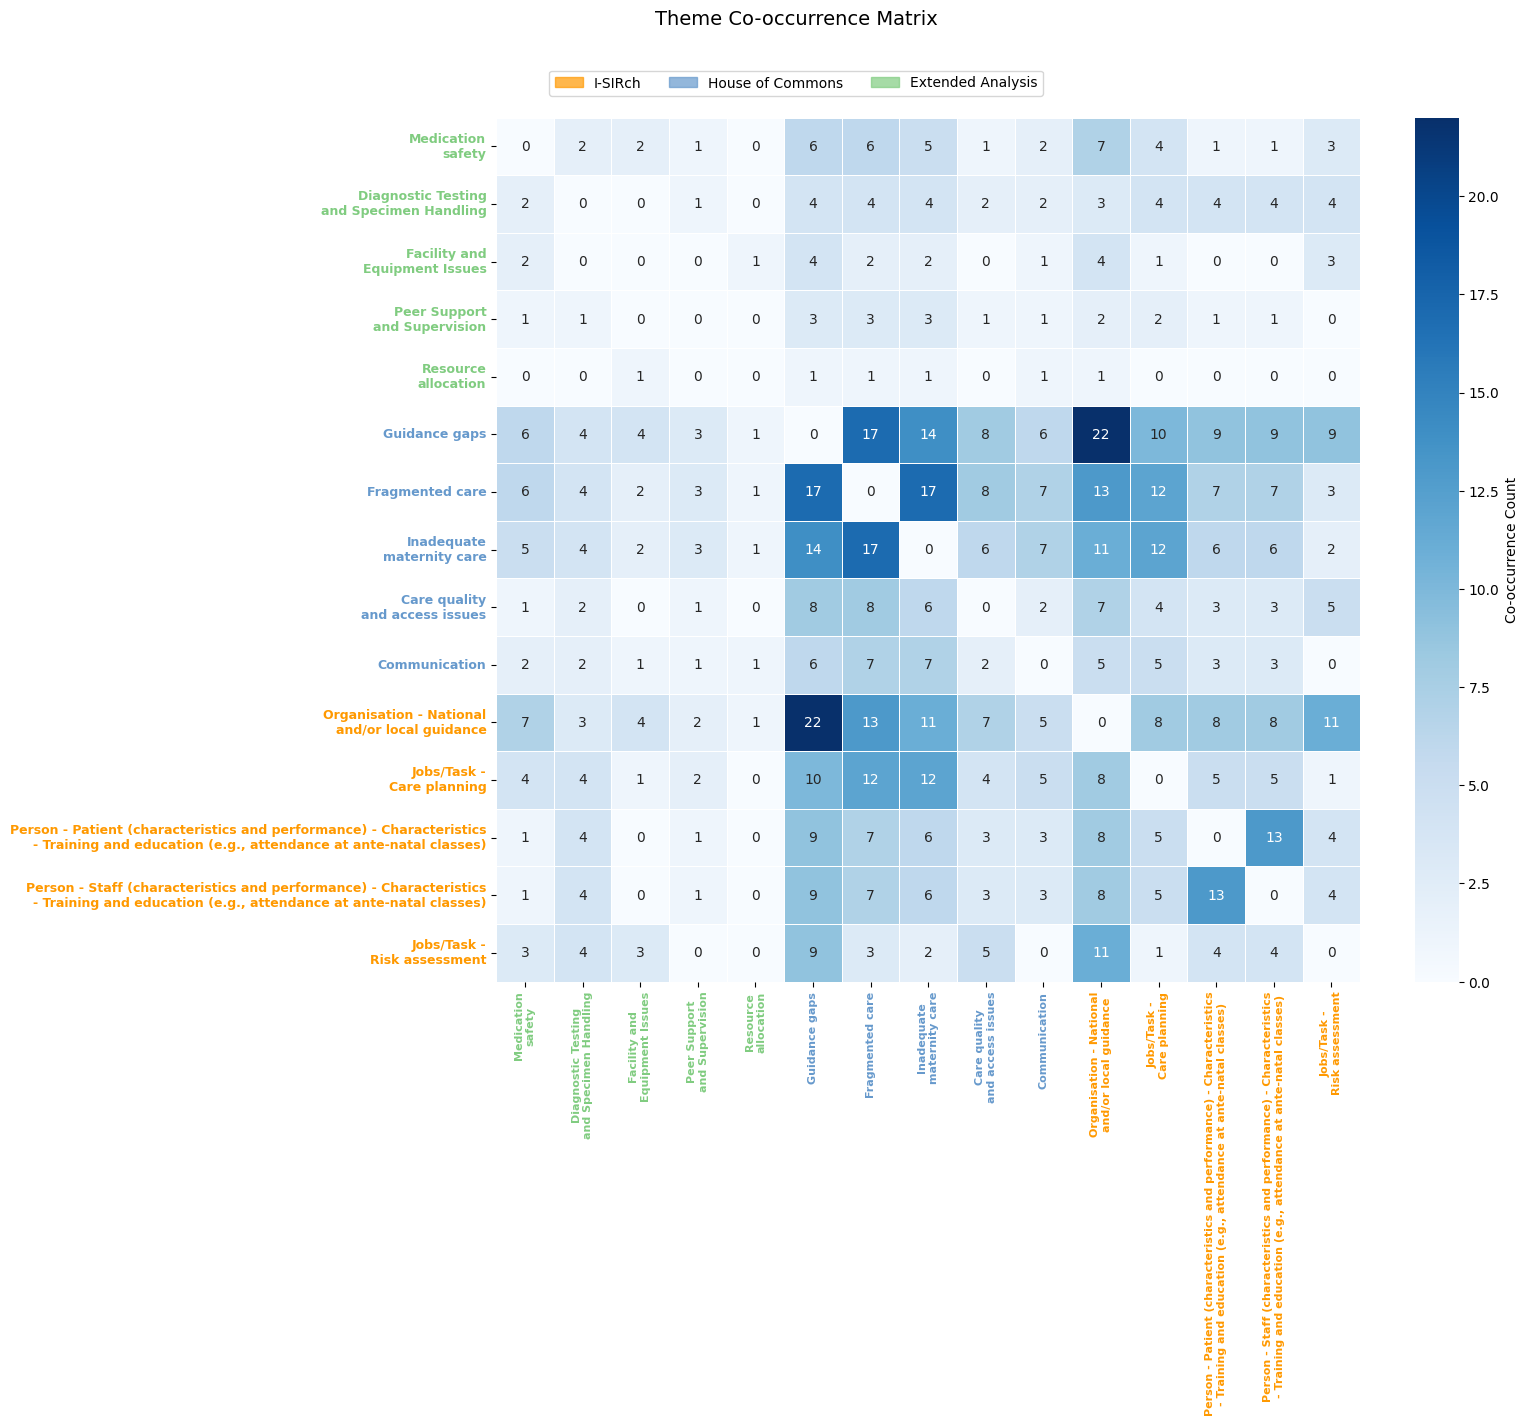

,Extended Analysis: Medication safety,Extended Analysis: Diagnostic Testing and Specimen Handling,Extended Analysis: Facility and Equipment Issues,Extended Analysis: Peer Support and Supervision,Extended Analysis: Resource allocation,House of Commons: Guidance gaps,House of Commons: Fragmented care,House of Commons: Inadequate maternity care,House of Commons: Care quality and access issues,House of Commons: Communication,I-SIRch: Organisation - National and/or local guidance,I-SIRch: Jobs/Task - Care planning,"I-SIRch: Person - Patient (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes)","I-SIRch: Person - Staff (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes)",I-SIRch: Jobs/Task - Risk assessment
Extended Analysis: Medication safety,0,2,2,1,0,6,6,5,1,2,7,4,1,1,3
Extended Analysis: Diagnostic Testing and Specimen Handling,2,0,0,1,0,4,4,4,2,2,3,4,4,4,4
Extended Analysis: Facility and Equipment Issues,2,0,0,0,1,4,2,2,0,1,4,1,0,0,3
Extended Analysis: Peer Support and Supervision,1,1,0,0,0,3,3,3,1,1,2,2,1,1,0
Extended Analysis: Resource allocation,0,0,1,0,0,1,1,1,0,1,1,0,0,0,0
House of Commons: Guidance gaps,6,4,4,3,1,0,17,14,8,6,22,10,9,9,9
House of Commons: Fragmented care,6,4,2,3,1,17,0,17,8,7,13,12,7,7,3
House of Commons: Inadequate maternity care,5,4,2,3,1,14,17,0,6,7,11,12,6,6,2
House of Commons: Care quality and access issues,1,2,0,1,0,8,8,6,0,2,7,4,3,3,5
House of Commons: Communication,2,2,1,1,1,6,7,7,2,0,5,5,3,3,0


In [ ]:
# @title Improved Theme by Theme Correlation Heatmap

# Install necessary packages if not already installed
!pip install pandas matplotlib seaborn openpyxl -q

from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import matplotlib.patches as mpatches
from collections import Counter

def create_theme_correlation_heatmap():
    """
    Create a heatmap showing theme-to-theme correlations
    with improved title and legend styling
    """
    print("Please upload your detailed_clinical_bert_analysis.xlsx file.")

    # Upload file
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded. Exiting.")
        return None

    # Get the filename
    filename = list(uploaded.keys())[0]

    # Read the file
    try:
        df = pd.read_excel(io.BytesIO(uploaded[filename]))
        print(f"\nFile loaded: {filename}")
        print(f"Total records: {len(df)}")
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return None

    # Basic data cleaning
    df = df[df['Theme'] != 'No Themes Detected']
    df = df[~df['Year'].isna()]

    # Print frameworks found
    frameworks = df['Framework'].unique()
    print(f"Frameworks found: {', '.join(frameworks)}")

    # Create combined framework:theme field
    df['Framework_Theme'] = df['Framework'] + ': ' + df['Theme']

    # Count total occurrences of each theme
    theme_counts = df.groupby('Framework_Theme')['Report ID'].nunique().reset_index()
    theme_counts.columns = ['Framework_Theme', 'Count']

    # Get top themes by framework (5 per framework)
    top_themes = []
    for framework in frameworks:
        framework_df = df[df['Framework'] == framework]
        framework_theme_counts = framework_df.groupby('Framework_Theme')['Report ID'].nunique()
        top_for_framework = framework_theme_counts.nlargest(5).index.tolist()
        top_themes.extend(top_for_framework)

    # Filter to only include reports with top themes
    filtered_df = df[df['Framework_Theme'].isin(top_themes)]

    # Create a mapping of framework to color - with orange for I-SIRch
    framework_colors = {}
    for framework in frameworks:
        if framework == 'I-SIRch':
            framework_colors[framework] = (1.0, 0.6, 0.0)  # Orange
        elif framework == 'House of Commons':
            framework_colors[framework] = (0.4, 0.6, 0.8)  # Blue
        else:
            framework_colors[framework] = (0.5, 0.8, 0.5)  # Green

    # Get all unique report IDs that contain the top themes
    report_ids = filtered_df['Report ID'].unique()

    # Create a report-theme matrix to track which themes appear in which reports
    # This is a dictionary mapping from report ID to a set of themes in that report
    report_themes = {}
    for report_id in report_ids:
        themes_in_report = set(filtered_df[filtered_df['Report ID'] == report_id]['Framework_Theme'])
        report_themes[report_id] = themes_in_report

    # Count co-occurrences of each pair of themes
    theme_cooccurrence = {t1: {t2: 0 for t2 in top_themes} for t1 in top_themes}

    # For each report, count theme co-occurrences
    for report_id, themes in report_themes.items():
        # For each pair of themes in this report
        for t1 in themes:
            for t2 in themes:
                if t1 != t2:  # Don't count self-pairs
                    theme_cooccurrence[t1][t2] += 1

    # Convert to a DataFrame for the heatmap
    cooccurrence_df = pd.DataFrame(theme_cooccurrence)

    # Sort themes by framework and frequency
    theme_total_counts = {theme: sum(theme_cooccurrence[theme].values()) for theme in top_themes}
    theme_frameworks = {theme: theme.split(':')[0] for theme in top_themes}

    # Create sort key: first by framework, then by total co-occurrences
    sorted_themes = sorted(
        top_themes,
        key=lambda x: (theme_frameworks[x], -theme_total_counts[x])
    )

    # Reindex the DataFrame with sorted themes
    cooccurrence_df = cooccurrence_df.reindex(index=sorted_themes, columns=sorted_themes)

    # Get theme display names (without framework prefix) and break long names
    theme_display_names = []
    for theme in sorted_themes:
        if ':' in theme:
            # Extract the actual theme name (after the framework prefix)
            theme_name = theme.split(':', 1)[1].strip()

            # Break long theme names at appropriate points
            if len(theme_name) > 15:
                # Try to break at a space near the middle
                words = theme_name.split()
                if len(words) > 1:
                    # Find a breaking point near the middle
                    mid_point = len(words) // 2
                    first_part = ' '.join(words[:mid_point])
                    second_part = ' '.join(words[mid_point:])
                    theme_name = f"{first_part}\n{second_part}"

            theme_display_names.append(theme_name)
        else:
            theme_display_names.append(theme)

    # Increase the figure size to account for longer labels, especially for x-axis
    plt.figure(figsize=(len(top_themes)*0.8 + 4, len(top_themes)*0.8 + 6))

    # Create the heatmap
    ax = sns.heatmap(
        cooccurrence_df,
        annot=True,
        fmt="g",  # General format for integers
        cmap="Blues",
        linewidths=0.5,
        square=True,  # Make cells square
        cbar_kws={'label': 'Co-occurrence Count'}
    )

    # Set the labels, using theme names without framework prefixes
    plt.xticks(np.arange(len(theme_display_names)) + 0.5, theme_display_names, rotation=90)
    plt.yticks(np.arange(len(theme_display_names)) + 0.5, theme_display_names, rotation=0)

    # Color the axis labels by framework
    for i, theme in enumerate(sorted_themes):
        framework = theme.split(':')[0]
        color = framework_colors[framework]

        # Color x-tick labels
        ax.get_xticklabels()[i].set_color(color)
        ax.get_xticklabels()[i].set_fontweight('bold')

        # Color y-tick labels
        ax.get_yticklabels()[i].set_color(color)
        ax.get_yticklabels()[i].set_fontweight('bold')

    # Add colored background to indicate framework groups
    curr_framework = None
    start_idx = 0

    for i, theme in enumerate(sorted_themes):
        framework = theme.split(':')[0]

        if curr_framework != framework:
            if curr_framework is not None:
                # Draw background for previous framework on y-axis
                rect = plt.Rectangle(
                    (-0.5, start_idx - 0.5),
                    0.5,  # Width
                    i - start_idx,  # Height
                    facecolor=framework_colors[curr_framework],
                    alpha=0.3,
                    zorder=-1
                )
                ax.add_patch(rect)

                # Draw background for previous framework on x-axis
                rect = plt.Rectangle(
                    (start_idx - 0.5, -0.5),
                    i - start_idx,  # Width
                    0.5,  # Height
                    facecolor=framework_colors[curr_framework],
                    alpha=0.3,
                    zorder=-1
                )
                ax.add_patch(rect)

            curr_framework = framework
            start_idx = i

    # Add the last framework group
    if curr_framework is not None:
        # Y-axis
        rect = plt.Rectangle(
            (-0.5, start_idx - 0.5),
            0.5,
            len(sorted_themes) - start_idx,
            facecolor=framework_colors[curr_framework],
            alpha=0.3,
            zorder=-1
        )
        ax.add_patch(rect)

        # X-axis
        rect = plt.Rectangle(
            (start_idx - 0.5, -0.5),
            len(sorted_themes) - start_idx,
            0.5,
            facecolor=framework_colors[curr_framework],
            alpha=0.3,
            zorder=-1
        )
        ax.add_patch(rect)

    # Create a legend for frameworks
    legend_patches = []
    for framework, color in framework_colors.items():
        patch = mpatches.Patch(color=color, label=framework, alpha=0.7)
        legend_patches.append(patch)

    # Set title using suptitle for better positioning
    plt.suptitle('Theme Co-occurrence Matrix', fontsize=14, y=0.94)

    # Position the legend under the title using figlegend - matching the other chart
    plt.figlegend(
        handles=legend_patches,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.91),  # Just below the title
        ncol=len(frameworks),
        fontsize=10
    )

    # Set the labels, using theme names without framework prefixes
    # Vertical labels on x-axis with more space and smaller font
    plt.xticks(
        np.arange(len(theme_display_names)) + 0.5,
        theme_display_names,
        rotation=90,  # Vertical rotation
        fontsize=8,   # Smaller font for better fit
        ha='center',  # Horizontally centered
        va='top'      # Align to top to make room for multiline text
    )

    # Horizontal labels on y-axis with enough space
    plt.yticks(
        np.arange(len(theme_display_names)) + 0.5,
        theme_display_names,
        fontsize=9
    )

    # Ensure there's enough space for the labels, especially at the bottom for x-axis
    plt.tight_layout()
    plt.subplots_adjust(left=0.3, bottom=0.4, top=0.88)  # Increased bottom margin significantly

    plt.show()

    return cooccurrence_df

# Run the function
create_theme_correlation_heatmap()

Please upload your detailed_clinical_bert_analysis.xlsx file.


Saving theme_analysis_results.xlsx to theme_analysis_results (2).xlsx

File loaded: theme_analysis_results (2).xlsx
Total records: 422
Frameworks found: I-SIRch, House of Commons, Extended Analysis


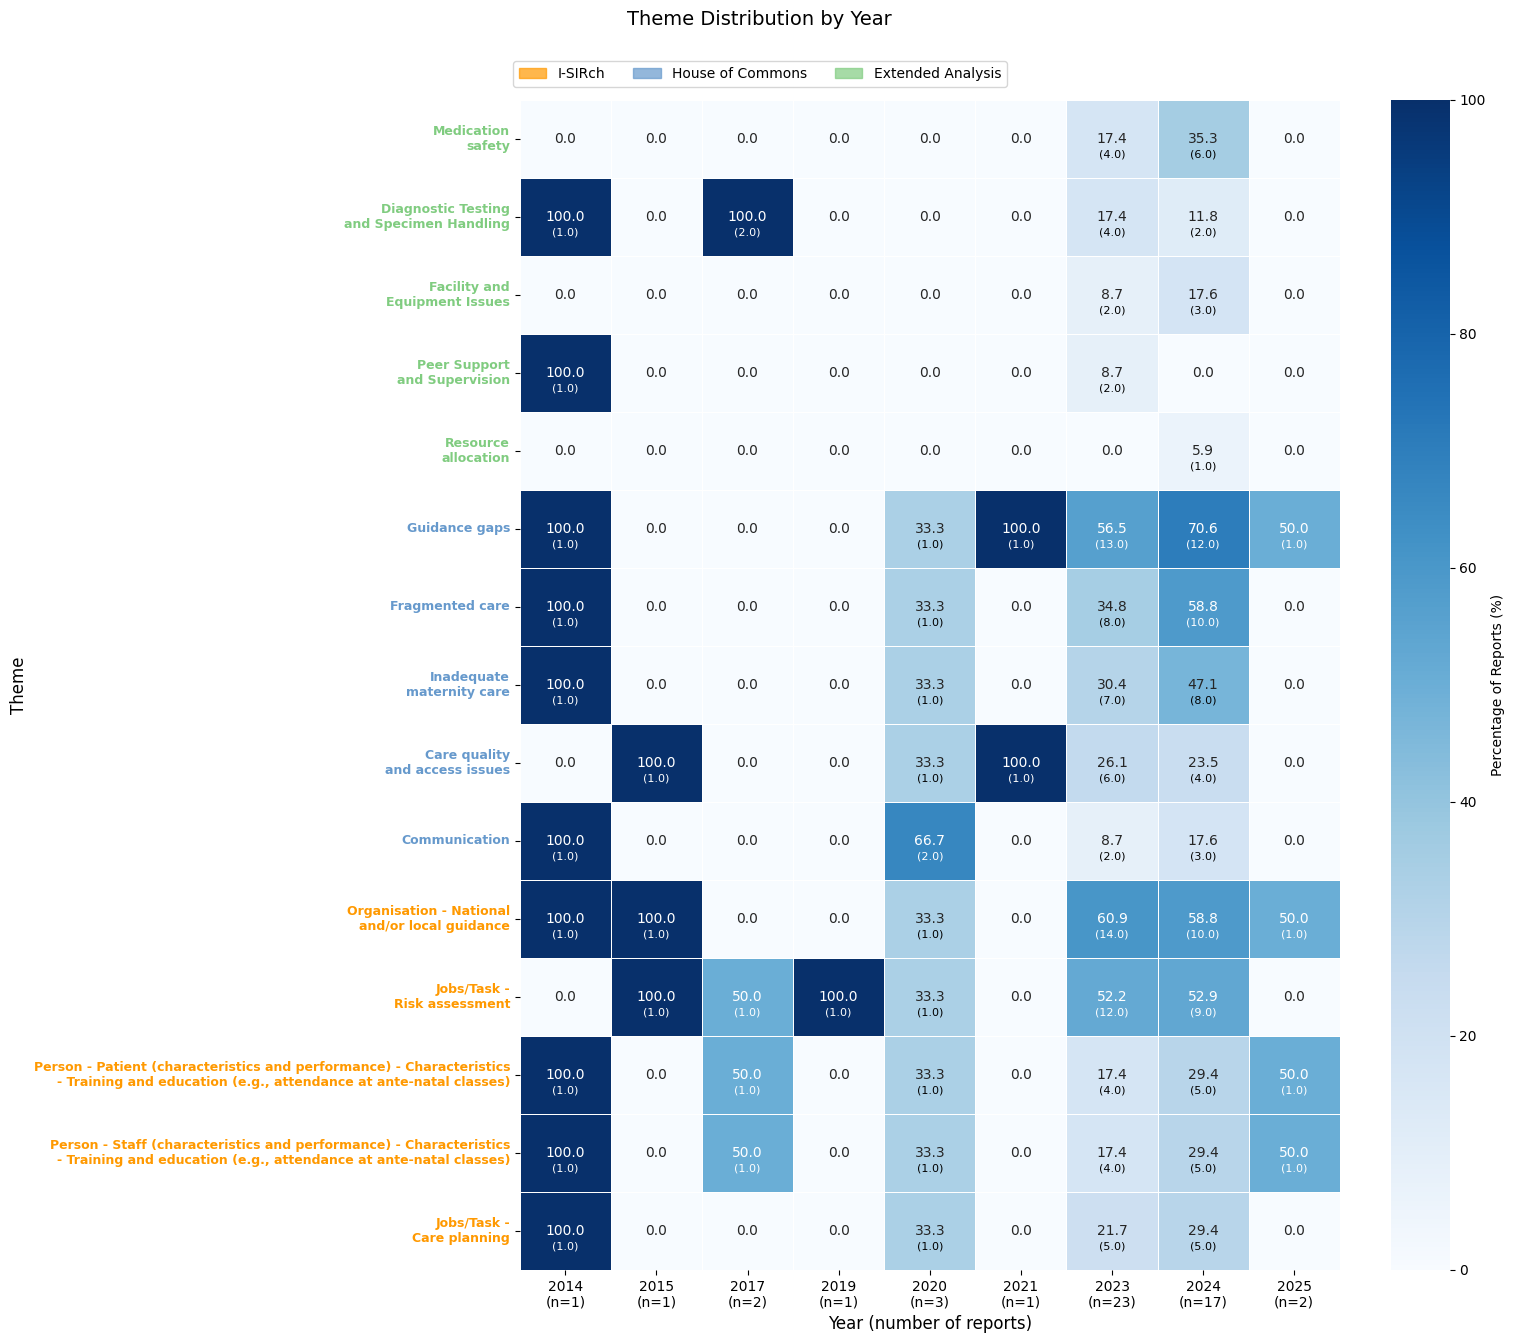

(Year                                                 2014   2015   2017  \
 Framework_Theme                                                           
 Extended Analysis: Medication safety                  0.0    0.0    0.0   
 Extended Analysis: Diagnostic Testing and Speci...  100.0    0.0  100.0   
 Extended Analysis: Facility and Equipment Issues      0.0    0.0    0.0   
 Extended Analysis: Peer Support and Supervision     100.0    0.0    0.0   
 Extended Analysis: Resource allocation                0.0    0.0    0.0   
 House of Commons: Guidance gaps                     100.0    0.0    0.0   
 House of Commons: Fragmented care                   100.0    0.0    0.0   
 House of Commons: Inadequate maternity care         100.0    0.0    0.0   
 House of Commons: Care quality and access issues      0.0  100.0    0.0   
 House of Commons: Communication                     100.0    0.0    0.0   
 I-SIRch: Organisation - National and/or local g...  100.0  100.0    0.0   
 I-SIRch: Jo

In [ ]:
# @title Framework-Based Heatmap by year

# Install necessary packages if not already installed
!pip install pandas matplotlib seaborn openpyxl -q

from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import matplotlib.patches as mpatches

def create_framework_heatmap():
    """
    Create a simple framework-colored heatmap of theme distribution by year
    with orange coloring for I-SIRch framework and improved line breaks
    """
    print("Please upload your detailed_clinical_bert_analysis.xlsx file.")

    # Upload file
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded. Exiting.")
        return None

    # Get the filename
    filename = list(uploaded.keys())[0]

    # Read the file
    try:
        df = pd.read_excel(io.BytesIO(uploaded[filename]))
        print(f"\nFile loaded: {filename}")
        print(f"Total records: {len(df)}")
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return None

    # Basic data cleaning
    df = df[df['Theme'] != 'No Themes Detected']
    df = df[~df['Year'].isna()]

    # Convert Year to integer
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df = df.dropna(subset=['Year'])
    df['Year'] = df['Year'].round().astype(int)

    # Print frameworks found
    frameworks = df['Framework'].unique()
    print(f"Frameworks found: {', '.join(frameworks)}")

    # Create combined framework:theme field
    df['Framework_Theme'] = df['Framework'] + ': ' + df['Theme']

    # Count reports per year (for denominator)
    reports_per_year = df.groupby('Year')['Report ID'].nunique()

    # Count unique report IDs per theme per year
    counts = df.groupby(['Year', 'Framework', 'Framework_Theme'])['Report ID'].nunique().reset_index()
    counts.columns = ['Year', 'Framework', 'Framework_Theme', 'Count']

    # Calculate percentages
    counts['Total'] = counts['Year'].map(reports_per_year)
    counts['Percentage'] = (counts['Count'] / counts['Total'] * 100).round(1)

    # Get top themes by framework (5 per framework)
    top_themes = []
    for framework in frameworks:
        framework_counts = counts[counts['Framework'] == framework]
        theme_totals = framework_counts.groupby('Framework_Theme')['Count'].sum().sort_values(ascending=False)
        top_themes.extend(theme_totals.head(5).index.tolist())

    # Filter to top themes
    counts = counts[counts['Framework_Theme'].isin(top_themes)]

    # Create pivot table for heatmap
    pivot = counts.pivot_table(
        index='Framework_Theme',
        columns='Year',
        values='Percentage',
        fill_value=0
    )

    # Create pivot for counts
    count_pivot = counts.pivot_table(
        index='Framework_Theme',
        columns='Year',
        values='Count',
        fill_value=0
    )

    # Sort by framework then by total count
    theme_totals = counts.groupby('Framework_Theme')['Count'].sum()
    theme_frameworks = {theme: theme.split(':')[0] for theme in theme_totals.index}

    # Sort first by framework, then by count within framework
    sorted_themes = sorted(
        theme_totals.index,
        key=lambda x: (theme_frameworks[x], -theme_totals[x])
    )

    # Apply the sort order
    pivot = pivot.reindex(sorted_themes)
    count_pivot = count_pivot.reindex(sorted_themes)

    # Set up the figure with extra space for labels
    plt.figure(figsize=(16, len(sorted_themes)*0.6 + 6))  # Added more height per theme

    # Create color mapping for frameworks - with orange for I-SIRch
    framework_colors = {}
    for framework in frameworks:
        if framework == 'I-SIRch':
            framework_colors[framework] = (1.0, 0.6, 0.0)  # Orange
        elif framework == 'House of Commons':
            framework_colors[framework] = (0.4, 0.6, 0.8)  # Blue
        else:
            framework_colors[framework] = (0.5, 0.8, 0.5)  # Green

    # Create the heatmap
    ax = sns.heatmap(
        pivot,
        annot=True,
        fmt=".1f",
        cmap="Blues",
        linewidths=0.5,
        vmin=0,
        vmax=100,
        cbar_kws={'label': 'Percentage of Reports (%)'}
    )

    # Add count annotations
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            if pivot.iloc[i, j] > 0:
                count = count_pivot.iloc[i, j]
                plt.text(
                    j + 0.5,
                    i + 0.7,
                    f"({count})",
                    ha='center',
                    va='center',
                    fontsize=8,
                    color='black' if pivot.iloc[i, j] < 50 else 'white'
                )

    # Clean up theme names for display (remove framework prefix) and break long names
    theme_labels = []
    for theme in pivot.index:
        if ':' in theme:
            # Extract the actual theme name (after the framework prefix)
            theme_name = theme.split(':', 1)[1].strip()

            # Break long theme names at appropriate points
            if len(theme_name) > 15:
                # Try to break at a space near the middle
                words = theme_name.split()
                if len(words) > 1:
                    # Find a breaking point near the middle
                    mid_point = len(words) // 2
                    first_part = ' '.join(words[:mid_point])
                    second_part = ' '.join(words[mid_point:])
                    theme_name = f"{first_part}\n{second_part}"

            theme_labels.append(theme_name)
        else:
            theme_labels.append(theme)

    # Add year counts to x-tick labels
    year_labels = [f"{year}\n(n={reports_per_year[year]})" for year in pivot.columns]

    # Set x and y tick labels
    plt.xticks(np.arange(len(pivot.columns)) + 0.5, year_labels, rotation=0)
    plt.yticks(
        np.arange(len(pivot.index)) + 0.5,
        theme_labels,
        fontsize=9  # Smaller font for y-axis labels to fit better
    )

    # Color the y-tick labels by framework
    for i, theme in enumerate(pivot.index):
        framework = theme.split(':')[0].strip()
        color = framework_colors[framework]
        ax.get_yticklabels()[i].set_color(color)
        ax.get_yticklabels()[i].set_fontweight('bold')

    # Add framework background groups
    curr_framework = None
    start_idx = 0

    for i, theme in enumerate(pivot.index):
        framework = theme.split(':')[0].strip()

        if curr_framework != framework:
            if curr_framework is not None:
                # Draw background for previous framework
                rect = plt.Rectangle(
                    (-0.5, start_idx - 0.5),
                    0.5,
                    i - start_idx,
                    facecolor=framework_colors[curr_framework],
                    alpha=0.3,
                    zorder=-1
                )
                ax.add_patch(rect)

            curr_framework = framework
            start_idx = i

    # Add the last framework group
    if curr_framework is not None:
        rect = plt.Rectangle(
            (-0.5, start_idx - 0.5),
            0.5,
            len(pivot.index) - start_idx,
            facecolor=framework_colors[curr_framework],
            alpha=0.3,
            zorder=-1
        )
        ax.add_patch(rect)

    # Create a legend for frameworks
    legend_patches = []
    for framework, color in framework_colors.items():
        patch = mpatches.Patch(color=color, label=framework, alpha=0.7)
        legend_patches.append(patch)

    # Set title first
    plt.suptitle('Theme Distribution by Year', fontsize=14, y=0.94)

    # Position the legend under the title
    plt.figlegend(
        handles=legend_patches,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.91),  # Just below the title
        ncol=len(frameworks),
        fontsize=10
    )

    # Set axis labels
    plt.xlabel('Year (number of reports)', fontsize=12)
    plt.ylabel('Theme', fontsize=12)

    # Adjust layout - ensure plenty of space for labels
    plt.tight_layout()
    plt.subplots_adjust(left=0.35, bottom=0.1, top=0.88)

    plt.show()

    return pivot, count_pivot

# Run the function
create_framework_heatmap()

# SECTION 4: ANALYSE THEMES BY REGION

Please upload your detailed_clinical_bert_analysis.xlsx file.


Saving theme_analysis_results.xlsx to theme_analysis_results (1).xlsx

File loaded: theme_analysis_results (1).xlsx
Total records: 422
Frameworks found: I-SIRch, House of Commons, Extended Analysis
Using 'deceased_name' for counting unique cases per area.
Coroner areas found: Avon, Berkshire, Berkshire Category: Child Death (from 2015) | Hospital Death (Clinical Procedures and medical management) related deaths This report is being sent to: Royal Berkshire NHS Foundation Trust, Berkshire Category: Hospital Death (Clinical Procedures and medical management) related deaths This report is being sent to: Egton Medical Information Systems, Blackpool & Fylde, Cambridgeshire and Peterborough, Central and South East Kent, County Durham and Darlington, Cumbria, Derby and Derbyshire, Derby and Derbyshire Category: Hospital Death (Clinical Procedures and medical management) related deaths This report is being sent to: The University Hospitals of Derby and Burton NHS FT, East London, East Riding a

<ipython-input-15-a49875bf2005>:212: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


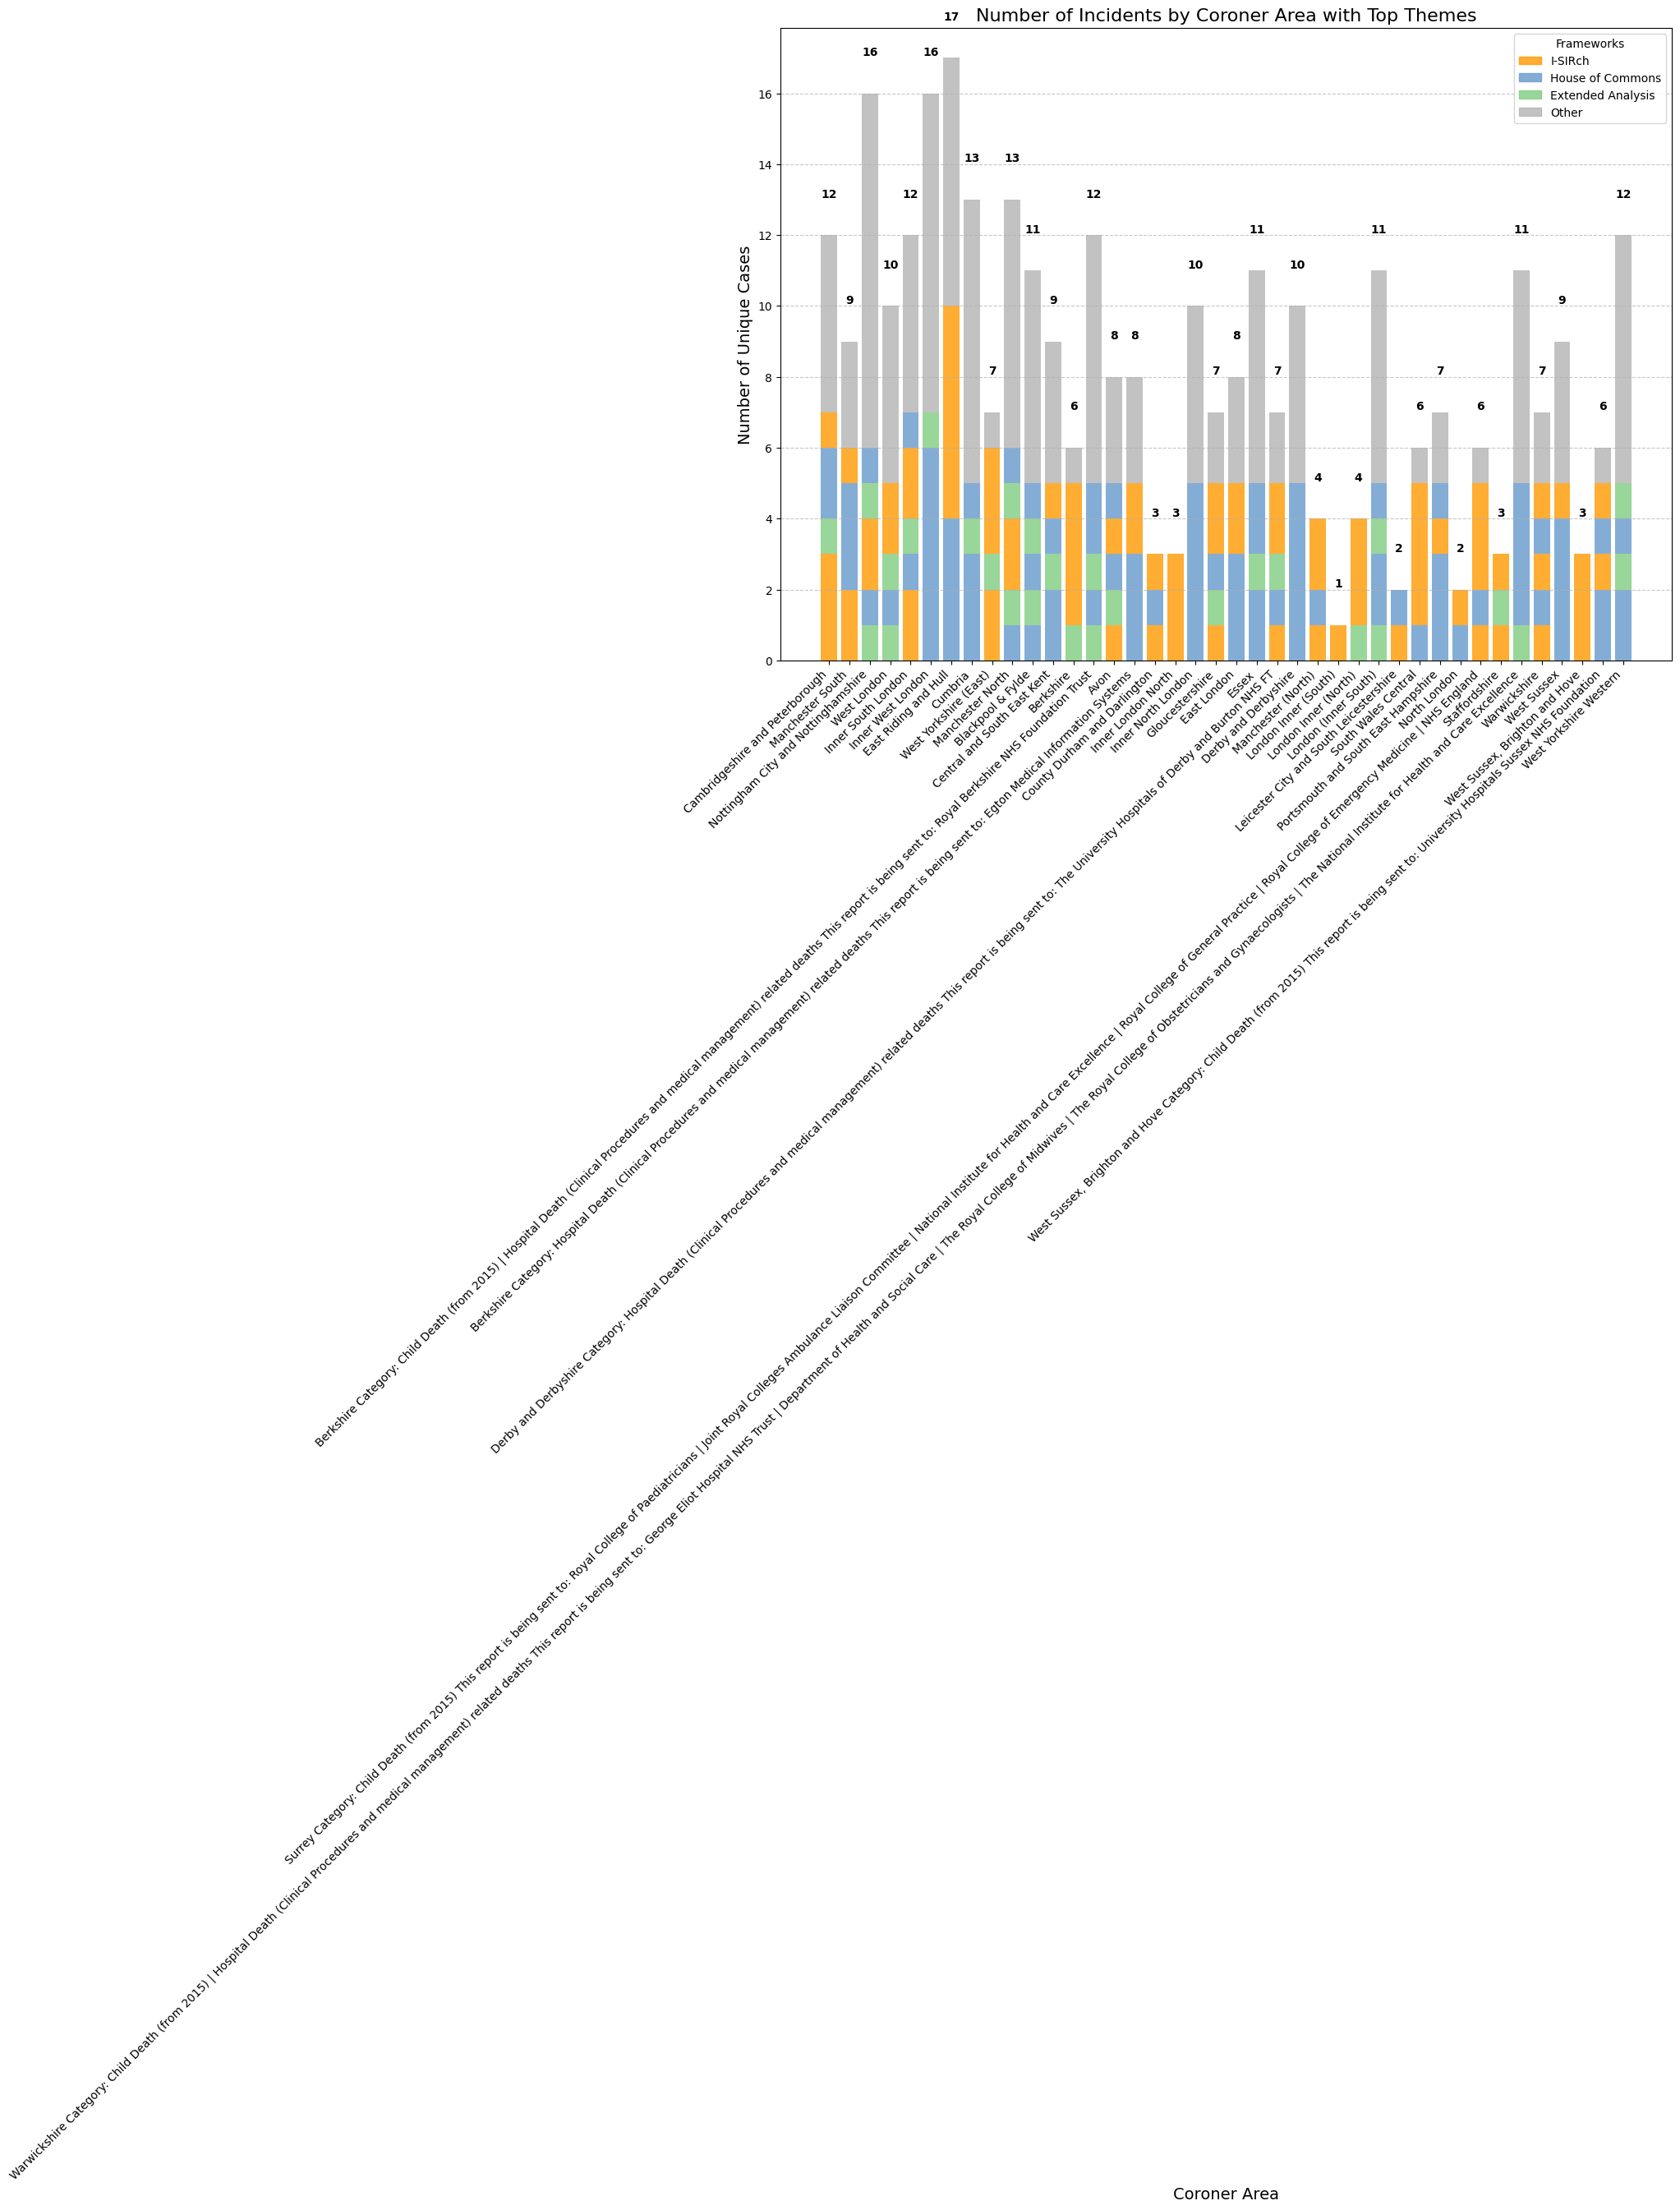

In [ ]:
# @title Incidents by Coroner Area with Top Themes Stacked Bar Chart

# Install necessary packages if not already installed
!pip install pandas matplotlib seaborn openpyxl -q

from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import matplotlib.patches as mpatches
from collections import Counter

def create_stacked_bar_chart_by_area():
    """
    Create a single stacked bar chart showing number of incidents per coroner area,
    with bars stacked by top themes/reasons.
    """
    print("Please upload your detailed_clinical_bert_analysis.xlsx file.")

    # Upload file
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded. Exiting.")
        return None

    # Get the filename
    filename = list(uploaded.keys())[0]

    # Read the file
    try:
        df = pd.read_excel(io.BytesIO(uploaded[filename]))
        print(f"\nFile loaded: {filename}")
        print(f"Total records: {len(df)}")
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return None

    # Basic data cleaning
    df = df[df['Theme'] != 'No Themes Detected']
    df = df[~df['Year'].isna()]

    # Print frameworks found
    frameworks = df['Framework'].unique()
    print(f"Frameworks found: {', '.join(frameworks)}")

    # Create combined framework:theme field
    df['Framework_Theme'] = df['Framework'] + ': ' + df['Theme']

    # Create a mapping of framework to color
    framework_colors = {}
    for framework in frameworks:
        if framework == 'I-SIRch':
            framework_colors[framework] = (1.0, 0.6, 0.0)  # Orange
        elif framework == 'House of Commons':
            framework_colors[framework] = (0.4, 0.6, 0.8)  # Blue
        else:
            framework_colors[framework] = (0.5, 0.8, 0.5)  # Green

    # Check if 'coroner_area' column exists
    if 'coroner_area' not in df.columns:
        print("The dataset doesn't have a 'coroner_area' column. Please make sure your data includes coroner area information.")
        return None

    # Check if 'deceased_name' column exists for proper counting
    if 'deceased_name' not in df.columns:
        print("Warning: 'deceased_name' column not found. Using 'Report ID' for counting instead.")
        id_column = 'Report ID'
    else:
        id_column = 'deceased_name'
        print(f"Using '{id_column}' for counting unique cases per area.")

    # Get all unique coroner areas
    areas = sorted(df['coroner_area'].unique())
    print(f"Coroner areas found: {', '.join(areas)}")

    # Calculate total cases per area (to sort by)
    cases_per_area = df.groupby('coroner_area')[id_column].nunique().reset_index()
    cases_per_area.columns = ['coroner_area', 'total_cases']
    cases_per_area = cases_per_area.sort_values('total_cases', ascending=False)

    # Sort areas by total number of cases
    sorted_areas = cases_per_area['coroner_area'].tolist()

    # Number of top themes to include in each stack
    n_top_themes = 5
    other_category = 'Other Themes'  # Category for remaining themes

    # For each area, find the top themes
    area_theme_data = []

    for area in sorted_areas:
        area_df = df[df['coroner_area'] == area]
        total_cases = cases_per_area[cases_per_area['coroner_area'] == area]['total_cases'].values[0]

        # Count each deceased_name only once per theme
        theme_counts = area_df.groupby('Framework_Theme')[id_column].nunique().reset_index()
        theme_counts.columns = ['Framework_Theme', 'Count']

        # Sort by count and get top N themes
        theme_counts = theme_counts.sort_values('Count', ascending=False)

        # Calculate sum of all themes (for validation)
        all_themes_sum = theme_counts['Count'].sum()

        # Split into top N and others
        top_themes = theme_counts.head(n_top_themes)
        other_themes_count = theme_counts.iloc[n_top_themes:]['Count'].sum() if len(theme_counts) > n_top_themes else 0

        # For each top theme, create a row in our data
        for _, row in top_themes.iterrows():
            theme = row['Framework_Theme']
            count = row['Count']
            framework = theme.split(':')[0]
            area_theme_data.append({
                'area': area,
                'theme': theme,
                'framework': framework,
                'count': count,
                'total_cases': total_cases
            })

        # Add "Other Themes" category if needed
        if other_themes_count > 0:
            area_theme_data.append({
                'area': area,
                'theme': other_category,
                'framework': 'Other',
                'count': other_themes_count,
                'total_cases': total_cases
            })

    # Convert to DataFrame for easier manipulation
    plot_df = pd.DataFrame(area_theme_data)

    # Create the stacked bar chart
    plt.figure(figsize=(14, 10))

    # Initialize the bottom of each stack to zero
    bottoms = np.zeros(len(sorted_areas))

    # Get unique themes and add "Other Themes" at the end
    themes = list(plot_df[plot_df['theme'] != other_category]['theme'].unique())
    themes.append(other_category)

    # Dictionary to store handles for the legend
    legend_handles = {}

    # For each theme, create a segment in the stacked bar
    for theme in themes:
        theme_data = plot_df[plot_df['theme'] == theme]
        counts = []

        # Get count for this theme in each area
        for area in sorted_areas:
            area_theme = theme_data[theme_data['area'] == area]
            count = area_theme['count'].sum() if not area_theme.empty else 0
            counts.append(count)

        # Get the color based on framework
        if theme == other_category:
            color = (0.7, 0.7, 0.7)  # Grey for "Other Themes"
            framework = 'Other'
        else:
            framework = theme.split(':')[0]
            color = framework_colors[framework]

        # Create the bar segment
        bar = plt.bar(sorted_areas, counts, bottom=bottoms, label=theme, color=color, alpha=0.8)

        # Add to legend handles (grouped by framework)
        if framework not in legend_handles:
            legend_handles[framework] = []
        legend_handles[framework].append((theme, bar))

        # Update bottoms for next segment
        bottoms += counts

    # Customize the plot
    plt.title('Number of Incidents by Coroner Area with Top Themes', fontsize=16)
    plt.xlabel('Coroner Area', fontsize=14)
    plt.ylabel('Number of Unique Cases', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Create a more organized legend
    # First, prepare patches for frameworks
    framework_patches = []
    for framework, color in framework_colors.items():
        patch = mpatches.Patch(color=color, label=framework, alpha=0.8)
        framework_patches.append(patch)

    # Add "Other" category for the Other Themes
    other_patch = mpatches.Patch(color=(0.7, 0.7, 0.7), label='Other', alpha=0.8)
    framework_patches.append(other_patch)

    # Add legend for frameworks
    plt.legend(
        handles=framework_patches,
        title='Frameworks',
        loc='upper right',
        fontsize=10
    )

    # Add data labels showing total count on top of each bar
    for i, area in enumerate(sorted_areas):
        total = plot_df[plot_df['area'] == area]['count'].sum()
        plt.text(i, total + 1, f'{int(total)}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Return the processed data
    return plot_df

# Run the function
if __name__ == "__main__":
    create_stacked_bar_chart_by_area()

In [ ]:
# @title Incidents by Coroner Area with Top Themes (Using Theme Column)

# Install necessary packages if not already installed
!pip install pandas matplotlib seaborn openpyxl -q

from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import matplotlib.patches as mpatches
from collections import Counter

def create_stacked_bar_chart_by_theme():
    """
    Create a single stacked bar chart showing number of incidents per coroner area,
    with bars stacked by top themes (using just the Theme column, not Framework_Theme).
    """
    print("Please upload your detailed_clinical_bert_analysis.xlsx file.")

    # Upload file
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded. Exiting.")
        return None

    # Get the filename
    filename = list(uploaded.keys())[0]

    # Read the file
    try:
        df = pd.read_excel(io.BytesIO(uploaded[filename]))
        print(f"\nFile loaded: {filename}")
        print(f"Total records: {len(df)}")
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return None

    # Basic data cleaning
    df = df[df['Theme'] != 'No Themes Detected']
    df = df[~df['Year'].isna()]

    # Print frameworks found
    frameworks = df['Framework'].unique()
    print(f"Frameworks found: {', '.join(frameworks)}")

    # Create a mapping of framework to color
    framework_colors = {}
    for framework in frameworks:
        if framework == 'I-SIRch':
            framework_colors[framework] = (1.0, 0.6, 0.0)  # Orange
        elif framework == 'House of Commons':
            framework_colors[framework] = (0.4, 0.6, 0.8)  # Blue
        else:
            framework_colors[framework] = (0.5, 0.8, 0.5)  # Green

    # Check if 'coroner_area' column exists
    if 'coroner_area' not in df.columns:
        print("The dataset doesn't have a 'coroner_area' column. Please make sure your data includes coroner area information.")
        return None

    # Check if 'deceased_name' column exists for proper counting
    if 'deceased_name' not in df.columns:
        print("Warning: 'deceased_name' column not found. Using 'Report ID' for counting instead.")
        id_column = 'Report ID'
    else:
        id_column = 'deceased_name'
        print(f"Using '{id_column}' for counting unique cases per area.")

    # Get all unique coroner areas
    areas = sorted(df['coroner_area'].unique())
    print(f"Coroner areas found: {', '.join(areas)}")

    # Calculate total cases per area (to sort by)
    cases_per_area = df.groupby('coroner_area')[id_column].nunique().reset_index()
    cases_per_area.columns = ['coroner_area', 'total_cases']
    cases_per_area = cases_per_area.sort_values('total_cases', ascending=False)

    # Sort areas by total number of cases
    sorted_areas = cases_per_area['coroner_area'].tolist()

    # Number of top themes to include in each stack
    n_top_themes = 5
    other_category = 'Other Themes'  # Category for remaining themes

    # For each area, find the top themes
    area_theme_data = []

    for area in sorted_areas:
        area_df = df[df['coroner_area'] == area]
        total_cases = cases_per_area[cases_per_area['coroner_area'] == area]['total_cases'].values[0]

        # Count each deceased_name only once per theme
        theme_counts = area_df.groupby(['Theme', 'Framework'])[id_column].nunique().reset_index()
        theme_counts.columns = ['Theme', 'Framework', 'Count']

        # Sort by count and get top N themes
        theme_counts = theme_counts.sort_values('Count', ascending=False)

        # Split into top N and others
        top_themes = theme_counts.head(n_top_themes)
        other_themes_count = theme_counts.iloc[n_top_themes:]['Count'].sum() if len(theme_counts) > n_top_themes else 0

        # For each top theme, create a row in our data
        for _, row in top_themes.iterrows():
            theme = row['Theme']
            framework = row['Framework']
            count = row['Count']
            area_theme_data.append({
                'area': area,
                'theme': theme,
                'framework': framework,
                'count': count,
                'total_cases': total_cases
            })

        # Add "Other Themes" category if needed
        if other_themes_count > 0:
            area_theme_data.append({
                'area': area,
                'theme': other_category,
                'framework': 'Other',
                'count': other_themes_count,
                'total_cases': total_cases
            })

    # Convert to DataFrame for easier manipulation
    plot_df = pd.DataFrame(area_theme_data)

    # Create the stacked bar chart
    plt.figure(figsize=(14, 10))

    # Initialize the bottom of each stack to zero
    bottoms = np.zeros(len(sorted_areas))

    # Get unique themes and add "Other Themes" at the end
    # Create a shorter display name for each theme
    theme_display_names = {}
    for theme in plot_df['theme'].unique():
        if theme == other_category:
            theme_display_names[theme] = theme
        else:
            # Shorten if needed
            if len(theme) > 25:
                theme_display_names[theme] = theme[:22] + '...'
            else:
                theme_display_names[theme] = theme

    # Get all themes except "Other Themes" and sort by total count
    theme_totals = plot_df[plot_df['theme'] != other_category].groupby('theme')['count'].sum().sort_values(ascending=False)
    sorted_themes = theme_totals.index.tolist()

    # Add "Other Themes" at the end
    if other_category in plot_df['theme'].unique():
        sorted_themes.append(other_category)

    # Dictionary to store handles for the legend
    theme_handles = []

    # Color map for consistent coloring
    unique_themes = sorted_themes.copy()
    if other_category in unique_themes:
        unique_themes.remove(other_category)  # Handle separately

    # Get color palette for themes (excluding "Other Themes")
    import colorsys

    def get_theme_colors(n_themes):
        """Generate n distinct colors"""
        colors = []
        for i in range(n_themes):
            hue = i/n_themes
            # Higher saturation and lighter value for better visibility
            saturation = 0.7
            value = 0.9
            rgb = colorsys.hsv_to_rgb(hue, saturation, value)
            colors.append(rgb)
        return colors

    theme_colors = {}
    generated_colors = get_theme_colors(len(unique_themes))
    for i, theme in enumerate(unique_themes):
        theme_colors[theme] = generated_colors[i]

    # Add "Other Themes" with grey color
    theme_colors[other_category] = (0.7, 0.7, 0.7)

    # For each theme, create a segment in the stacked bar
    for theme in sorted_themes:
        theme_data = plot_df[plot_df['theme'] == theme]
        counts = []

        # Get count for this theme in each area
        for area in sorted_areas:
            area_theme = theme_data[theme_data['area'] == area]
            count = area_theme['count'].sum() if not area_theme.empty else 0
            counts.append(count)

        # Get the color for this theme
        color = theme_colors[theme]

        # Create the bar segment
        bar = plt.bar(sorted_areas, counts, bottom=bottoms, label=theme_display_names[theme], color=color, alpha=0.8)

        # Add to legend handles
        theme_handles.append((theme_display_names[theme], bar))

        # Update bottoms for next segment
        bottoms += counts

    # Customize the plot
    plt.title('Number of Incidents by Coroner Area with Top Themes', fontsize=16)
    plt.xlabel('Coroner Area', fontsize=14)
    plt.ylabel('Number of Unique Cases', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Create a legend for the top 10 themes plus "Other Themes"
    legend_themes = sorted_themes[:10]  # Take top 10
    if other_category in sorted_themes:
        if other_category not in legend_themes:
            legend_themes.append(other_category)

    legend_handles = []
    for theme in legend_themes:
        patch = mpatches.Patch(color=theme_colors[theme], label=theme_display_names[theme], alpha=0.8)
        legend_handles.append(patch)

    plt.legend(
        handles=legend_handles,
        title='Top Themes',
        loc='upper right',
        fontsize=9
    )

    # Add data labels showing total count on top of each bar
    for i, area in enumerate(sorted_areas):
        total = cases_per_area[cases_per_area['coroner_area'] == area]['total_cases'].values[0]
        plt.text(i, bottoms[i] + 1, f'{int(total)}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Return the processed data
    return plot_df

# Run the function
if __name__ == "__main__":
    create_stacked_bar_chart_by_theme()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.5 MB/s eta 0:00:00
Please upload your detailed_clinical_bert_analysis.xlsx file.


Saving theme_analysis_results.xlsx to theme_analysis_results (4).xlsx

File loaded: theme_analysis_results (4).xlsx
Total records: 422
Using 'deceased_name' for counting unique cases per area.


HTML(value='<h3>Select Analysis Parameters</h3>')

SelectMultiple(description='Select Areas:', index=(0, 1), layout=Layout(height='150px', width='70%'), options=…

RadioButtons(description='Chart Type:', layout=Layout(width='50%'), options=('Bar Chart', 'Heatmap', 'Radar Ch…

Button(button_style='success', description='Generate Visualization', style=ButtonStyle())

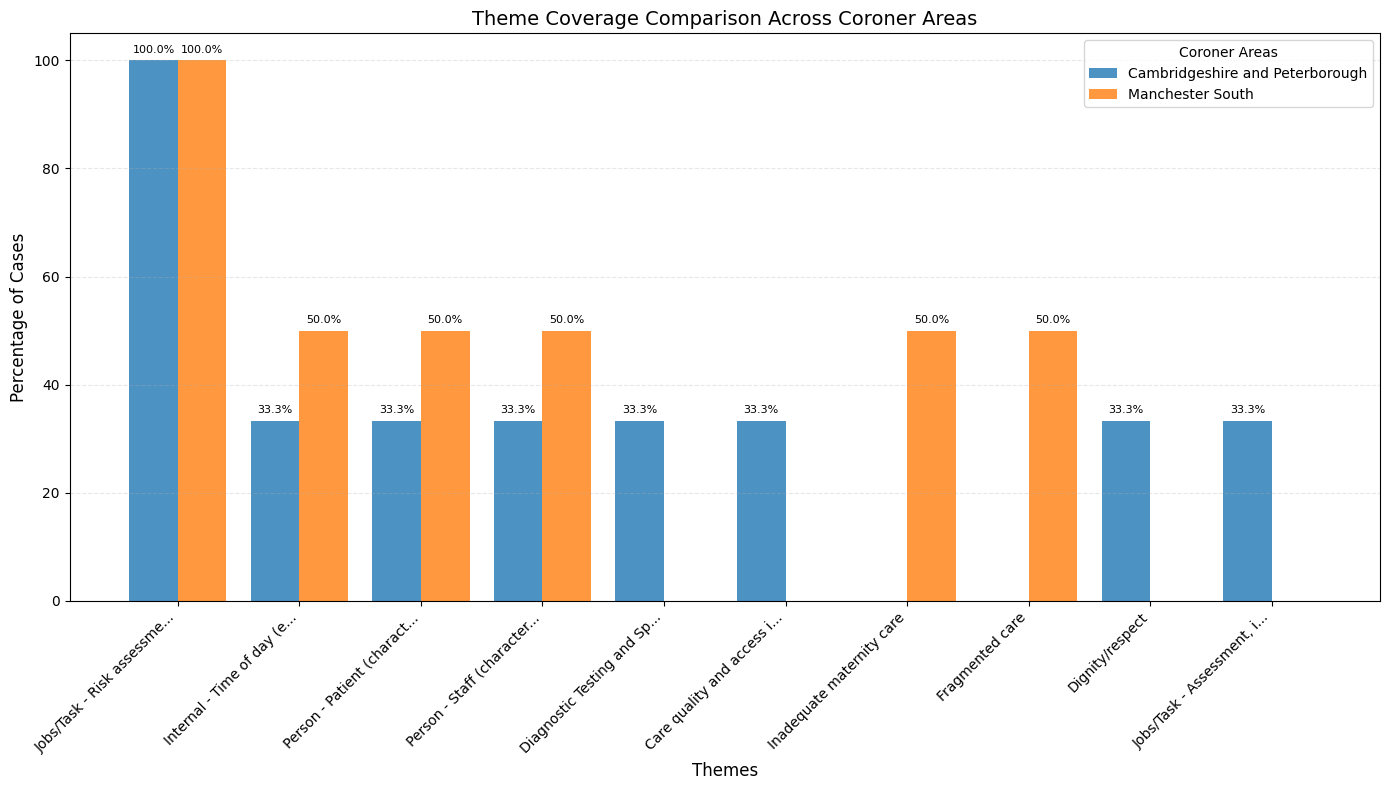


Full Theme Names:
1. Jobs/Task - Risk assessment
2. Internal - Time of day (e.g., night working or day of the week)
3. Person - Patient (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes)
4. Person - Staff (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes)
5. Diagnostic Testing and Specimen Handling
6. Care quality and access issues
10. Jobs/Task - Assessment, investigation, testing, screening (e.g., holistic review)


<ipython-input-18-981b1dcbab3d>:269: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


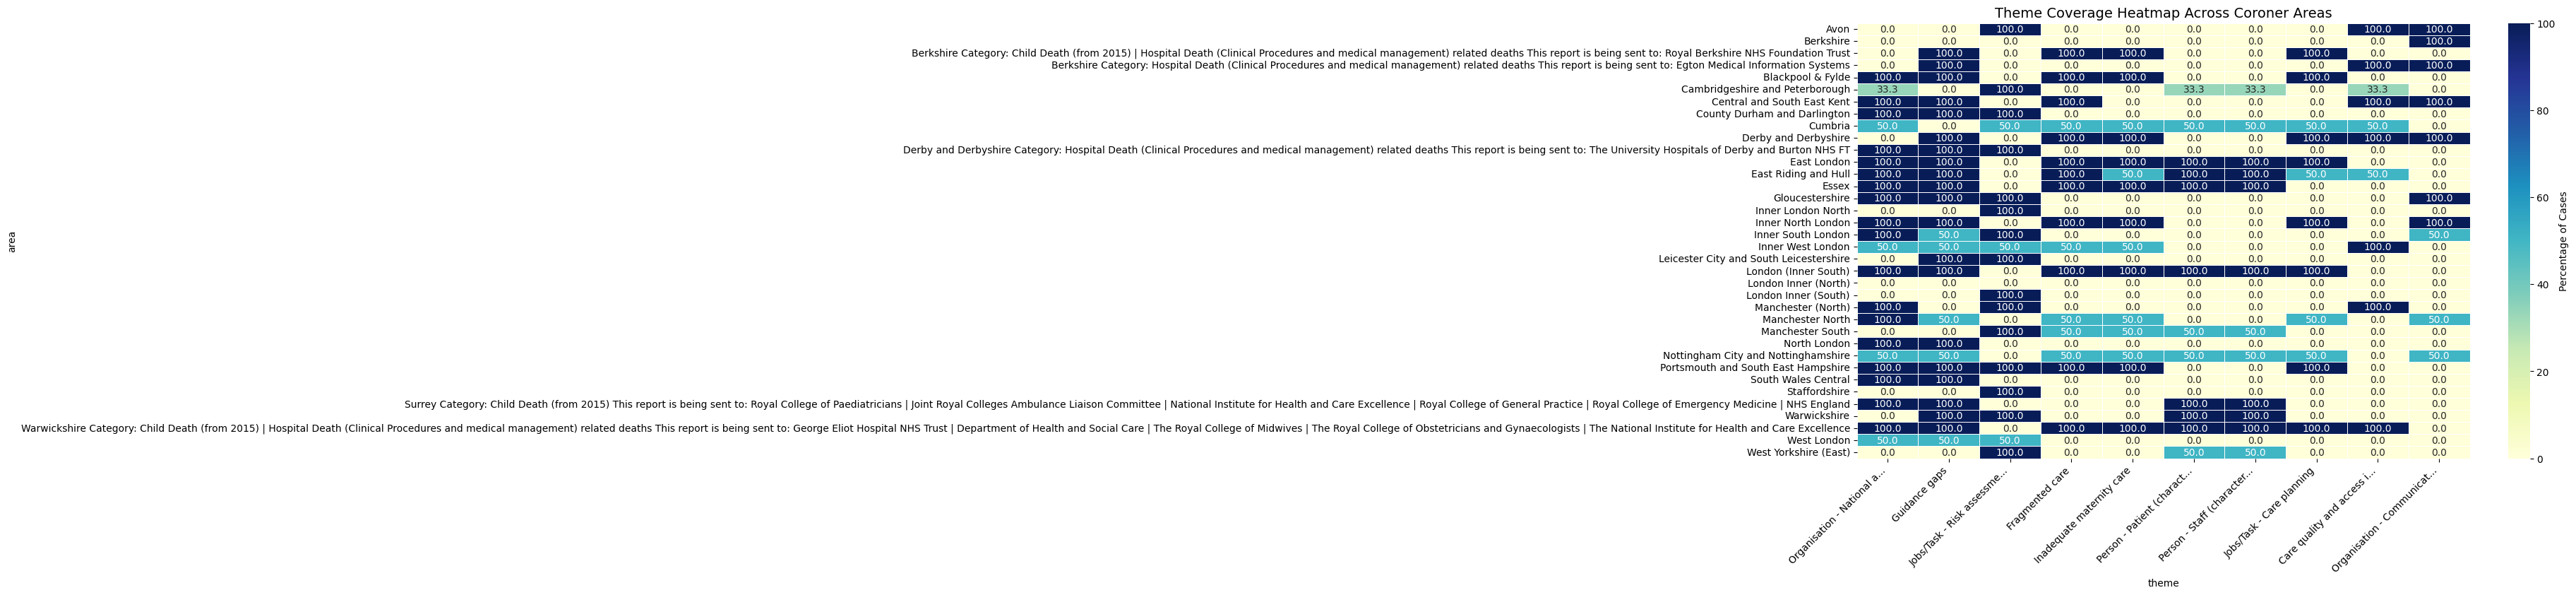


Full Theme Names:
1. Organisation - National and/or local guidance
3. Jobs/Task - Risk assessment
6. Person - Patient (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes)
7. Person - Staff (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes)
9. Care quality and access issues
10. Organisation - Communication factor - Between staff and patient (verbal)


In [ ]:
# @title Multi-Area Theme Comparison Charts

# Install necessary packages if not already installed
!pip install pandas matplotlib seaborn openpyxl ipywidgets -q

from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import matplotlib.patches as mpatches
from collections import Counter
from IPython.display import display
import ipywidgets as widgets
import textwrap

def create_multi_area_comparison():
    """
    Create interactive visualizations to compare theme coverage across multiple coroner areas
    """
    print("Please upload your detailed_clinical_bert_analysis.xlsx file.")

    # Upload file
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded. Exiting.")
        return None

    # Get the filename
    filename = list(uploaded.keys())[0]

    # Read the file
    try:
        df = pd.read_excel(io.BytesIO(uploaded[filename]))
        print(f"\nFile loaded: {filename}")
        print(f"Total records: {len(df)}")
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return None

    # Basic data cleaning
    df = df[df['Theme'] != 'No Themes Detected']
    df = df[~df['Year'].isna()]

    # Check if 'coroner_area' column exists
    if 'coroner_area' not in df.columns:
        print("The dataset doesn't have a 'coroner_area' column. Please make sure your data includes coroner area information.")
        return None

    # Check if 'deceased_name' column exists for proper counting
    if 'deceased_name' not in df.columns:
        print("Warning: 'deceased_name' column not found. Using 'Report ID' for counting instead.")
        id_column = 'Report ID'
    else:
        id_column = 'deceased_name'
        print(f"Using '{id_column}' for counting unique cases per area.")

    # Get all unique coroner areas and count cases
    areas_count = df.groupby('coroner_area')[id_column].nunique().reset_index()
    areas_count.columns = ['coroner_area', 'case_count']
    areas_count = areas_count.sort_values('case_count', ascending=False)

    # Get all unique themes and count occurrences
    theme_counts = df.groupby('Theme')[id_column].nunique().reset_index()
    theme_counts.columns = ['Theme', 'total_count']
    theme_counts = theme_counts.sort_values('total_count', ascending=False)

    # === INTERACTIVE WIDGETS ===

    # Multi-select for areas
    area_options = [(f"{area} ({count} cases)", area)
                   for area, count in zip(areas_count['coroner_area'], areas_count['case_count'])]

    area_selector = widgets.SelectMultiple(
        options=area_options,
        value=[area_options[0][1], area_options[1][1]] if len(area_options) > 1 else [area_options[0][1]],
        description='Select Areas:',
        disabled=False,
        layout=widgets.Layout(width='70%', height='150px')
    )

    # Number of themes to show
    num_themes = widgets.IntSlider(
        value=10,
        min=5,
        max=20,
        step=1,
        description='Top Themes:',
        continuous_update=False,
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )

    # Visualization type selector
    viz_type = widgets.RadioButtons(
        options=['Bar Chart', 'Heatmap', 'Radar Chart', 'Table'],
        value='Bar Chart',
        description='Chart Type:',
        disabled=False,
        layout=widgets.Layout(width='50%')
    )

    # Minimum case threshold
    case_threshold = widgets.IntSlider(
        value=1,
        min=1,
        max=10,
        step=1,
        description='Min Cases:',
        continuous_update=False,
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )

    # === VISUALIZATION FUNCTIONS ===

    def get_area_theme_data(selected_areas, top_n_themes=10, min_cases=1):
        """Get theme data for the selected areas"""
        # Filter areas with enough cases
        valid_areas = []
        for area in selected_areas:
            count = areas_count[areas_count['coroner_area'] == area]['case_count'].values[0]
            if count >= min_cases:
                valid_areas.append(area)
            else:
                print(f"Warning: {area} has fewer than {min_cases} cases and will be excluded.")

        if not valid_areas:
            print(f"No areas with at least {min_cases} cases selected. Please select areas with more cases or lower the threshold.")
            return None

        # Get the top N themes across all areas
        area_df = df[df['coroner_area'].isin(valid_areas)]
        overall_top_themes = area_df.groupby('Theme')[id_column].nunique().reset_index()
        overall_top_themes.columns = ['Theme', 'Count']
        overall_top_themes = overall_top_themes.sort_values('Count', ascending=False).head(top_n_themes)
        top_theme_list = overall_top_themes['Theme'].tolist()

        # Calculate percentages for each area and theme
        area_theme_data = []

        for area in valid_areas:
            # Get total cases for this area
            area_cases = areas_count[areas_count['coroner_area'] == area]['case_count'].values[0]
            area_df = df[df['coroner_area'] == area]

            # Get counts for each top theme in this area
            for theme in top_theme_list:
                theme_count = area_df[area_df['Theme'] == theme][id_column].nunique()
                percentage = (theme_count / area_cases * 100).round(1)

                area_theme_data.append({
                    'area': area,
                    'theme': theme,
                    'count': theme_count,
                    'total_cases': area_cases,
                    'percentage': percentage
                })

        # Convert to DataFrame
        result_df = pd.DataFrame(area_theme_data)

        return result_df, top_theme_list, valid_areas

    def create_bar_chart(data_df, theme_list, areas):
        """Create a grouped bar chart comparing theme coverage across areas"""
        if data_df is None or data_df.empty:
            return

        # Set up the figure
        plt.figure(figsize=(14, 8))

        # Number of areas and themes
        n_areas = len(areas)
        n_themes = len(theme_list)

        # Position indices for each group of bars
        indices = np.arange(n_themes)
        width = 0.8 / n_areas  # Width of each bar

        # Generate colors for each area
        colors = plt.cm.tab10.colors[:n_areas]

        # Plot bars for each area
        for i, area in enumerate(areas):
            area_data = data_df[data_df['area'] == area]
            area_percentages = []

            # Get percentage for each theme in this area
            for theme in theme_list:
                theme_data = area_data[area_data['theme'] == theme]
                percentage = theme_data['percentage'].values[0] if not theme_data.empty else 0
                area_percentages.append(percentage)

            # Position offset for this area's bars
            offset = i - n_areas/2 + 0.5
            x_pos = indices + offset * width

            # Create the bars
            bars = plt.bar(x_pos, area_percentages, width, label=area, color=colors[i], alpha=0.8)

            # Add value labels on bars
            for bar, percentage in zip(bars, area_percentages):
                if percentage > 0:
                    plt.text(
                        bar.get_x() + bar.get_width()/2,
                        bar.get_height() + 1,
                        f"{percentage}%",
                        ha='center', va='bottom',
                        fontsize=8,
                        rotation=0
                    )

        # Customize the chart
        plt.xlabel('Themes', fontsize=12)
        plt.ylabel('Percentage of Cases', fontsize=12)
        plt.title('Theme Coverage Comparison Across Coroner Areas', fontsize=14)
        plt.xticks(indices, [t[:25] + '...' if len(t) > 25 else t for t in theme_list], rotation=45, ha='right')
        plt.legend(title='Coroner Areas')
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.tight_layout()

        # Show the chart
        plt.show()

        # Display full theme names in a table
        if any(len(t) > 25 for t in theme_list):
            print("\nFull Theme Names:")
            for i, theme in enumerate(theme_list):
                if len(theme) > 25:
                    print(f"{i+1}. {theme}")

    def create_heatmap(data_df, theme_list, areas):
        """Create a heatmap comparing theme coverage across areas"""
        if data_df is None or data_df.empty:
            return

        # Pivot the data to create a matrix of areas x themes
        pivot_df = data_df.pivot(index='area', columns='theme', values='percentage')

        # Sort the themes by overall frequency
        pivot_df = pivot_df[theme_list]

        # Create the heatmap
        plt.figure(figsize=(14, 8))

        # Create the heatmap with a custom diverging colormap
        ax = sns.heatmap(
            pivot_df,
            annot=True,
            fmt=".1f",
            cmap="YlGnBu",
            linewidths=0.5,
            cbar_kws={'label': 'Percentage of Cases'}
        )

        # Customize the heatmap
        plt.title('Theme Coverage Heatmap Across Coroner Areas', fontsize=14)

        # Format theme names to prevent overlap
        ax.set_xticklabels(
            [t[:25] + '...' if len(t) > 25 else t for t in theme_list],
            rotation=45,
            ha='right'
        )

        plt.tight_layout()
        plt.show()

        # Display full theme names if any were truncated
        if any(len(t) > 25 for t in theme_list):
            print("\nFull Theme Names:")
            for i, theme in enumerate(theme_list):
                if len(theme) > 25:
                    print(f"{i+1}. {theme}")

    def create_radar_chart(data_df, theme_list, areas):
        """Create a radar chart comparing theme coverage across areas"""
        if data_df is None or data_df.empty:
            return

        # Check if we have more than 3 themes for a meaningful radar chart
        if len(theme_list) < 3:
            print("Need at least 3 themes for a radar chart. Please increase the number of themes.")
            return

        # Set up the figure
        fig = plt.figure(figsize=(14, 10))

        # Generate colors for each area
        colors = plt.cm.tab10.colors[:len(areas)]

        # Create a radar chart
        ax = fig.add_subplot(111, polar=True)

        # Number of themes (variables)
        N = len(theme_list)

        # What will be the angle of each axis in the plot
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # Close the loop

        # Draw one axis per variable and add labels
        plt.xticks(angles[:-1], [])

        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks([20, 40, 60, 80, 100], ["20%", "40%", "60%", "80%", "100%"], color="grey", size=8)
        plt.ylim(0, 100)

        # Plot each area
        for i, area in enumerate(areas):
            area_data = data_df[data_df['area'] == area]
            area_values = []

            # Get percentage for each theme
            for theme in theme_list:
                theme_data = area_data[area_data['theme'] == theme]
                percentage = theme_data['percentage'].values[0] if not theme_data.empty else 0
                area_values.append(percentage)

            # Close the loop
            area_values += [area_values[0]]

            # Plot the values
            ax.plot(angles, area_values, linewidth=2, linestyle='solid', color=colors[i], label=area)
            ax.fill(angles, area_values, color=colors[i], alpha=0.1)

        # Add theme labels with background boxes for better readability
        for i, angle in enumerate(angles[:-1]):
            if i < len(theme_list):  # Make sure we don't go out of bounds
                theme = theme_list[i]
                # Shorten theme name if needed
                if len(theme) > 20:
                    short_theme = theme[:17] + "..."
                else:
                    short_theme = theme

                # Calculate label position
                x = 1.25 * np.cos(angle)  # Slightly outside the main circle
                y = 1.25 * np.sin(angle)

                # Determine text alignment based on angle
                ha = "center"
                if abs(x) > 0.1:
                    ha = "left" if x > 0 else "right"

                va = "center"
                if abs(y) > 0.1:
                    va = "bottom" if y > 0 else "top"

                # Add the label with a background box
                plt.annotate(
                    short_theme,
                    xy=(angle, 100),  # Point at the edge of the chart
                    xytext=(x * 100, y * 100),  # Text slightly outside
                    textcoords='data',
                    ha=ha, va=va,
                    fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
                )

        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

        # Add title
        plt.title('Theme Coverage Comparison Across Coroner Areas', size=15, y=1.1)

        plt.tight_layout()
        plt.show()

        # Display full theme names if any were truncated
        if any(len(t) > 20 for t in theme_list):
            print("\nFull Theme Names:")
            for i, theme in enumerate(theme_list):
                if len(theme) > 20:
                    print(f"{i+1}. {theme}")

    def create_table_view(data_df, theme_list, areas):
        """Create a formatted table view of the data"""
        if data_df is None or data_df.empty:
            return

        # Pivot the data to create a matrix of areas x themes
        pivot_df = data_df.pivot(index='area', columns='theme', values='percentage')

        # Sort the themes by overall frequency
        pivot_df = pivot_df[theme_list]

        # Add total cases column
        case_counts = {}
        for area in areas:
            case_counts[area] = areas_count[areas_count['coroner_area'] == area]['case_count'].values[0]

        pivot_df['Total Cases'] = pivot_df.index.map(lambda x: case_counts.get(x, 0))

        # Format the percentages with % sign
        formatted_df = pivot_df.copy()
        for col in formatted_df.columns:
            if col != 'Total Cases':
                formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.1f}%" if not pd.isna(x) else "N/A")

        # Display the table
        print("\nTheme Coverage Percentage by Coroner Area:")
        display(formatted_df)

        # Also show the raw counts
        print("\nRaw Counts of Cases with Each Theme:")

        # Create raw count table
        count_df = data_df.pivot(index='area', columns='theme', values='count')
        count_df = count_df[theme_list]
        count_df['Total Cases'] = count_df.index.map(lambda x: case_counts.get(x, 0))

        display(count_df)

    # === MAIN VISUALIZATION FUNCTION ===

    def update_visualization(b):
        """Update the visualization based on current widget values"""
        selected_areas = area_selector.value
        selected_num_themes = num_themes.value
        selected_viz_type = viz_type.value
        selected_case_threshold = case_threshold.value

        if not selected_areas:
            print("Please select at least one coroner area.")
            return

        # Get the data
        data_df, top_themes, valid_areas = get_area_theme_data(
            selected_areas,
            top_n_themes=selected_num_themes,
            min_cases=selected_case_threshold
        )

        if data_df is None or data_df.empty:
            return

        # Create the visualization based on type
        if selected_viz_type == 'Bar Chart':
            create_bar_chart(data_df, top_themes, valid_areas)
        elif selected_viz_type == 'Heatmap':
            create_heatmap(data_df, top_themes, valid_areas)
        elif selected_viz_type == 'Radar Chart':
            create_radar_chart(data_df, top_themes, valid_areas)
        elif selected_viz_type == 'Table':
            create_table_view(data_df, top_themes, valid_areas)

    # Create a button to generate the visualization
    generate_button = widgets.Button(
        description='Generate Visualization',
        button_style='success'
    )

    # Connect the button click event
    generate_button.on_click(update_visualization)

    # Display all widgets
    display(widgets.HTML("<h3>Select Analysis Parameters</h3>"))
    display(area_selector)
    display(widgets.HBox([num_themes, case_threshold]))
    display(viz_type)
    display(generate_button)

    # Generate an initial visualization
    if len(area_options) > 0:
        update_visualization(None)

# Run the function
if __name__ == "__main__":
    create_multi_area_comparison()

# Text processing not needed

In [ ]:
# @title Text Preprocessing for Clinical Documents
# Comprehensive Text Preprocessing for Clinical Documents
# This script preprocesses the Content column of an Excel file containing clinical documents

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import numpy as np
from tqdm import tqdm

# Download NLTK resources (only needed once)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Apply comprehensive cleaning to text

    Args:
        text: Raw text string

    Returns:
        Cleaned text string
    """
    if not isinstance(text, str) or text is None:
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', ' ', text)

    # Remove numbers and special characters (but keep apostrophes for contractions)
    text = re.sub(r'[^\w\s\']', ' ', text)

    # Replace numbers with spaces
    text = re.sub(r'\d+', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def remove_stopwords(text):
    """
    Remove stopwords from text

    Args:
        text: Text to process

    Returns:
        Text with stopwords removed
    """
    stop_words = set(stopwords.words('english'))

    # Add custom stopwords relevant to clinical reports
    clinical_stopwords = {
        'report', 'regulation', 'coroner', 'prevention', 'future', 'deaths',
        'circumstances', 'death', 'concern', 'risk', 'paragraph', 'action',
        'response', 'section', 'matters', 'inquest'
    }

    stop_words.update(clinical_stopwords)

    # Split text into words and filter out stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]

    return ' '.join(filtered_words)

def lemmatize_text(text):
    """
    Lemmatize text to reduce words to their base form

    Args:
        text: Text to lemmatize

    Returns:
        Lemmatized text
    """
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(lemmatized_words)

def remove_boilerplate(text):
    """
    Remove common boilerplate text from coroner's reports

    Args:
        text: Text to process

    Returns:
        Text with boilerplate removed
    """
    # Common phrases in coroner's reports that don't add analytical value
    boilerplate_phrases = [
        "i am reporting to prevent future deaths",
        "regulation 28 report to prevent future deaths",
        "this report is being sent to",
        "in my opinion action should be taken",
        "in the circumstances it is my statutory duty",
        "you are under a duty",
        "your response must contain",
        "i have made a report",
        "under paragraph 7",
        "under regulation",
        "in my opinion there is a risk that future deaths will occur",
        "matters of concern are as follows",
        "during the course of the inquest",
        "following an inquest",
        "you must respond by",
        "your organisation has the power",
        "to my office by",
        "under the coroners and justice act"
    ]

    # Remove each boilerplate phrase
    for phrase in boilerplate_phrases:
        text = text.replace(phrase, " ")

    # Remove extra whitespace created by boilerplate removal
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocess_text(text):
    """
    Apply full preprocessing pipeline to text

    Args:
        text: Raw text string

    Returns:
        Fully preprocessed text
    """
    if not isinstance(text, str) or not text.strip():
        return ""

    # Apply preprocessing steps in sequence
    text = clean_text(text)
    text = remove_boilerplate(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)

    return text

def preprocess_excel_file(file_path, output_path=None, text_column='Content'):
    """
    Preprocess the text column in an Excel file

    Args:
        file_path: Path to the Excel file
        output_path: Path to save the processed file (if None, adds '_processed' to original name)
        text_column: Name of the column containing text to process

    Returns:
        DataFrame with preprocessed text
    """
    print(f"Loading data from {file_path}...")
    df = pd.read_excel(file_path)

    # Check if text column exists
    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' not found in the Excel file.")

    # Copy original text to a new column
    df['Original_Content'] = df[text_column]

    # Apply preprocessing to each document
    print("Preprocessing text...")
    tqdm.pandas()
    df[text_column] = df[text_column].progress_apply(preprocess_text)

    # Count words in original and preprocessed text
    df['Original_Word_Count'] = df['Original_Content'].apply(
        lambda x: len(str(x).split()) if isinstance(x, str) else 0
    )
    df['Processed_Word_Count'] = df[text_column].apply(
        lambda x: len(str(x).split()) if isinstance(x, str) else 0
    )

    # Calculate the reduction percentage
    df['Reduction_Percentage'] = np.round(
        (1 - (df['Processed_Word_Count'] / df['Original_Word_Count'])) * 100, 2
    )

    # Replace NaN and inf values with 0
    df['Reduction_Percentage'] = df['Reduction_Percentage'].replace([np.inf, -np.inf, np.nan], 0)

    # Set output path
    if output_path is None:
        output_path = file_path.replace('.xlsx', '_processed.xlsx')

    # Save processed data
    print(f"Saving processed data to {output_path}...")
    df.to_excel(output_path, index=False)

    # Generate summary statistics
    total_docs = len(df)
    empty_docs = df[text_column].isna().sum() + (df[text_column] == '').sum()
    avg_reduction = df['Reduction_Percentage'].mean()

    print("\nPreprocessing Summary:")
    print(f"Total documents: {total_docs}")
    print(f"Empty documents after preprocessing: {empty_docs}")
    print(f"Average text reduction: {avg_reduction:.2f}%")

    return df

# Example usage for Google Colab
if __name__ == "__main__":
    from google.colab import files

    # Upload the file
    print("Please upload your Excel file:")
    uploaded = files.upload()

    if uploaded:
        # Get the filename
        filename = list(uploaded.keys())[0]

        # Preprocess the file
        output_filename = filename.replace('.xlsx', '_processed.xlsx')
        processed_df = preprocess_excel_file(filename, output_filename)

        # Show a preview
        print("\nPreview of processed data:")
        preview_cols = ['Original_Content', 'Content', 'Reduction_Percentage']
        available_cols = [col for col in preview_cols if col in processed_df.columns]
        print(processed_df[available_cols].head())

        # Download the processed file
        files.download(output_filename)
        print(f"\nProcessed file has been downloaded as {output_filename}")
    else:
        print("No file uploaded.")

# Identify themes with transparency

*   List item
*   List item



In [ ]:
   !pip install transformers torch pandas scikit-learn tqdm xlsxwriter

In [ ]:
# @title Block 1: Theme Frameworks Only

def get_isirch_framework():
    """I-SIRCh framework themes mapped exactly to the official framework structure"""
    return [
        {"name": "External - Policy factor",
        "keywords": ["policy factor", "policy", "factor"]},

        {"name": "External - Societal factor",
        "keywords": ["societal factor", "societal", "factor"]},

        {"name": "External - Economic factor",
        "keywords": ["economic factor", "economic", "factor"]},

        {"name": "External - COVID ✓",
        "keywords": ["covid ✓", "covid"]},

        {"name": "External - Geographical factor (e.g. Location of patient)",
        "keywords": ["geographical factor", "geographical", "factor", "location of patient"]},

        {"name": "Internal - Physical layout and Environment",
        "keywords": ["physical layout and environment", "physical", "layout", "environment"]},

        {"name": "Internal - Acuity (e.g., capacity of the maternity unit as a whole)",
        "keywords": ["acuity", "capacity of the maternity unit as a whole"]},

        {"name": "Internal - Availability (e.g., operating theatres)",
        "keywords": ["availability", "operating theatres"]},

        {"name": "Internal - Time of day (e.g., night working or day of the week)",
        "keywords": ["time of day", "time", "night working or day of the week"]},

        {"name": "Organisation - Team culture factor (e.g., patient safety culture)",
        "keywords": ["team culture factor", "team", "culture", "factor", "patient safety culture"]},

        {"name": "Organisation - Incentive factor (e.g., performance evaluation)",
        "keywords": ["incentive factor", "incentive", "factor", "performance evaluation"]},

        {"name": "Organisation - Teamworking",
        "keywords": ["teamworking"]},

        {"name": "Organisation - Communication factor",
        "keywords": ["communication factor", "communication", "factor"]},

        {"name": "Organisation - Communication factor - Between staff",
        "keywords": ["between staff", "between", "staff"]},

        {"name": "Organisation - Communication factor - Between staff and patient (verbal)",
        "keywords": ["between staff and patient", "between", "staff", "patient", "verbal"]},

        {"name": "Organisation - Documentation",
        "keywords": ["documentation"]},

        {"name": "Organisation - Escalation/referral factor (including fresh eyes reviews)",
        "keywords": ["escalation/referral factor", "escalation/referral", "factor", "including fresh eyes reviews",
                    "specialist referral", "delay in escalation", "specialist review", "senior input",
                    "interdisciplinary referral", "escalation delay", "consultant opinion"]},

        {"name": "Organisation - National and/or local guidance",
        "keywords": ["national and/or local guidance", "national", "and/or", "local", "guidance",
                    "national screening", "screening program", "standard implementation",
                    "standardized screening", "protocol adherence"]},

        {"name": "Organisation - Language barrier",
        "keywords": ["language barrier", "language", "barrier"]},

        {"name": "Jobs/Task - Assessment, investigation, testing, screening (e.g., holistic review)",
        "keywords": ["assessment, investigation, testing, screening", "assessment,", "investigation,", "testing,",
                    "screening", "holistic review", "specimen", "sample", "laboratory", "test result",
                    "abnormal finding", "test interpretation"]},

        {"name": "Jobs/Task - Care planning",
        "keywords": ["care planning", "care", "planning"]},

        {"name": "Jobs/Task - Dispensing, administering",
        "keywords": ["dispensing, administering", "dispensing,", "administering"]},

        {"name": "Jobs/Task - Monitoring",
        "keywords": ["monitoring"]},

        {"name": "Jobs/Task - Risk assessment",
        "keywords": ["risk assessment", "risk", "assessment"]},

        {"name": "Jobs/Task - Situation awareness (e.g., loss of helicopter view)",
        "keywords": ["situation awareness", "situation", "awareness", "loss of helicopter view"]},

        {"name": "Jobs/Task - Obstetric review",
        "keywords": ["obstetric review", "obstetric", "review"]},

        {"name": "Technologies - Issues",
        "keywords": ["issues"]},

        {"name": "Technologies - Interpretation (e.g., CTG)",
        "keywords": ["interpretation", "ctg"]},

        {"name": "Person - Patient (characteristics and performance)",
        "keywords": ["patient", "characteristics and performance"]},

        {"name": "Person - Patient (characteristics and performance) - Characteristics",
        "keywords": ["characteristics", "patient characteristics"]},

        {"name": "Person - Patient (characteristics and performance) - Characteristics - Physical characteristics",
        "keywords": ["physical characteristics", "physical", "characteristics"]},

        {"name": "Person - Patient (characteristics and performance) - Characteristics - Psychological characteristics (e.g., stress, mental health)",
        "keywords": ["psychological characteristics", "psychological", "characteristics", "stress", "mental health"]},

        {"name": "Person - Patient (characteristics and performance) - Characteristics - Language competence (English)",
        "keywords": ["language competence", "language", "competence", "english"]},

        {"name": "Person - Patient (characteristics and performance) - Characteristics - Disability (e.g., hearing problems)",
        "keywords": ["disability", "hearing problems"]},

        {"name": "Person - Patient (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes)",
        "keywords": ["training and education", "training", "education", "attendance at ante-natal classes"]},

        {"name": "Person - Patient (characteristics and performance) - Characteristics - Record of attendance (e.g., failure to attend antenatal classes)",
        "keywords": ["record of attendance", "record", "attendance", "failure to attend antenatal classes"]},

        {"name": "Person - Patient (characteristics and performance) - Performance",
        "keywords": ["performance", "patient performance"]},

        {"name": "Person - Patient (characteristics and performance) - Performance - Slip or lapse (errors that tend to happen in routine tasks that people are doing without much conscious thought)",
        "keywords": ["slip or lapse", "slip", "lapse", "errors that tend to happen in routine tasks that people are doing without much conscious thought"]},

        {"name": "Person - Patient (characteristics and performance) - Performance - Decision error (errors in conscious judgements, decisions due to lack of knowledge and from misunderstanding of a situation)",
        "keywords": ["decision error", "decision", "error", "errors in conscious judgements", "decisions due to lack of knowledge and from misunderstanding of a situation"]},

        {"name": "Person - Patient (characteristics and performance) - Performance - Intentional rule breaking (deliberately do something different from rules)",
        "keywords": ["intentional rule breaking", "intentional", "rule", "breaking", "deliberately do something different from rules"]},

        {"name": "Person - Staff (characteristics and performance)",
        "keywords": ["staff", "characteristics and performance"]},

        {"name": "Person - Staff (characteristics and performance) - Characteristics",
        "keywords": ["characteristics", "staff characteristics"]},

        {"name": "Person - Staff (characteristics and performance) - Characteristics - Physical characteristics",
        "keywords": ["physical characteristics", "physical", "characteristics"]},

        {"name": "Person - Staff (characteristics and performance) - Characteristics - Psychological characteristics (e.g., stress, mental health)",
        "keywords": ["psychological characteristics", "psychological", "characteristics", "stress", "mental health"]},

        {"name": "Person - Staff (characteristics and performance) - Characteristics - Language competence (English)",
        "keywords": ["language competence", "language", "competence", "english"]},

        {"name": "Person - Staff (characteristics and performance) - Characteristics - Disability (e.g., hearing problems)",
        "keywords": ["disability", "hearing problems"]},

        {"name": "Person - Staff (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes)",
        "keywords": ["training and education", "training", "education", "attendance at ante-natal classes"]},

        {"name": "Person - Staff (characteristics and performance) - Characteristics - Record of attendance (e.g., failure to attend antenatal classes)",
        "keywords": ["record of attendance", "record", "attendance", "failure to attend antenatal classes"]},

        {"name": "Person - Staff (characteristics and performance) - Performance",
        "keywords": ["performance", "staff performance"]},

        {"name": "Person - Staff (characteristics and performance) - Performance - Slip or lapse (errors that tend to happen in routine tasks that people are doing without much conscious thought)",
        "keywords": ["slip or lapse", "slip", "lapse", "errors that tend to happen in routine tasks that people are doing without much conscious thought"]},

        {"name": "Person - Staff (characteristics and performance) - Performance - Decision error (errors in conscious judgements, decisions due to lack of knowledge and from misunderstanding of a situation)",
        "keywords": ["decision error", "decision", "error", "errors in conscious judgements", "decisions due to lack of knowledge and from misunderstanding of a situation"]},

        {"name": "Person - Staff (characteristics and performance) - Performance - Intentional rule breaking (deliberately do something different from rules)",
        "keywords": ["intentional rule breaking", "intentional", "rule", "breaking", "deliberately do something different from rules"]}
    ]

def get_house_of_commons_themes():
    """House of Commons themes mapped exactly to the official document"""
    return [
        {"name": "Communication",
        "keywords": ["communication", "dismissed", "listened", "concerns not taken seriously", "concerns", "seriously"]},

        {"name": "Fragmented care",
        "keywords": ["fragmented care", "fragmented", "care", "spread", "poorly", "communicating", "providers", "no clear coordination", "clear", "coordination"]},

        {"name": "Guidance gaps",
        "keywords": ["guidance gaps", "guidance", "gaps", "information", "needs", "optimal", "minority"]},

        {"name": "Pre-existing conditions and comorbidities",
        "keywords": ["pre-existing conditions and comorbidities", "pre-existing", "conditions", "comorbidities", "overrepresented", "ethnic", "minority", "contribute", "higher", "mortality"]},

        {"name": "Inadequate maternity care",
        "keywords": ["inadequate maternity care", "inadequate", "maternity", "care", "individualized", "culturally", "sensitive"]},

        {"name": "Care quality and access issues",
        "keywords": ["microaggressions and racism", "microaggressions", "racism", "implicit/explicit", "impacts", "access", "treatment", "quality", "stereotyping"]},

        {"name": "Socioeconomic factors and deprivation",
        "keywords": ["socioeconomic factors and deprivation", "socioeconomic", "factors", "deprivation", "links to poor outcomes", "links", "outcomes", "minority", "overrepresented", "deprived", "areas"]},

        {"name": "Biases and stereotyping",
        "keywords": ["biases and stereotyping", "biases", "stereotyping", "perpetuation", "stereotypes", "providers"]},

        {"name": "Consent/agency",
        "keywords": ["consent/agency", "consent", "agency", "informed consent", "agency over care decisions", "informed", "decisions"]},

        {"name": "Dignity/respect",
        "keywords": ["dignity/respect", "dignity", "respect", "neglectful", "lacking", "discrimination faced", "discrimination", "faced"]}
    ]

def get_extended_themes():
    """Extended Analysis themes with unique concepts not covered in I-SIRCh or House of Commons frameworks"""
    return [
        {"name": "Procedural and Process Failures",
        "keywords": ["procedure failure", "process breakdown", "protocol breach", "standard violation", "workflow issue",
                    "operational failure", "process gap", "procedural deviation", "system failure", "process error",
                    "workflow disruption", "task failure"]},

        {"name": "Medication safety",
        "keywords": ["medication safety", "medication", "safety", "drug error", "prescription", "drug administration",
                    "medication error", "adverse reaction", "medication reconciliation"]},

        {"name": "Resource allocation",
        "keywords": ["resource allocation", "resource", "allocation", "resource management", "resource constraints",
                    "prioritisation", "resource distribution", "staffing levels", "staff shortage", "budget constraints"]},

        {"name": "Facility and Equipment Issues",
        "keywords": ["facility", "equipment", "maintenance", "infrastructure", "device failure", "equipment malfunction",
                    "equipment availability", "technical failure", "equipment maintenance", "facility limitations"]},

        {"name": "Emergency preparedness",
        "keywords": ["emergency preparedness", "emergency protocol", "emergency response", "crisis management",
                    "contingency planning", "disaster readiness", "emergency training", "rapid response"]},

        {"name": "Staff Wellbeing and Burnout",
        "keywords": ["burnout", "staff wellbeing", "resilience", "psychological safety", "stress management",
                    "compassion fatigue", "work-life balance", "staff support", "mental health", "emotional burden"]},

        {"name": "Ethical considerations",
        "keywords": ["ethical dilemma", "ethical decision", "moral distress", "ethical conflict", "value conflict",
                    "ethics committee", "moral judgment", "conscientious objection", "ethical framework"]},

        {"name": "Diagnostic process",
        "keywords": ["diagnostic error", "misdiagnosis", "delayed diagnosis", "diagnostic uncertainty", "diagnostic reasoning",
                    "differential diagnosis", "diagnostic testing", "diagnostic accuracy", "test interpretation"]},

        {"name": "Post-Event Learning and Improvement",
        "keywords": ["incident learning", "corrective action", "improvement plan", "feedback loop", "lessons learned",
                    "action tracking", "improvement verification", "learning culture", "incident review",
                    "recommendation implementation", "systemic improvement", "organisational learning"]},

        {"name": "Electronic Health Record Issues",
        "keywords": ["electronic health record", "ehr issue", "alert fatigue", "interface design", "copy-paste error",
                    "dropdown selection", "clinical decision support", "digital documentation", "system integration",
                    "information retrieval", "data entry error", "electronic alert"]},

        {"name": "Time-Critical Interventions",
        "keywords": ["time-critical", "delayed intervention", "response time", "golden hour", "deterioration recognition",
                    "rapid response", "timely treatment", "intervention delay", "time sensitivity",
                    "critical timing", "delayed recognition", "prompt action", "urgent intervention",
                    "emergency response", "time-sensitive decision", "immediate action", "rapid assessment"]},

        {"name": "Human Factors and Cognitive Aspects",
        "keywords": ["cognitive bias", "situational awareness", "attention management", "visual perception",
                    "cognitive overload", "decision heuristic", "tunnel vision", "confirmation bias",
                    "fixation error", "anchoring bias", "memory limitation", "cognitive fatigue",
                    "isolation decision-making", "clinical confidence", "professional authority",
                    "hierarchical barriers", "professional autonomy"]},

        {"name": "Service Design and Patient Flow",
        "keywords": ["service design", "patient flow", "care pathway", "bottleneck", "patient journey",
                    "waiting time", "system design", "process mapping", "patient transfer", "capacity planning",
                    "workflow design", "service bottleneck"]},

        {"name": "Maternal and Neonatal Risk Factors",
        "keywords": ["maternal risk", "pregnancy complication", "obstetric risk", "neonatal risk", "fetal risk",
                    "gestational diabetes", "preeclampsia", "placental issue", "maternal age", "parity",
                    "previous cesarean", "multiple gestation", "fetal growth restriction", "prematurity",
                    "congenital anomaly", "birth asphyxia", "maternal obesity", "maternal hypertension",
                    "maternal infection", "obstetric hemorrhage", "maternal cardiac", "thromboembolism"]},

        {"name": "Private vs. NHS Care Integration",
        "keywords": ["private care", "private midwife", "private provider", "NHS interface", "care transition",
                    "private-public interface", "independent provider", "private consultation",
                    "private-NHS coordination", "privately arranged care", "independent midwife",
                    "cross-system communication"]},

        {"name": "Peer Support and Supervision",
        "keywords": ["peer support", "collegial support", "professional isolation", "clinical supervision",
                    "peer review", "case discussion", "professional feedback", "unsupported decision",
                    "lack of collegiality", "professional network", "mentoring", "supervision"]},

        {"name": "Diagnostic Testing and Specimen Handling",
        "keywords": ["specimen", "sample", "test result", "laboratory", "analysis", "interpretation",
                    "abnormal finding", "discolored", "contamination", "collection", "processing",
                    "transportation", "storage", "labeling", "amniocentesis", "blood sample"]}
    ]

# New section

In [ ]:
# @title Block 2: Class Definition with Core Methods

from google.colab import files
import io
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import json
from collections import Counter
from xlsxwriter import Workbook
import re
from IPython.display import HTML, display

class EnhancedClinicalBERTAnalyzerWithHighlighting:
    def __init__(self, model_name="emilyalsentzer/Bio_ClinicalBERT"):
        """
        Initialize ClinicalBERT model with improved analysis and text highlighting capabilities
        """
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

        # Predefined frameworks with themes (imported from Block 1)
        self.frameworks = {
            'I-SIRch': get_isirch_framework(),
            'House of Commons': get_house_of_commons_themes(),
            'Extended Analysis': get_extended_themes()
        }

        # Default threshold configurations
        self.config = {
            'base_similarity_threshold': 0.65,       # Minimum similarity score to consider
            'keyword_match_weight': 0.3,             # Weight for keyword match in combined score
            'semantic_similarity_weight': 0.7,       # Weight for semantic similarity in combined score
            'max_themes_per_framework': 5,           # Limit number of themes per framework
            'context_window_size': 200,              # Words to consider around keyword matches
            'enable_hierarchical_matching': True,    # Match parent themes if subthemes match
            'enable_keyword_expansion': True,        # Use expanded synonym set for keywords
            'highlight_color': 'orange',             # Default color for highlighting matched text
            'highlight_style': 'background-color',   # Style for highlighting (background-color or color)
        }

    def get_bert_embedding(self, text, max_length=512):
        """
        Enhanced embedding generation with expanded context
        """
        if not isinstance(text, str) or not text.strip():
            return np.zeros(768)

        # Truncate and tokenize with larger context
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=max_length,
            padding=True
        )

        # Get embeddings
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Use CLS token instead of mean pooling for better representation
        return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

    def _get_contextual_embedding(self, text, keyword, window_size=100):
        """
        Get embedding for text surrounding the keyword occurrence
        """
        if not isinstance(text, str) or not text.strip() or keyword not in text.lower():
            return self.get_bert_embedding(keyword)

        text_lower = text.lower()
        position = text_lower.find(keyword.lower())

        # Get context window
        start = max(0, position - window_size)
        end = min(len(text), position + len(keyword) + window_size)

        # Get contextual text
        context = text[start:end]

        return self.get_bert_embedding(context)

    def _calculate_combined_score(self, semantic_similarity, keyword_count, text_length):
        """
        Calculate combined score that balances semantic similarity and keyword presence
        """
        # Normalize keyword count by text length
        normalized_keyword_density = min(1.0, keyword_count / (text_length / 1000))

        # Weighted combination
        keyword_component = normalized_keyword_density * self.config['keyword_match_weight']
        semantic_component = semantic_similarity * self.config['semantic_similarity_weight']

        return keyword_component + semantic_component

    def _find_keyword_positions(self, text, keywords):
        """
        Find all positions where keywords appear in the text
        Returns a list of tuples (start_pos, end_pos, keyword)
        """
        if not isinstance(text, str) or not text.strip():
            return []

        positions = []
        text_lower = text.lower()

        for keyword in keywords:
            keyword_lower = keyword.lower()
            start_pos = 0

            # Find all occurrences of the keyword
            while start_pos < len(text_lower):
                pos = text_lower.find(keyword_lower, start_pos)
                if pos == -1:
                    break

                # Get the actual case from the original text
                actual_keyword = text[pos:pos + len(keyword)]
                positions.append((pos, pos + len(keyword), actual_keyword))

                # Move to next position
                start_pos = pos + 1

        # Sort by position
        return sorted(positions)

    def analyze_record_with_highlights(self, text):
        """
        Enhanced analysis that returns theme matches along with highlighted text
        """
        if not isinstance(text, str) or not text.strip():
            return {}, {}

        # Get full document embedding
        document_embedding = self.get_bert_embedding(text)
        text_length = len(text.split())

        framework_themes = {}
        theme_highlights = {}

        for framework_name, framework_theme_list in self.frameworks.items():
            # Track keyword matches across the entire document
            all_keyword_matches = []

            # First pass: identify all keyword matches and their contexts
            theme_matches = []
            for theme in framework_theme_list:
                # Find all keyword matches
                keyword_matches = []
                match_contexts = []
                keyword_positions = []

                # Find positions of all matching keywords in text
                for keyword in theme['keywords']:
                    if keyword.lower() in text.lower():
                        keyword_matches.append(keyword)

                        # Get contextual embeddings for each keyword occurrence
                        context_embedding = self._get_contextual_embedding(
                            text, keyword, self.config['context_window_size']
                        )
                        match_contexts.append(context_embedding)

                        # Find and store all positions for this keyword
                        positions = self._find_keyword_positions(text, [keyword])
                        keyword_positions.extend(positions)

                # Calculate semantic similarity with theme description
                theme_description = theme['name'] + ": " + ", ".join(theme['keywords'])
                theme_embedding = self.get_bert_embedding(theme_description)
                theme_doc_similarity = cosine_similarity([document_embedding], [theme_embedding])[0][0]

                # Calculate context similarities if available
                context_similarities = []
                if match_contexts:
                    for context_emb in match_contexts:
                        sim = cosine_similarity([context_emb], [theme_embedding])[0][0]
                        context_similarities.append(sim)

                # Use max context similarity if available, otherwise use document similarity
                max_context_similarity = max(context_similarities) if context_similarities else 0
                semantic_similarity = max(theme_doc_similarity, max_context_similarity)

                # Calculate combined score
                combined_score = self._calculate_combined_score(
                    semantic_similarity,
                    len(keyword_matches),
                    text_length
                )

                if keyword_matches and combined_score >= self.config['base_similarity_threshold']:
                    theme_matches.append({
                        'theme': theme['name'],
                        'semantic_similarity': round(semantic_similarity, 3),
                        'combined_score': round(combined_score, 3),
                        'matched_keywords': ', '.join(keyword_matches),
                        'keyword_count': len(keyword_matches),
                        'keyword_positions': keyword_positions  # Store positions for highlighting
                    })

                    all_keyword_matches.extend(keyword_matches)

            # Sort by combined score
            theme_matches.sort(key=lambda x: x['combined_score'], reverse=True)

            # Limit number of themes
            top_theme_matches = theme_matches[:self.config['max_themes_per_framework']]

            # Store theme matches and their highlighting info
            if top_theme_matches:
                # Count keywords to identify potential overlaps
                keyword_counter = Counter(all_keyword_matches)

                # Filter out themes with high keyword overlap and lower scores
                final_themes = []
                used_keywords = set()

                for theme_match in top_theme_matches:
                    # Check if this theme adds unique keywords
                    theme_keywords = set(theme_match['matched_keywords'].split(', '))
                    unique_keywords = theme_keywords - used_keywords

                    # If theme adds unique keywords or has high score, include it
                    if unique_keywords or theme_match['combined_score'] > 0.75:
                        # Store the theme data
                        theme_match_data = {
                            'theme': theme_match['theme'],
                            'semantic_similarity': theme_match['semantic_similarity'],
                            'combined_score': theme_match['combined_score'],
                            'matched_keywords': theme_match['matched_keywords'],
                            'keyword_count': theme_match['keyword_count']
                        }
                        final_themes.append(theme_match_data)

                        # Store the highlighting positions separately
                        theme_key = f"{framework_name}_{theme_match['theme']}"
                        theme_highlights[theme_key] = theme_match['keyword_positions']

                        used_keywords.update(theme_keywords)

                framework_themes[framework_name] = final_themes
            else:
                framework_themes[framework_name] = []

        return framework_themes, theme_highlights

    def create_highlighted_text(self, text, theme_highlights, html_format=True):
        """
        Create a highlighted version of the text with matched keywords highlighted
        Returns HTML or plain text with highlights based on the theme_highlights
        """
        if not text or not theme_highlights:
            return text

        # Convert highlights to a flat list of positions
        all_positions = []
        for theme_key, positions in theme_highlights.items():
            for pos_info in positions:
                all_positions.append((pos_info[0], pos_info[1], theme_key, pos_info[2]))

        # Sort positions by start position
        all_positions.sort()

        # Merge overlapping positions (when different themes highlight the same text)
        merged_positions = []
        if all_positions:
            current = all_positions[0]
            for i in range(1, len(all_positions)):
                if all_positions[i][0] <= current[1]:  # Overlap
                    # Extend current span
                    current = (current[0], max(current[1], all_positions[i][1]),
                              current[2] + "+" + all_positions[i][2], current[3])
                else:
                    merged_positions.append(current)
                    current = all_positions[i]
            merged_positions.append(current)

        # Create highlighted text
        result = []
        last_end = 0

        for start, end, theme_key, keyword in merged_positions:
            # Add text before this highlight
            if start > last_end:
                result.append(text[last_end:start])

            # Add highlighted text
            if html_format:
                # For HTML, use span with background color
                color = self.config['highlight_color']
                style = f"{self.config['highlight_style']}:{color};"
                result.append(f'<span style="{style}" title="{theme_key}">{text[start:end]}</span>')
            else:
                # For plain text, use markers like *** or [[]]
                result.append(f"[{text[start:end]}]")

            last_end = end

        # Add remaining text
        if last_end < len(text):
            result.append(text[last_end:])

        if html_format:
            return "".join(result)
        else:
            return "".join(result)

In [ ]:
# @title Block 3: Results Processing and Run Function

# Continue the EnhancedClinicalBERTAnalyzerWithHighlighting class
def create_detailed_results_with_highlights(self, df, content_column='Content'):
    """
    Create detailed results with improved metadata, confidence score, and text highlights
    """
    detailed_results = []
    highlighted_texts = {}

    # Progress tracking
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing Reports"):
        try:
            # Get content
            content = str(row[content_column]) if pd.notna(row[content_column]) else ''

            # Skip empty content
            if not content.strip():
                continue

            # Base record information
            base_record = row.to_dict()

            # Analyze with enhanced approach that includes highlighting
            analysis_results, theme_highlights = self.analyze_record_with_highlights(content)

            # Create highlighted text version
            highlighted_text = self.create_highlighted_text(content, theme_highlights)

            # Store the highlighted text with a unique identifier
            record_id = str(idx)
            if 'ID' in base_record:
                record_id = str(base_record['ID'])
            elif 'Id' in base_record:
                record_id = str(base_record['Id'])

            highlighted_texts[record_id] = highlighted_text

            # Process results
            for framework, themes in analysis_results.items():
                if themes:
                    for theme in themes:
                        record_entry = base_record.copy()
                        record_entry.update({
                            'Framework': framework,
                            'Theme': theme['theme'],
                            'Semantic Similarity': theme['semantic_similarity'],
                            'Combined Score': theme['combined_score'],
                            'Matched Keywords': theme['matched_keywords'],
                            'Keyword Count': theme['keyword_count'],
                            'Record ID': record_id  # Store ID for linking to highlighted text
                        })
                        detailed_results.append(record_entry)
                else:
                    # Add a placeholder if no themes detected
                    record_entry = base_record.copy()
                    record_entry.update({
                        'Framework': framework,
                        'Theme': 'No Themes Detected',
                        'Semantic Similarity': 0,
                        'Combined Score': 0,
                        'Matched Keywords': '',
                        'Keyword Count': 0,
                        'Record ID': record_id  # Store ID for linking to highlighted text
                    })
                    detailed_results.append(record_entry)

        except Exception as e:
            print(f"Error analyzing record {idx}: {str(e)}")

    # Create DataFrame
    results_df = pd.DataFrame(detailed_results)

    # Add confidence indicators
    if 'Combined Score' in results_df.columns:
        results_df['Confidence'] = results_df['Combined Score'].apply(
            lambda score: 'High' if score >= 0.8 else 'Medium' if score >= 0.65 else 'Low'
        )

    return results_df, highlighted_texts

def save_results_with_highlights(self, results_df, highlighted_texts, filename='highlighted_clinical_bert_analysis.xlsx'):
    """
    Save results to Excel with highlighted text in a separate sheet
    """
    # Create Excel writer with formatting
    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        # Write the main results
        results_df.to_excel(writer, sheet_name='ClinicalBERT Analysis', index=False)

        # Create a sheet for highlighted texts
        highlights_data = []
        for record_id, highlighted_text in highlighted_texts.items():
            # Replace HTML with Excel-friendly formatting
            # For Excel, we'll just keep the original text and provide a link to the HTML file
            plain_text = re.sub(r'<[^>]*>', '', highlighted_text)  # Remove HTML tags
            highlights_data.append({
                'Record ID': record_id,
                'Original Text': plain_text,
            })

        # Create DataFrame for highlights sheet
        if highlights_data:
            highlights_df = pd.DataFrame(highlights_data)
            highlights_df.to_excel(writer, sheet_name='Highlighted Texts', index=False)

        # Get the xlsxwriter workbook and worksheet objects
        workbook = writer.book
        worksheet = writer.sheets['ClinicalBERT Analysis']

        # Add formatting
        header_format = workbook.add_format({
            'bold': True,
            'text_wrap': True,
            'valign': 'top',
            'fg_color': '#D7E4BC',
            'border': 1
        })

        # Add confidence color formatting
        high_conf_format = workbook.add_format({'bg_color': '#C6EFCE'})
        med_conf_format = workbook.add_format({'bg_color': '#FFEB9C'})
        low_conf_format = workbook.add_format({'bg_color': '#FFC7CE'})

        # Write the column headers with the defined format
        for col_num, value in enumerate(results_df.columns.values):
            worksheet.write(0, col_num, value, header_format)

        # Apply conditional formatting for confidence column
        if 'Confidence' in results_df.columns:
            conf_col_idx = results_df.columns.get_loc('Confidence')
            for row_num, confidence in enumerate(results_df['Confidence']):
                cell_format = None
                if confidence == 'High':
                    cell_format = high_conf_format
                elif confidence == 'Medium':
                    cell_format = med_conf_format
                elif confidence == 'Low':
                    cell_format = low_conf_format

                if cell_format:
                    worksheet.write(row_num+1, conf_col_idx, confidence, cell_format)

        # Auto-adjust column widths
        for i, col in enumerate(results_df.columns):
            # Find the maximum length of the data in each column
            max_len = max(
                results_df[col].astype(str).map(len).max(),
                len(col)
            ) + 2  # Add some extra padding
            worksheet.set_column(i, i, min(50, max_len))  # Cap at 50 for readability

    # Save highlighted texts as HTML files
    html_dir = "highlighted_texts_html"
    import os
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)

    for record_id, highlighted_text in highlighted_texts.items():
        html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Highlighted Analysis - Record {record_id}</title>
            <style>
                body {{ font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }}
                h1 {{ color: #333; }}
                .highlighted-text {{ margin-top: 20px; padding: 15px; border: 1px solid #ddd; }}
            </style>
        </head>
        <body>
            <h1>Highlighted Analysis - Record {record_id}</h1>
            <div class="highlighted-text">
                {highlighted_text}
            </div>
        </body>
        </html>
        """

        with open(f"{html_dir}/record_{record_id}_highlighted.html", "w", encoding="utf-8") as f:
            f.write(html_content)

    # Create an index HTML file
    index_html = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Highlighted Text Analysis Index</title>
        <style>
            body { font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }
            h1 { color: #333; }
            ul { list-style-type: none; }
            li { margin: 10px 0; }
            a { color: #0066cc; text-decoration: none; }
            a:hover { text-decoration: underline; }
        </style>
    </head>
    <body>
        <h1>Highlighted Text Analysis Index</h1>
        <ul>
    """

    for record_id in highlighted_texts.keys():
        index_html += f'<li><a href="record_{record_id}_highlighted.html" target="_blank">Record {record_id}</a></li>\n'

    index_html += """
        </ul>
    </body>
    </html>
    """

    with open(f"{html_dir}/index.html", "w", encoding="utf-8") as f:
        f.write(index_html)

    return filename, html_dir

def display_highlighted_text(self, highlighted_text):
    """
    Display highlighted text in a notebook using IPython.display
    """
    display(HTML(highlighted_text))

def set_config(self, **kwargs):
    """
    Update configuration parameters
    """
    for key, value in kwargs.items():
        if key in self.config:
            self.config[key] = value
        else:
            print(f"Warning: Unknown configuration parameter '{key}'")

# Add the methods to the class
EnhancedClinicalBERTAnalyzerWithHighlighting.create_detailed_results_with_highlights = create_detailed_results_with_highlights
EnhancedClinicalBERTAnalyzerWithHighlighting.save_results_with_highlights = save_results_with_highlights
EnhancedClinicalBERTAnalyzerWithHighlighting.display_highlighted_text = display_highlighted_text
EnhancedClinicalBERTAnalyzerWithHighlighting.set_config = set_config

# Define the function to upload and analyze with highlights
def upload_and_analyze_with_highlights():
    """
    Interactive function to upload and analyze a file in Google Colab
    Uses the enhanced clinical BERT analyzer with text highlighting
    """
    print("Please upload your Excel file.")

    # Upload file
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded. Exiting.")
        return None

    # Get the filename
    filename = list(uploaded.keys())[0]

    # Read the file
    try:
        df = pd.read_excel(io.BytesIO(uploaded[filename]))

        # Print basic file info
        print(f"\nFile loaded: {filename}")
        print(f"Total records: {len(df)}")
        print("\nAvailable columns:")
        for col in df.columns:
            print(f"- {col}")
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return None

    # Choose content column
    print("\nSelect the column containing Coroner's section text for analysis:")
    text_columns = df.select_dtypes(include=['object']).columns
    for i, col in enumerate(text_columns):
        print(f"{i+1}. {col}")

    col_choice = input("Enter the number of the column: ").strip()

    try:
        content_column = text_columns[int(col_choice) - 1]
    except (ValueError, IndexError):
        print("Invalid selection. Using first text column.")
        content_column = text_columns[0]

    print(f"\nUsing column: {content_column}")

    print("\nUsing enhanced ClinicalBERT analyzer with text highlighting capability")

    # Choose highlighting color
    print("\nChoose highlighting color:")
    print("1. Orange (default)")
    print("2. Yellow")
    print("3. Light blue")
    print("4. Light green")

    color_choice = input("Enter your choice (1-4): ").strip()
    highlight_color = 'orange'  # default

    if color_choice == '2':
        highlight_color = 'yellow'
    elif color_choice == '3':
        highlight_color = 'lightblue'
    elif color_choice == '4':
        highlight_color = 'lightgreen'

    # Create analyzer with highlighting capability
    analyzer = EnhancedClinicalBERTAnalyzerWithHighlighting()

    # Set default threshold and highlighting settings
    analyzer.set_config(
        base_similarity_threshold=0.65,
        max_themes_per_framework=6,
        highlight_color=highlight_color
    )

    # Perform analysis with highlighting
    results_df, highlighted_texts = analyzer.create_detailed_results_with_highlights(
        df,
        content_column=content_column
    )

    # Save results to Excel and HTML
    results_filename, html_dir = analyzer.save_results_with_highlights(
        results_df,
        highlighted_texts
    )

    # Try to download the Excel file
    try:
        files.download(results_filename)
        print(f"\nAnalysis complete. Results saved and downloaded to {results_filename}")
        print(f"Highlighted HTML files saved in directory: {html_dir}")
        print(f"Open {html_dir}/index.html to browse all highlighted documents")
    except Exception as e:
        print(f"\nAnalysis complete. Results saved to {results_filename}")
        print(f"Highlighted HTML files saved in directory: {html_dir}")

    # Display summary statistics
    print("\nAnalysis Summary:")
    print(f"Total Records Analyzed: {len(df)}")
    print(f"Total Theme Predictions: {len(results_df)}")
    print(f"Total Highlighted Documents: {len(highlighted_texts)}")

    # Confidence distribution
    if 'Confidence' in results_df.columns:
        print("\nConfidence Distribution:")
        print(results_df['Confidence'].value_counts())

    # Framework distribution
    print("\nFramework Distribution:")
    print(results_df['Framework'].value_counts())

    # Top themes across frameworks
    print("\nTop Themes Across Frameworks:")
    if 'Combined Score' in results_df.columns:
        theme_summary = results_df.groupby(['Framework', 'Theme'])['Combined Score'].mean().sort_values(ascending=False)
        print(theme_summary.head(10))

    # Display a sample of highlighted text in the notebook
    if highlighted_texts:
        print("\nSample of highlighted text (first record):")
        first_record_id = list(highlighted_texts.keys())[0]
        analyzer.display_highlighted_text(highlighted_texts[first_record_id])

    return results_df, highlighted_texts

# Uncomment to run the analysis
#results, highlighted_texts = upload_and_analyze_with_highlights()

In [ ]:
# @title This modified function ensures the highlighting works correctly

def _find_keyword_positions(self, text, keywords):
    """
    Enhanced version - Find all positions where keywords appear in the text
    with more robust matching
    """
    if not isinstance(text, str) or not text.strip():
        return []

    positions = []
    text_lower = text.lower()

    for keyword in keywords:
        if not keyword or len(keyword) < 3:  # Skip very short keywords
            continue

        keyword_lower = keyword.lower()
        start_pos = 0

        # Find all occurrences of the keyword
        while start_pos < len(text_lower):
            pos = text_lower.find(keyword_lower, start_pos)
            if pos == -1:
                break

            # Verify this is a whole word by checking boundaries
            is_whole_word = True
            if pos > 0 and text_lower[pos-1].isalnum():
                is_whole_word = False
            if pos + len(keyword_lower) < len(text_lower) and text_lower[pos + len(keyword_lower)].isalnum():
                is_whole_word = False

            if is_whole_word:
                # Get the actual case from the original text
                actual_keyword = text[pos:pos + len(keyword)]
                positions.append((pos, pos + len(keyword), actual_keyword))

            # Move to next position (move past this word)
            start_pos = pos + 1

    # Sort by position
    return sorted(positions)

def create_highlighted_text(self, text, theme_highlights, html_format=True):
    """
    Enhanced version - Create highlighted text with better visibility and formatting
    """
    if not text or not theme_highlights:
        return text

    # Convert highlights to a flat list of positions
    all_positions = []
    for theme_key, positions in theme_highlights.items():
        for pos_info in positions:
            all_positions.append((pos_info[0], pos_info[1], theme_key, pos_info[2]))

    # Sort positions by start position
    all_positions.sort()

    # Merge overlapping positions (when different themes highlight the same text)
    merged_positions = []
    if all_positions:
        current = all_positions[0]
        for i in range(1, len(all_positions)):
            if all_positions[i][0] <= current[1]:  # Overlap
                # Extend current span
                current = (current[0], max(current[1], all_positions[i][1]),
                           current[2] + "+" + all_positions[i][2], current[3])
            else:
                merged_positions.append(current)
                current = all_positions[i]
        merged_positions.append(current)

    # Create highlighted text
    result = []
    last_end = 0

    for start, end, theme_key, keyword in merged_positions:
        # Add text before this highlight
        if start > last_end:
            result.append(text[last_end:start])

        # Add highlighted text
        if html_format:
            # Use stronger highlighting with background color, bold and border
            color = self.config['highlight_color']
            result.append(f'<span style="background-color:{color}; font-weight:bold; border:1px solid #333; padding:1px 3px; border-radius:2px;" title="{theme_key}">{text[start:end]}</span>')
        else:
            # For plain text, use markers like *** or [[]]
            result.append(f"**{text[start:end]}**")

        last_end = end

    # Add remaining text
    if last_end < len(text):
        result.append(text[last_end:])

    if html_format:
        return "".join(result)
    else:
        return "".join(result)

def save_results_with_highlights(self, results_df, highlighted_texts, filename='highlighted_clinical_bert_analysis.xlsx'):
    """
    Enhanced version - Save results with better highlighting and a direct preview
    """
    # Create Excel writer with formatting
    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        # Write the main results
        results_df.to_excel(writer, sheet_name='ClinicalBERT Analysis', index=False)

        # Create a sheet for highlighted texts
        highlights_data = []
        for record_id, highlighted_text in highlighted_texts.items():
            # Replace HTML with Excel-friendly formatting
            # For Excel, we'll just keep the original text and provide a link to the HTML file
            plain_text = re.sub(r'<[^>]*>', '', highlighted_text)  # Remove HTML tags
            highlights_data.append({
                'Record ID': record_id,
                'Original Text': plain_text,
            })

        # Create DataFrame for highlights sheet
        if highlights_data:
            highlights_df = pd.DataFrame(highlights_data)
            highlights_df.to_excel(writer, sheet_name='Highlighted Texts', index=False)

        # Get the xlsxwriter workbook and worksheet objects
        workbook = writer.book
        worksheet = writer.sheets['ClinicalBERT Analysis']

        # Add formatting
        header_format = workbook.add_format({
            'bold': True,
            'text_wrap': True,
            'valign': 'top',
            'fg_color': '#D7E4BC',
            'border': 1
        })

        # Add confidence color formatting
        high_conf_format = workbook.add_format({'bg_color': '#C6EFCE'})
        med_conf_format = workbook.add_format({'bg_color': '#FFEB9C'})
        low_conf_format = workbook.add_format({'bg_color': '#FFC7CE'})

        # Write the column headers with the defined format
        for col_num, value in enumerate(results_df.columns.values):
            worksheet.write(0, col_num, value, header_format)

        # Apply conditional formatting for confidence column
        if 'Confidence' in results_df.columns:
            conf_col_idx = results_df.columns.get_loc('Confidence')
            for row_num, confidence in enumerate(results_df['Confidence']):
                cell_format = None
                if confidence == 'High':
                    cell_format = high_conf_format
                elif confidence == 'Medium':
                    cell_format = med_conf_format
                elif confidence == 'Low':
                    cell_format = low_conf_format

                if cell_format:
                    worksheet.write(row_num+1, conf_col_idx, confidence, cell_format)

        # Auto-adjust column widths
        for i, col in enumerate(results_df.columns):
            # Find the maximum length of the data in each column
            max_len = max(
                results_df[col].astype(str).map(len).max(),
                len(col)
            ) + 2  # Add some extra padding
            worksheet.set_column(i, i, min(50, max_len))  # Cap at 50 for readability

    # Save highlighted texts as HTML files with improved styling
    html_dir = "highlighted_texts_html"
    import os
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)

    for record_id, highlighted_text in highlighted_texts.items():
        html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Highlighted Analysis - Record {record_id}</title>
            <style>
                body {{ font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }}
                h1 {{ color: #333; }}
                .highlighted-text {{ margin-top: 20px; padding: 15px; border: 1px solid #ddd; background-color: #fff; }}
                .theme-legend {{ margin-top: 30px; border: 1px solid #ddd; padding: 10px; background-color: #f9f9f9; }}
                .theme-legend h2 {{ margin-top: 0; font-size: 18px; }}
                .sample {{ display: inline-block; margin-right: 5px; width: 20px; height: 15px; }}
            </style>
        </head>
        <body>
            <h1>Highlighted Analysis - Record {record_id}</h1>
            <div class="highlighted-text">
                {highlighted_text}
            </div>
            <div class="theme-legend">
                <h2>Hover over highlighted text to see theme details</h2>
                <p>Example: <span style="background-color:{self.config['highlight_color']}; font-weight:bold; border:1px solid #333; padding:1px 3px; border-radius:2px;">Highlighted text</span> shows matched keywords</p>
            </div>
        </body>
        </html>
        """

        with open(f"{html_dir}/record_{record_id}_highlighted.html", "w", encoding="utf-8") as f:
            f.write(html_content)

    # Create an index HTML file with improved styling
    index_html = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Highlighted Text Analysis Index</title>
        <style>
            body { font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }
            h1 { color: #333; }
            ul { list-style-type: none; padding: 0; }
            li { margin: 10px 0; background: #f5f5f5; padding: 10px; border-radius: 4px; }
            a { color: #0066cc; text-decoration: none; font-weight: bold; }
            a:hover { text-decoration: underline; }
            .open-all { margin: 20px 0; padding: 10px; background: #4CAF50; color: white; border: none;
                        border-radius: 4px; cursor: pointer; font-size: 16px; }
            .info { background: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 20px 0; }
        </style>
        <script>
            function openAllDocuments() {
                const links = document.querySelectorAll('ul a');
                links.forEach(link => {
                    window.open(link.href, '_blank');
                });
            }
        </script>
    </head>
    <body>
        <h1>Highlighted Text Analysis Index</h1>
        <div class="info">
            <p>Click on a record below to view it with highlighted text that triggered theme identification.</p>
            <p>Hover over highlighted text to see which theme it belongs to.</p>
        </div>
        <button class="open-all" onclick="openAllDocuments()">Open All Documents</button>
        <ul>
    """

    for record_id in highlighted_texts.keys():
        index_html += f'<li><a href="record_{record_id}_highlighted.html" target="_blank">Record {record_id}</a></li>\n'

    index_html += """
        </ul>
    </body>
    </html>
    """

    with open(f"{html_dir}/index.html", "w", encoding="utf-8") as f:
        f.write(index_html)

    # Create a direct preview file that you can open immediately
    preview_html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Highlighted Text Preview</title>
        <style>
            body {{ font-family: Arial, sans-serif; line-height: 1.6; margin: 0; padding: 0; }}
            .sidebar {{ width: 250px; position: fixed; height: 100%; overflow: auto;
                     background-color: #f1f1f1; padding: 20px 10px; }}
            .main {{ margin-left: 270px; padding: 20px; }}
            h1 {{ color: #333; }}
            ul {{ list-style-type: none; padding: 0; }}
            li {{ margin: 5px 0; padding: 8px; background: #fff; border: 1px solid #ddd; }}
            li:hover {{ background-color: #e9e9e9; }}
            a {{ color: #0066cc; text-decoration: none; display: block; }}
            iframe {{ border: 1px solid #ddd; width: 100%; height: 800px; }}
        </style>
        <script>
            function loadDocument(url) {{
                document.getElementById('preview-frame').src = url;
                return false;
            }}
        </script>
    </head>
    <body>
        <div class="sidebar">
            <h2>Records</h2>
            <ul>
    """

    for record_id in highlighted_texts.keys():
        preview_html += f'<li><a href="record_{record_id}_highlighted.html" onclick="return loadDocument(this.href)">Record {record_id}</a></li>\n'

    # Get the first record for initial display
    first_record = list(highlighted_texts.keys())[0] if highlighted_texts else ""

    preview_html += f"""
            </ul>
        </div>
        <div class="main">
            <h1>Highlighted Text Preview</h1>
            <iframe id="preview-frame" src="record_{first_record}_highlighted.html"></iframe>
        </div>
    </body>
    </html>
    """

    with open(f"{html_dir}/preview.html", "w", encoding="utf-8") as f:
        f.write(preview_html)

    print(f"\n✨ Enhanced HTML viewer created! Open {html_dir}/preview.html to see all records with highlighting in one view.")

    return filename, html_dir

In [ ]:
# @title Replace the methods in the class and run analysis
def update_and_run_highlighting():
    """
    Replace the highlighting methods in the EnhancedClinicalBERTAnalyzerWithHighlighting class
    and run the analysis with improved highlighting
    """
    # Update the method in the class
    EnhancedClinicalBERTAnalyzerWithHighlighting._find_keyword_positions = _find_keyword_positions
    EnhancedClinicalBERTAnalyzerWithHighlighting.create_highlighted_text = create_highlighted_text
    EnhancedClinicalBERTAnalyzerWithHighlighting.save_results_with_highlights = save_results_with_highlights

    print("✅ Highlighting methods updated with improved visibility")
    print("⚡ Ready to run analysis with better highlighting")

    # Ask user if they want to run analysis now
    run_now = input("Do you want to run the analysis now? (y/n): ").strip().lower()

    if run_now == 'y':
        results, highlighted_texts = upload_and_analyze_with_highlights()
        return results, highlighted_texts
    else:
        print("\nTo run the analysis later, use the command:")
        print("results, highlighted_texts = upload_and_analyze_with_highlights()")
        return None, None

# Uncomment to update methods and run the analysis
results, highlighted_texts = update_and_run_highlighting()

✅ Highlighting methods updated with improved visibility
⚡ Ready to run analysis with better highlighting


KeyboardInterrupt: Interrupted by user

In [ ]:
# @title Zip the highlighted HTML folder
!zip -r highlighted_texts_html.zip highlighted_texts_html

# Download the zip file
from google.colab import files
files.download('highlighted_texts_html.zip')

  adding: highlighted_texts_html/ (stored 0%)
  adding: highlighted_texts_html/record_27_highlighted.html (deflated 65%)
  adding: highlighted_texts_html/record_51_highlighted.html (deflated 73%)
  adding: highlighted_texts_html/record_29_highlighted.html (deflated 74%)
  adding: highlighted_texts_html/record_34_highlighted.html (deflated 72%)
  adding: highlighted_texts_html/record_53_highlighted.html (deflated 67%)
  adding: highlighted_texts_html/record_3_highlighted.html (deflated 67%)
  adding: highlighted_texts_html/record_35_highlighted.html (deflated 76%)
  adding: highlighted_texts_html/record_54_highlighted.html (deflated 62%)
  adding: highlighted_texts_html/index.html (deflated 82%)
  adding: highlighted_texts_html/record_31_highlighted.html (deflated 65%)
  adding: highlighted_texts_html/record_48_highlighted.html (deflated 76%)
  adding: highlighted_texts_html/record_9_highlighted.html (deflated 75%)
  adding: highlighted_texts_html/record_8_highlighted.html (deflated 66%

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title Create a comprehensive PDF with highlighted text and theme information

def create_integrated_html_for_pdf(results_df, highlighted_texts):
    """
    Create a single integrated HTML file with all highlighted records, themes, and framework information
    that can be easily converted to PDF
    """
    import pandas as pd
    from collections import defaultdict

    # Map report IDs to their themes
    report_themes = defaultdict(list)

    # Organize the results by report ID
    for _, row in results_df.iterrows():
        if 'Record ID' in row and 'Theme' in row and 'Framework' in row and row['Theme'] != 'No Themes Detected':
            record_id = str(row['Record ID'])
            framework = row['Framework']
            theme = row['Theme']
            confidence = row.get('Confidence', '')
            score = row.get('Combined Score', 0)
            matched_keywords = row.get('Matched Keywords', '')

            report_themes[record_id].append({
                'framework': framework,
                'theme': theme,
                'confidence': confidence,
                'score': score,
                'keywords': matched_keywords
            })

    # Create HTML content
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Highlighted Text Analysis with Themes</title>
        <style>
            body { font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }
            h1 { color: #333; border-bottom: 2px solid #333; padding-bottom: 5px; }
            h2 { color: #444; margin-top: 30px; border-bottom: 1px solid #ddd; padding-bottom: 5px; }
            .record-container { margin-bottom: 40px; page-break-after: always; }
            .highlighted-text { margin: 15px 0; padding: 15px; border: 1px solid #ddd; background-color: #fff; }
            .theme-info { margin: 15px 0; }
            .theme-info table { border-collapse: collapse; width: 100%; }
            .theme-info th, .theme-info td { border: 1px solid #ddd; padding: 8px; text-align: left; }
            .theme-info th { background-color: #f2f2f2; }
            .theme-info tr:nth-child(even) { background-color: #f9f9f9; }
            .high-confidence { background-color: #C6EFCE; }
            .medium-confidence { background-color: #FFEB9C; }
            .low-confidence { background-color: #FFC7CE; }
            @media print {
                .record-container { page-break-after: always; }
                body { font-size: 12px; }
                h1 { font-size: 18px; }
                h2 { font-size: 16px; }
            }
        </style>
    </head>
    <body>
        <h1>BERT Analysis Results with Highlighted Text</h1>
    """

    # Add each record with its themes and highlighted text
    for record_id, themes in report_themes.items():
        if record_id in highlighted_texts:
            html_content += f"""
            <div class="record-container">
                <h2>Record {record_id}</h2>

                <div class="theme-info">
                    <h3>Identified Themes</h3>
                    <table>
                        <tr>
                            <th>Framework</th>
                            <th>Theme</th>
                            <th>Confidence</th>
                            <th>Score</th>
                            <th>Matched Keywords</th>
                        </tr>
            """

            # Add theme rows
            for theme_info in sorted(themes, key=lambda x: (x['framework'], -x.get('score', 0))):
                confidence_class = ''
                if theme_info.get('confidence') == 'High':
                    confidence_class = 'high-confidence'
                elif theme_info.get('confidence') == 'Medium':
                    confidence_class = 'medium-confidence'
                elif theme_info.get('confidence') == 'Low':
                    confidence_class = 'low-confidence'

                html_content += f"""
                        <tr>
                            <td>{theme_info['framework']}</td>
                            <td>{theme_info['theme']}</td>
                            <td class="{confidence_class}">{theme_info.get('confidence', '')}</td>
                            <td>{round(theme_info.get('score', 0), 3)}</td>
                            <td>{theme_info.get('keywords', '')}</td>
                        </tr>
                """

            html_content += """
                    </table>
                </div>

                <div class="highlighted-text">
                    <h3>Text with Highlighted Keywords</h3>
            """

            # Add highlighted text
            html_content += highlighted_texts[record_id]

            html_content += """
                </div>
            </div>
            """

    html_content += """
    </body>
    </html>
    """

    return html_content

def save_html_and_convert_to_pdf(html_content, html_filename="comprehensive_analysis.html", pdf_filename="comprehensive_analysis.pdf"):
    """
    Save the HTML content to a file and convert it to PDF
    """
    # Save HTML file
    with open(html_filename, "w", encoding="utf-8") as f:
        f.write(html_content)

    print(f"HTML file saved as {html_filename}")

    try:
        # Try to convert to PDF using weasyprint
        from weasyprint import HTML
        HTML(string=html_content).write_pdf(pdf_filename)
        print(f"PDF file created as {pdf_filename}")

        # Download the PDF
        from google.colab import files
        files.download(pdf_filename)
        print("PDF download initiated. Check your downloads folder.")

    except ImportError:
        # If weasyprint is not available, try to install it
        print("WeasyPrint not found. Attempting to install...")
        !apt-get install -y python3-pip libpango-1.0-0 libharfbuzz0b libpangoft2-1.0-0 libffi-dev libjpeg-dev libopenjp2-7-dev
        !pip install weasyprint

        try:
            from weasyprint import HTML
            HTML(string=html_content).write_pdf(pdf_filename)
            print(f"PDF file created as {pdf_filename}")

            # Download the PDF
            from google.colab import files
            files.download(pdf_filename)
            print("PDF download initiated. Check your downloads folder.")

        except Exception as e:
            print(f"PDF conversion failed: {str(e)}")
            print("Alternative: You can download the HTML file and convert it to PDF locally using a browser's print function.")

            # Download the HTML file
            from google.colab import files
            files.download(html_filename)
            print("HTML download initiated. Check your downloads folder.")

    except Exception as e:
        print(f"PDF conversion failed: {str(e)}")
        print("Downloading HTML file instead...")

        # Download the HTML file
        from google.colab import files
        files.download(html_filename)
        print("HTML download initiated. Check your downloads folder.")

def create_comprehensive_pdf(results_df, highlighted_texts):
    """
    Create a comprehensive PDF with all records, highlighted text, and theme information
    """
    print("Generating comprehensive analysis with highlighted text and theme information...")

    # Create the integrated HTML content
    html_content = create_integrated_html_for_pdf(results_df, highlighted_texts)

    # Save HTML and convert to PDF
    save_html_and_convert_to_pdf(html_content)

    print("\nProcess completed. You should see download links for the files above.")

    return True

# To use this function, run:
# create_comprehensive_pdf(results_df, highlighted_texts)

In [ ]:
# Create the PDF with all results
create_comprehensive_pdf(results, highlighted_texts)

Generating comprehensive analysis with highlighted text and theme information...
HTML file saved as comprehensive_analysis.html
WeasyPrint not found. Attempting to install...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libffi-dev is already the newest version (3.4.2-4).
libffi-dev set to manually installed.
libjpeg-dev is already the newest version (8c-2ubuntu10).
libjpeg-dev set to manually installed.
libharfbuzz0b is already the newest version (2.7.4-1ubuntu3.2).
libharfbuzz0b set to manually installed.
libopenjp2-7-dev is already the newest version (2.4.0-6ubuntu0.3).
libopenjp2-7-dev set to manually installed.
libpango-1.0-0 is already the newest version (1.50.6+ds-2ubuntu1).
libpango-1.0-0 set to manually installed.
libpangoft2-1.0-0 is already the newest version (1.50.6+ds-2ubuntu1).
libpangoft2-1.0-0 set to manually installed.
The following additional packages will be installed:
  python3-setuptools python3-wheel
Suggested pac

DEBUG:fontTools.ttLib.ttFont:Reading 'maxp' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'maxp' table
DEBUG:fontTools.subset.timer:Took 0.004s to load 'maxp'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'maxp'
INFO:fontTools.subset:maxp pruned
DEBUG:fontTools.ttLib.ttFont:Reading 'cmap' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'cmap' table
DEBUG:fontTools.ttLib.ttFont:Reading 'post' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'post' table
DEBUG:fontTools.subset.timer:Took 0.006s to load 'cmap'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'cmap'
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:fpgm dropped
INFO:fontTools.subset:prep dropped
INFO:fontTools.subset:cvt  dropped
INFO:fontTools.subset:kern dropped
DEBUG:fontTools.subset.timer:Took 0.000s to load 'post'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'post'
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:GPOS dropped
INFO:fontTools.subset:GSUB dropped
DEBUG:f

PDF file created as comprehensive_analysis.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PDF download initiated. Check your downloads folder.

Process completed. You should see download links for the files above.


True

# New Highlight sentences

In [ ]:
# @title Block: BERT Analysis with Sentence-Level Highlighting (Uses Existing Framework Definitions)

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from collections import Counter
import re
from IPython.display import HTML, display
from google.colab import files
import io
import os

class SentenceHighlightingExtension:
    """
    Extension class that adds sentence-level highlighting to the existing BERT analyzer
    """

    def __init__(self, analyzer=None):
        """
        Initialize with an existing analyzer if available
        """
        self.analyzer = analyzer
        # Default configuration
        self.config = {
            'highlight_color': 'orange',
            'highlight_style': 'background-color'
        }

    def _find_sentence_positions(self, text, keywords):
        """
        Find all sentences containing keywords and return their positions
        Returns a list of tuples (start_pos, end_pos, keyword, sentence)
        """
        if not isinstance(text, str) or not text.strip():
            return []

        # Split text into sentences
        # This regex pattern looks for sentence endings (., !, ?) followed by whitespace and a capital letter
        sentence_endings = r'(?<=[.!?])\s+(?=[A-Z])'
        sentences = re.split(sentence_endings, text)

        # Track character positions
        positions = []
        current_pos = 0

        for sentence in sentences:
            if not sentence.strip():
                current_pos += len(sentence)
                continue

            # Check if any keyword is in this sentence
            sentence_lower = sentence.lower()
            matched_keywords = []

            for keyword in keywords:
                if keyword and len(keyword) >= 3 and keyword.lower() in sentence_lower:
                    # Check if it's a whole word using word boundaries
                    keyword_lower = keyword.lower()
                    pattern = r'\b' + re.escape(keyword_lower) + r'\b'
                    if re.search(pattern, sentence_lower):
                        matched_keywords.append(keyword)

            # If sentence contains any keywords, add it to positions
            if matched_keywords:
                start_pos = current_pos
                end_pos = current_pos + len(sentence)
                # Join all matched keywords
                keywords_str = ", ".join(matched_keywords)
                positions.append((start_pos, end_pos, keywords_str, sentence))

            # Move to next position
            current_pos += len(sentence)

            # Account for sentence ending characters and whitespace
            if current_pos < len(text) and text[current_pos-1] in '.!?':
                # Check for any whitespace after sentence ending
                space_count = 0
                while current_pos + space_count < len(text) and text[current_pos + space_count].isspace():
                    space_count += 1
                current_pos += space_count

        return sorted(positions)

    def analyze_with_sentence_highlights(self, text):
        """
        Enhanced analysis that highlights full sentences containing keywords
        Uses the existing analyzer's frameworks rather than redefining them
        """
        if not isinstance(text, str) or not text.strip():
            return {}, {}

        # Get the frameworks from the existing analyzer
        frameworks = self.analyzer.frameworks

        # Initialize result structures
        framework_themes = {}
        sentence_highlights = {}

        # Get analyzer embeddings and configuration
        document_embedding = self.analyzer.get_bert_embedding(text)
        text_length = len(text.split())
        config = self.analyzer.config

        for framework_name, framework_theme_list in frameworks.items():
            # Track keyword matches across the entire document
            all_keyword_matches = []

            # First pass: identify all keyword matches and their contexts
            theme_matches = []
            for theme in framework_theme_list:
                # Find all keyword matches
                keyword_matches = []
                match_contexts = []

                # Find sentences containing any matching keywords
                sentence_positions = self._find_sentence_positions(text, theme['keywords'])

                # Extract keywords from sentence positions
                for _, _, keywords_str, _ in sentence_positions:
                    for keyword in keywords_str.split(", "):
                        if keyword not in keyword_matches:
                            keyword_matches.append(keyword)

                            # Get contextual embeddings for each keyword occurrence
                            context_embedding = self.analyzer._get_contextual_embedding(
                                text, keyword, config['context_window_size']
                            )
                            match_contexts.append(context_embedding)

                # Calculate semantic similarity with theme description
                theme_description = theme['name'] + ": " + ", ".join(theme['keywords'])
                theme_embedding = self.analyzer.get_bert_embedding(theme_description)
                theme_doc_similarity = cosine_similarity([document_embedding], [theme_embedding])[0][0]

                # Calculate context similarities if available
                context_similarities = []
                if match_contexts:
                    for context_emb in match_contexts:
                        sim = cosine_similarity([context_emb], [theme_embedding])[0][0]
                        context_similarities.append(sim)

                # Use max context similarity if available, otherwise use document similarity
                max_context_similarity = max(context_similarities) if context_similarities else 0
                semantic_similarity = max(theme_doc_similarity, max_context_similarity)

                # Calculate combined score
                combined_score = self.analyzer._calculate_combined_score(
                    semantic_similarity,
                    len(keyword_matches),
                    text_length
                )

                if keyword_matches and combined_score >= config['base_similarity_threshold']:
                    theme_matches.append({
                        'theme': theme['name'],
                        'semantic_similarity': round(semantic_similarity, 3),
                        'combined_score': round(combined_score, 3),
                        'matched_keywords': ', '.join(keyword_matches),
                        'keyword_count': len(keyword_matches),
                        'sentence_positions': sentence_positions  # Store sentence positions for highlighting
                    })

                    all_keyword_matches.extend(keyword_matches)

            # Sort by combined score
            theme_matches.sort(key=lambda x: x['combined_score'], reverse=True)

            # Limit number of themes
            top_theme_matches = theme_matches[:config['max_themes_per_framework']]

            # Store theme matches and their highlighting info
            if top_theme_matches:
                # Count keywords to identify potential overlaps
                keyword_counter = Counter(all_keyword_matches)

                # Filter out themes with high keyword overlap and lower scores
                final_themes = []
                used_keywords = set()

                for theme_match in top_theme_matches:
                    # Check if this theme adds unique keywords
                    theme_keywords = set(theme_match['matched_keywords'].split(', '))
                    unique_keywords = theme_keywords - used_keywords

                    # If theme adds unique keywords or has high score, include it
                    if unique_keywords or theme_match['combined_score'] > 0.75:
                        # Store the theme data
                        theme_match_data = {
                            'theme': theme_match['theme'],
                            'semantic_similarity': theme_match['semantic_similarity'],
                            'combined_score': theme_match['combined_score'],
                            'matched_keywords': theme_match['matched_keywords'],
                            'keyword_count': theme_match['keyword_count']
                        }
                        final_themes.append(theme_match_data)

                        # Store the highlighting positions separately
                        theme_key = f"{framework_name}_{theme_match['theme']}"
                        sentence_highlights[theme_key] = theme_match['sentence_positions']

                        used_keywords.update(theme_keywords)

                framework_themes[framework_name] = final_themes
            else:
                framework_themes[framework_name] = []

        return framework_themes, sentence_highlights

    def create_sentence_highlighted_text(self, text, sentence_highlights, html_format=True):
        """
        Create a highlighted version of the text with full sentences highlighted
        Returns HTML or plain text with sentence highlighting
        """
        if not text or not sentence_highlights:
            return text

        # Convert highlights to a flat list of positions
        all_positions = []
        for theme_key, positions in sentence_highlights.items():
            for pos_info in positions:
                # position format: (start_pos, end_pos, keywords_str, sentence)
                all_positions.append((pos_info[0], pos_info[1], theme_key, pos_info[2], pos_info[3]))

        # Sort positions by start position
        all_positions.sort()

        # Merge overlapping sentences (when different themes highlight the same sentence)
        merged_positions = []
        if all_positions:
            current = all_positions[0]
            for i in range(1, len(all_positions)):
                if all_positions[i][0] <= current[1]:  # Overlap
                    # Extend current span and combine theme keys
                    current = (current[0], max(current[1], all_positions[i][1]),
                              current[2] + "+" + all_positions[i][2],
                              current[3] + "+" + all_positions[i][3],
                              current[4])  # Keep the sentence
                else:
                    merged_positions.append(current)
                    current = all_positions[i]
            merged_positions.append(current)

        # Create highlighted text
        result = []
        last_end = 0

        for start, end, theme_key, keywords, sentence in merged_positions:
            # Add text before this highlight
            if start > last_end:
                result.append(text[last_end:start])

            # Add highlighted text
            if html_format:
                # For HTML, use span with background color and improved tooltip
                color = self.config['highlight_color']
                style = f"{self.config['highlight_style']}:{color}; border:1px solid #666; border-radius:2px; padding:1px 2px;"
                tooltip = f"Theme: {theme_key}\nKeywords: {keywords}"
                result.append(f'<span style="{style}" title="{tooltip}">{text[start:end]}</span>')
            else:
                # For plain text, use markers like *** or [[]]
                result.append(f"[THEME: {theme_key}]{text[start:end]}[/THEME]")

            last_end = end

        # Add remaining text
        if last_end < len(text):
            result.append(text[last_end:])

        if html_format:
            return "".join(result)
        else:
            return "".join(result)

    def create_detailed_results_with_sentence_highlights(self, df, content_column='Content'):
        """
        Create detailed results with sentence highlights
        Uses the existing analyzer for the core analysis
        """
        if not self.analyzer:
            raise ValueError("No analyzer provided. Please set the analyzer before analyzing.")

        detailed_results = []
        highlighted_texts = {}

        # Progress tracking
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing Reports with Sentence Highlighting"):
            try:
                # Get content
                content = str(row[content_column]) if pd.notna(row[content_column]) else ''

                # Skip empty content
                if not content.strip():
                    continue

                # Base record information
                base_record = row.to_dict()

                # Analyze with enhanced approach that includes sentence highlighting
                analysis_results, sentence_highlights = self.analyze_with_sentence_highlights(content)

                # Create highlighted text version
                highlighted_text = self.create_sentence_highlighted_text(content, sentence_highlights)

                # Store the highlighted text with a unique identifier
                record_id = str(idx)
                if 'ID' in base_record:
                    record_id = str(base_record['ID'])
                elif 'Id' in base_record:
                    record_id = str(base_record['Id'])
                elif 'Report ID' in base_record:
                    record_id = str(base_record['Report ID'])

                highlighted_texts[record_id] = highlighted_text

                # Process results
                for framework, themes in analysis_results.items():
                    if themes:
                        for theme in themes:
                            record_entry = base_record.copy()
                            record_entry.update({
                                'Framework': framework,
                                'Theme': theme['theme'],
                                'Semantic Similarity': theme['semantic_similarity'],
                                'Combined Score': theme['combined_score'],
                                'Matched Keywords': theme['matched_keywords'],
                                'Keyword Count': theme['keyword_count'],
                                'Record ID': record_id  # Store ID for linking to highlighted text
                            })
                            detailed_results.append(record_entry)
                    else:
                        # Add a placeholder if no themes detected
                        record_entry = base_record.copy()
                        record_entry.update({
                            'Framework': framework,
                            'Theme': 'No Themes Detected',
                            'Semantic Similarity': 0,
                            'Combined Score': 0,
                            'Matched Keywords': '',
                            'Keyword Count': 0,
                            'Record ID': record_id  # Store ID for linking to highlighted text
                        })
                        detailed_results.append(record_entry)

            except Exception as e:
                print(f"Error analyzing record {idx}: {str(e)}")

        # Create DataFrame
        results_df = pd.DataFrame(detailed_results)

        # Add confidence indicators
        if 'Combined Score' in results_df.columns:
            results_df['Confidence'] = results_df['Combined Score'].apply(
                lambda score: 'High' if score >= 0.8 else 'Medium' if score >= 0.65 else 'Low'
            )

        return results_df, highlighted_texts

    def save_sentence_results(self, results_df, highlighted_texts, filename='sentence_highlighted_analysis.xlsx'):
        """
        Save results to Excel with highlighted sentences in HTML files
        """
        # Create Excel writer with formatting
        from xlsxwriter import Workbook

        with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
            # Write the main results
            results_df.to_excel(writer, sheet_name='Sentence Highlighting Analysis', index=False)

            # Get the xlsxwriter workbook and worksheet objects
            workbook = writer.book
            worksheet = writer.sheets['Sentence Highlighting Analysis']

            # Add formatting
            header_format = workbook.add_format({
                'bold': True,
                'text_wrap': True,
                'valign': 'top',
                'fg_color': '#D7E4BC',
                'border': 1
            })

            # Add confidence color formatting
            high_conf_format = workbook.add_format({'bg_color': '#C6EFCE'})
            med_conf_format = workbook.add_format({'bg_color': '#FFEB9C'})
            low_conf_format = workbook.add_format({'bg_color': '#FFC7CE'})

            # Write the column headers with the defined format
            for col_num, value in enumerate(results_df.columns.values):
                worksheet.write(0, col_num, value, header_format)

            # Apply conditional formatting for confidence column
            if 'Confidence' in results_df.columns:
                conf_col_idx = results_df.columns.get_loc('Confidence')
                for row_num, confidence in enumerate(results_df['Confidence']):
                    cell_format = None
                    if confidence == 'High':
                        cell_format = high_conf_format
                    elif confidence == 'Medium':
                        cell_format = med_conf_format
                    elif confidence == 'Low':
                        cell_format = low_conf_format

                    if cell_format:
                        worksheet.write(row_num+1, conf_col_idx, confidence, cell_format)

            # Auto-adjust column widths
            for i, col in enumerate(results_df.columns):
                # Find the maximum length of the data in each column
                max_len = max(
                    results_df[col].astype(str).map(len).max(),
                    len(col)
                ) + 2  # Add extra padding
                worksheet.set_column(i, i, min(50, max_len))  # Cap at 50 for readability

        # Save highlighted texts as HTML files with improved styling
        html_dir = "sentence_highlighted_texts"
        if not os.path.exists(html_dir):
            os.makedirs(html_dir)

        for record_id, highlighted_text in highlighted_texts.items():
            html_content = f"""
            <!DOCTYPE html>
            <html>
            <head>
                <title>Sentence-Level Highlighting - Record {record_id}</title>
                <style>
                    body {{ font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }}
                    h1 {{ color: #333; }}
                    .highlighted-text {{ margin-top: 20px; padding: 15px; border: 1px solid #ddd; background-color: #fff; }}
                    .theme-legend {{ margin-top: 30px; border: 1px solid #ddd; padding: 10px; background-color: #f9f9f9; }}
                    .theme-legend h2 {{ margin-top: 0; font-size: 18px; }}
                    .info-note {{ background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 20px 0; }}
                </style>
            </head>
            <body>
                <h1>Sentence-Level Highlighting - Record {record_id}</h1>
                <div class="info-note">
                    <p><strong>Note:</strong> This analysis highlights entire sentences containing theme-related keywords, providing better context for BERT's theme identification.</p>
                </div>
                <div class="highlighted-text">
                    {highlighted_text}
                </div>
                <div class="theme-legend">
                    <h2>Information about highlights</h2>
                    <p>Hover over highlighted sentences to see theme details and which keywords were detected.</p>
                </div>
            </body>
            </html>
            """

            with open(f"{html_dir}/record_{record_id}_sentences.html", "w", encoding="utf-8") as f:
                f.write(html_content)

        # Create an index HTML file
        index_html = """
        <!DOCTYPE html>
        <html>
        <head>
            <title>Sentence-Level Highlighted Text Analysis</title>
            <style>
                body { font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }
                h1 { color: #333; }
                ul { list-style-type: none; padding: 0; }
                li { margin: 10px 0; background: #f5f5f5; padding: 10px; border-radius: 4px; }
                a { color: #0066cc; text-decoration: none; font-weight: bold; }
                a:hover { text-decoration: underline; }
                .open-all { margin: 20px 0; padding: 10px; background: #4CAF50; color: white; border: none;
                            border-radius: 4px; cursor: pointer; font-size: 16px; }
                .info { background: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 20px 0; }
            </style>
            <script>
                function openAllDocuments() {
                    const links = document.querySelectorAll('ul a');
                    links.forEach(link => {
                        window.open(link.href, '_blank');
                    });
                }
            </script>
        </head>
        <body>
            <h1>Sentence-Level Highlighted Text Analysis</h1>
            <div class="info">
                <p><strong>What makes this different:</strong> This analysis highlights entire sentences containing theme keywords, not just the individual keywords.</p>
                <p>This provides better context for understanding why BERT identified each theme in the text.</p>
            </div>
            <button class="open-all" onclick="openAllDocuments()">Open All Documents</button>
            <ul>
        """

        for record_id in highlighted_texts.keys():
            index_html += f'<li><a href="record_{record_id}_sentences.html" target="_blank">Record {record_id}</a></li>\n'

        index_html += """
            </ul>
        </body>
        </html>
        """

        with open(f"{html_dir}/index.html", "w", encoding="utf-8") as f:
            f.write(index_html)

        # Create preview HTML with iframe for easier viewing
        preview_html = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Sentence Highlighting Preview</title>
            <style>
                body {{ font-family: Arial, sans-serif; line-height: 1.6; margin: 0; padding: 0; }}
                .sidebar {{ width: 250px; position: fixed; height: 100%; overflow: auto;
                         background-color: #f1f1f1; padding: 20px 10px; }}
                .main {{ margin-left: 270px; padding: 20px; }}
                h1 {{ color: #333; }}
                ul {{ list-style-type: none; padding: 0; }}
                li {{ margin: 5px 0; padding: 8px; background: #fff; border: 1px solid #ddd; }}
                li:hover {{ background-color: #e9e9e9; }}
                a {{ color: #0066cc; text-decoration: none; display: block; }}
                iframe {{ border: 1px solid #ddd; width: 100%; height: 800px; }}
                .note {{ background-color: #fffacd; padding: 10px; margin-bottom: 20px; border-left: 4px solid #ffd700; }}
            </style>
            <script>
                function loadDocument(url) {{
                    document.getElementById('preview-frame').src = url;
                    return false;
                }}
            </script>
        </head>
        <body>
            <div class="sidebar">
                <h2>Records</h2>
                <ul>
        """

        for record_id in highlighted_texts.keys():
            preview_html += f'<li><a href="record_{record_id}_sentences.html" onclick="return loadDocument(this.href)">Record {record_id}</a></li>\n'

        # Get the first record for initial display
        first_record = list(highlighted_texts.keys())[0] if highlighted_texts else ""

        preview_html += f"""
                </ul>
            </div>
            <div class="main">
                <h1>Sentence-Level Highlighting Preview</h1>
                <div class="note">
                    <strong>Note:</strong> This view shows entire sentences highlighted, not just keywords.
                    Hover over highlighted text to see which theme and keywords were detected.
                </div>
                <iframe id="preview-frame" src="record_{first_record}_sentences.html"></iframe>
            </div>
        </body>
        </html>
        """

        with open(f"{html_dir}/preview.html", "w", encoding="utf-8") as f:
            f.write(preview_html)

        return filename, html_dir

    def create_sentence_level_pdf(self, results_df, highlighted_texts):
        """
        Create a comprehensive PDF with all records, highlighted sentences, and theme information
        """
        # Map report IDs to their themes
        from collections import defaultdict
        report_themes = defaultdict(list)

        # Organize the results by report ID
        for _, row in results_df.iterrows():
            if 'Record ID' in row and 'Theme' in row and 'Framework' in row and row['Theme'] != 'No Themes Detected':
                record_id = str(row['Record ID'])
                framework = row['Framework']
                theme = row['Theme']
                confidence = row.get('Confidence', '')
                score = row.get('Combined Score', 0)
                matched_keywords = row.get('Matched Keywords', '')

                report_themes[record_id].append({
                    'framework': framework,
                    'theme': theme,
                    'confidence': confidence,
                    'score': score,
                    'keywords': matched_keywords
                })

        # Create HTML content
        html_content = """
        <!DOCTYPE html>
        <html>
        <head>
            <title>Sentence-Level Highlighted Analysis</title>
            <style>
                body { font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }
                h1 { color: #333; border-bottom: 2px solid #333; padding-bottom: 5px; }
                h2 { color: #444; margin-top: 30px; border-bottom: 1px solid #ddd; padding-bottom: 5px; }
                .record-container { margin-bottom: 40px; page-break-after: always; }
                .highlighted-text { margin: 15px 0; padding: 15px; border: 1px solid #ddd; background-color: #fff; }
                .theme-info { margin: 15px 0; }
                .theme-info table { border-collapse: collapse; width: 100%; }
                .theme-info th, .theme-info td { border: 1px solid #ddd; padding: 8px; text-align: left; }
                .theme-info th { background-color: #f2f2f2; }
                .theme-info tr:nth-child(even) { background-color: #f9f9f9; }
                .high-confidence { background-color: #C6EFCE; }
                .medium-confidence { background-color: #FFEB9C; }
                .low-confidence { background-color: #FFC7CE; }
                .note-block { background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 15px 0; }
                @media print {
                    .record-container { page-break-after: always; }
                    body { font-size: 12px; }
                    h1 { font-size: 18px; }
                    h2 { font-size: 16px; }
                }
            </style>
        </head>
        <body>
            <h1>BERT Analysis with Sentence-Level Highlighting</h1>
            <div class="note-block">
                <p><strong>About this analysis:</strong> This report shows entire sentences containing theme-related keywords highlighted,
                rather than just highlighting the keywords themselves. This provides better context for understanding
                why BERT identified each theme in the text.</p>
            </div>
        """

        # Add each record with its themes and highlighted text
        for record_id, themes in report_themes.items():
            if record_id in highlighted_texts:
                html_content += f"""
                <div class="record-container">
                    <h2>Record {record_id}</h2>

                    <div class="theme-info">
                        <h3>Identified Themes</h3>
                        <table>
                            <tr>
                                <th>Framework</th>
                                <th>Theme</th>
                                <th>Confidence</th>
                                <th>Score</th>
                                <th>Matched Keywords</th>
                            </tr>
                """

                # Add theme rows
                for theme_info in sorted(themes, key=lambda x: (x['framework'], -x.get('score', 0))):
                    confidence_class = ''
                    if theme_info.get('confidence') == 'High':
                        confidence_class = 'high-confidence'
                    elif theme_info.get('confidence') == 'Medium':
                        confidence_class = 'medium-confidence'
                    elif theme_info.get('confidence') == 'Low':
                        confidence_class = 'low-confidence'

                    html_content += f"""
                            <tr>
                                <td>{theme_info['framework']}</td>
                                <td>{theme_info['theme']}</td>
                                <td class="{confidence_class}">{theme_info.get('confidence', '')}</td>
                                <td>{round(theme_info.get('score', 0), 3)}</td>
                                <td>{theme_info.get('keywords', '')}</td>
                            </tr>
                    """

                html_content += """
                        </table>
                    </div>

                    <div class="highlighted-text">
                        <h3>Text with Highlighted Sentences</h3>
                """

                # Add highlighted text
                html_content += highlighted_texts[record_id]

                html_content += """
                    </div>
                </div>
                """

        html_content += """
        </body>
        </html>
        """

        # Save HTML file
        html_filename = "sentence_level_analysis.html"
        with open(html_filename, "w", encoding="utf-8") as f:
            f.write(html_content)

        print(f"HTML file saved as {html_filename}")

        # Try to convert to PDF
        try:
            # Try to convert to PDF using weasyprint
            !pip install weasyprint -q
            from weasyprint import HTML

            pdf_filename = "sentence_level_analysis.pdf"
            HTML(string=html_content).write_pdf(pdf_filename)
            print(f"PDF file created as {pdf_filename}")

            # Download the PDF
            from google.colab import files
            files.download(pdf_filename)
            print("PDF download initiated. Check your downloads folder.")

        except Exception as e:
            print(f"PDF conversion failed: {str(e)}")
            print("Downloading HTML file instead...")

            # Download the HTML file
            from google.colab import files
            files.download(html_filename)
            print("HTML download initiated. Check your downloads folder.")

        return html_filename

    def set_config(self, **kwargs):
        """
        Update configuration parameters
        """
        for key, value in kwargs.items():
            if key in self.config:
                self.config[key] = value
            else:
                print(f"Warning: Unknown configuration parameter '{key}'")

# Function to perform sentence-level highlighting analysis
def run_sentence_highlighting_analysis(existing_analyzer):
    """
    Run sentence-level highlighting analysis using an existing analyzer

    Args:
        existing_analyzer: Instance of EnhancedClinicalBERTAnalyzer
    """
    print("----- BERT Analysis with Sentence-Level Highlighting -----")
    print("This analysis will highlight entire sentences containing keywords, not just the keywords themselves.")
    print("This provides better context for understanding why BERT identifies each theme.")

    # Upload file
    print("\nPlease upload your Excel file.")

    # Upload file
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded. Exiting.")
        return None, None

    # Get the filename
    filename = list(uploaded.keys())[0]

    # Read the file
    try:
        df = pd.read_excel(io.BytesIO(uploaded[filename]))
        print(f"\nFile loaded: {filename}")
        print(f"Total records: {len(df)}")
        print("\nAvailable columns:")
        for col in df.columns:
            print(f"- {col}")
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return None, None

    # Choose content column
    print("\nSelect the column containing text for analysis:")
    text_columns = df.select_dtypes(include=['object']).columns
    for i, col in enumerate(text_columns):
        print(f"{i+1}. {col}")

    col_choice = input("Enter the number of the column: ").strip()

    try:
        content_column = text_columns[int(col_choice) - 1]
    except (ValueError, IndexError):
        print("Invalid selection. Using first text column.")
        content_column = text_columns[0]

    print(f"\nUsing column: {content_column}")

    # Choose highlight color
    print("\nChoose highlighting color for sentences:")
    print("1. Orange (default)")
    print("2. Yellow")
    print("3. Light blue")
    print("4. Light green")

    color_choice = input("Enter your choice (1-4): ").strip()
    highlight_color = 'orange'  # default

    if color_choice == '2':
        highlight_color = 'yellow'
    elif color_choice == '3':
        highlight_color = 'lightblue'
    elif color_choice == '4':
        highlight_color = 'lightgreen'

    # Create extension with the existing analyzer
    sentence_highlighter = SentenceHighlightingExtension(analyzer=existing_analyzer)

    # Set highlighting color
    sentence_highlighter.set_config(highlight_color=highlight_color)

    print("\nRunning analysis with sentence-level highlighting...")
    print("This may take some time for large documents. Please wait...")

    # Perform analysis with sentence highlighting
    results_df, highlighted_texts = sentence_highlighter.create_detailed_results_with_sentence_highlights(
        df,
        content_column=content_column
    )

    # Save results
    results_filename, html_dir = sentence_highlighter.save_sentence_results(
        results_df,
        highlighted_texts
    )

    # Try to download the Excel file
    try:
        files.download(results_filename)
        print(f"\nAnalysis complete. Results saved and downloaded to {results_filename}")
        print(f"Highlighted HTML files saved in directory: {html_dir}")
        print(f"Open {html_dir}/preview.html to browse all highlighted documents with sentence-level highlighting")
    except Exception as e:
        print(f"\nAnalysis complete. Results saved to {results_filename}")
        print(f"Highlighted HTML files saved in directory: {html_dir}")

    # Display summary statistics
    print("\nAnalysis Summary:")
    print(f"Total Records Analyzed: {len(df)}")
    print(f"Total Theme Predictions: {len(results_df)}")
    print(f"Total Documents with Sentence Highlighting: {len(highlighted_texts)}")

    # Create PDF report
    print("\nCreating comprehensive PDF report with sentence highlighting...")
    sentence_highlighter.create_sentence_level_pdf(results_df, highlighted_texts)

    # Display a sample of highlighted text in the notebook
    if highlighted_texts:
        print("\nSample of highlighted text with FULL SENTENCES (first record):")
        first_record_id = list(highlighted_texts.keys())[0]
        display(HTML(highlighted_texts[first_record_id]))

    return results_df, highlighted_texts

# Example usage:
# First, create/get your existing analyzer instance
# analyzer = EnhancedClinicalBERTAnalyzerWithHighlighting()
#
# Then run the sentence-level highlighting analysis
# results_df, highlighted_texts = run_sentence_highlighting_analysis(analyzer)

In [ ]:
# @title Generate report
# First, create your existing analyzer instance
analyzer = EnhancedClinicalBERTAnalyzerWithHighlighting()

# Then run the sentence-level highlighting analysis
results_df, highlighted_texts = run_sentence_highlighting_analysis(analyzer)

----- BERT Analysis with Sentence-Level Highlighting -----
This analysis will highlight entire sentences containing keywords, not just the keywords themselves.
This provides better context for understanding why BERT identifies each theme.

Please upload your Excel file.


Saving ALLFINAL28MARCH_with_concerns.xlsx to ALLFINAL28MARCH_with_concerns.xlsx

File loaded: ALLFINAL28MARCH_with_concerns.xlsx
Total records: 58

Available columns:
- Unnamed: 0
- Title
- URL
- Content
- Date_of_report
- deceased_name
- coroner_name
- coroner_area
- categories
- Report ID
- Deceased Name
- Death Type
- Year
- Cause of Death
- Extracted_Concerns

Select the column containing text for analysis:
1. Unnamed: 0
2. Title
3. URL
4. Content
5. Date_of_report
6. deceased_name
7. coroner_name
8. coroner_area
9. categories
10. Report ID
11. Deceased Name
12. Death Type
13. Cause of Death
14. Extracted_Concerns
Enter the number of the column: 14

Using column: Extracted_Concerns

Choose highlighting color for sentences:
1. Orange (default)
2. Yellow
3. Light blue
4. Light green
Enter your choice (1-4): 1

Running analysis with sentence-level highlighting...
This may take some time for large documents. Please wait...


Analyzing Reports with Sentence Highlighting: 100%|██████████| 58/58 [16:28<00:00, 17.04s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Analysis complete. Results saved and downloaded to sentence_highlighted_analysis.xlsx
Highlighted HTML files saved in directory: sentence_highlighted_texts
Open sentence_highlighted_texts/preview.html to browse all highlighted documents with sentence-level highlighting

Analysis Summary:
Total Records Analyzed: 58
Total Theme Predictions: 422
Total Documents with Sentence Highlighting: 52

Creating comprehensive PDF report with sentence highlighting...
HTML file saved as sentence_level_analysis.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.9/297.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 850.6/850.6 kB 29.9 MB/s eta 0:00:00


DEBUG:fontTools.ttLib.ttFont:Reading 'maxp' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'maxp' table
DEBUG:fontTools.subset.timer:Took 0.003s to load 'maxp'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'maxp'
INFO:fontTools.subset:maxp pruned
DEBUG:fontTools.ttLib.ttFont:Reading 'cmap' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'cmap' table
DEBUG:fontTools.ttLib.ttFont:Reading 'post' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'post' table
DEBUG:fontTools.subset.timer:Took 0.008s to load 'cmap'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'cmap'
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:fpgm dropped
INFO:fontTools.subset:prep dropped
INFO:fontTools.subset:cvt  dropped
INFO:fontTools.subset:kern dropped
DEBUG:fontTools.subset.timer:Took 0.000s to load 'post'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'post'
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:GPOS dropped
INFO:fontTools.subset:GSUB dropped
DEBUG:f

PDF file created as sentence_level_analysis.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PDF download initiated. Check your downloads folder.

Sample of highlighted text with FULL SENTENCES (first record):


In [ ]:
# Create a new highlighter with your existing analyzer
sentence_highlighter = SentenceHighlightingExtension(analyzer=analyzer)

# Generate the PDF with your existing results
sentence_highlighter.create_sentence_level_pdf(results_df, highlighted_texts)

HTML file saved as sentence_level_analysis.html


DEBUG:fontTools.ttLib.ttFont:Reading 'maxp' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'maxp' table
DEBUG:fontTools.subset.timer:Took 0.002s to load 'maxp'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'maxp'
INFO:fontTools.subset:maxp pruned
DEBUG:fontTools.ttLib.ttFont:Reading 'cmap' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'cmap' table
DEBUG:fontTools.ttLib.ttFont:Reading 'post' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'post' table
DEBUG:fontTools.subset.timer:Took 0.005s to load 'cmap'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'cmap'
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:fpgm dropped
INFO:fontTools.subset:prep dropped
INFO:fontTools.subset:cvt  dropped
INFO:fontTools.subset:kern dropped
DEBUG:fontTools.subset.timer:Took 0.000s to load 'post'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'post'
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:GPOS dropped
INFO:fontTools.subset:GSUB dropped
DEBUG:f

PDF file created as sentence_level_analysis.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PDF download initiated. Check your downloads folder.


'sentence_level_analysis.html'

# A better solution ORANGE ONLY

In [ ]:
# @title Default title text
!pip install transformers torch scikit-learn pandas tqdm xlsxwriter -q
!pip install weasyprint -q  # For PDF export

import pandas as pd
import numpy as np
import torch
import re
from tqdm import tqdm
import io
import os
from collections import Counter
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import HTML, display
from google.colab import files
from xlsxwriter import Workbook

class ThemeAnalyzer:
    def __init__(self, model_name="emilyalsentzer/Bio_ClinicalBERT"):
        """Initialize the BERT-based theme analyzer with sentence highlighting capabilities"""
        # Initialize transformer model and tokenizer
        print("Loading BERT model and tokenizer...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

        # Configuration settings
        self.config = {
            'base_similarity_threshold': 0.65,
            'keyword_match_weight': 0.3,
            'semantic_similarity_weight': 0.7,
            'max_themes_per_framework': 5,
            'context_window_size': 200,
            'highlight_color': 'orange'
        }

        # Load theme frameworks
        self.frameworks = {
            'I-SIRch': self._get_isirch_framework(),
            'House of Commons': self._get_house_of_commons_themes(),
            'Extended Analysis': self._get_extended_themes()
        }

        # Color mapping for themes
        self.theme_color_map = {}
        self.theme_colors = [
            '#FFD580',  # Light orange
            '#FFECB3',  # Light amber
            '#E1F5FE',  # Light blue
            '#E8F5E9',  # Light green
            '#F3E5F5',  # Light purple
            '#FFF3E0',  # Light orange
            '#E0F7FA',  # Light cyan
            '#F1F8E9',  # Light lime
            '#FFF8E1',  # Light yellow
            '#E8EAF6',  # Light indigo
            '#FCE4EC',  # Light pink
        ]

    def get_bert_embedding(self, text, max_length=512):
        """Generate BERT embedding for text"""
        if not isinstance(text, str) or not text.strip():
            return np.zeros(768)

        # Tokenize with truncation
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=max_length,
            padding=True
        )

        # Get embeddings
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Use CLS token for sentence representation
        return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

    def _get_contextual_embedding(self, text, keyword, window_size=100):
        """Get embedding for text surrounding the keyword occurrence"""
        if not isinstance(text, str) or not text.strip() or keyword not in text.lower():
            return self.get_bert_embedding(keyword)

        text_lower = text.lower()
        position = text_lower.find(keyword.lower())

        # Get context window
        start = max(0, position - window_size)
        end = min(len(text), position + len(keyword) + window_size)

        # Get contextual text
        context = text[start:end]
        return self.get_bert_embedding(context)

    def _calculate_combined_score(self, semantic_similarity, keyword_count, text_length):
        """Calculate combined score that balances semantic similarity and keyword presence"""
        # Normalize keyword count by text length
        normalized_keyword_density = min(1.0, keyword_count / (text_length / 1000))

        # Weighted combination
        keyword_component = normalized_keyword_density * self.config['keyword_match_weight']
        semantic_component = semantic_similarity * self.config['semantic_similarity_weight']

        return keyword_component + semantic_component

    def _find_sentence_positions(self, text, keywords):
        """Find sentences containing keywords and return their positions"""
        if not isinstance(text, str) or not text.strip():
            return []

        # Split text into sentences
        sentence_endings = r'(?<=[.!?])\s+(?=[A-Z])'
        sentences = re.split(sentence_endings, text)

        # Track character positions and matched sentences
        positions = []
        current_pos = 0

        for sentence in sentences:
            if not sentence.strip():
                current_pos += len(sentence)
                continue

            # Check if any keyword is in this sentence
            sentence_lower = sentence.lower()
            matched_keywords = []

            for keyword in keywords:
                if keyword and len(keyword) >= 3 and keyword.lower() in sentence_lower:
                    # Check if it's a whole word using word boundaries
                    keyword_lower = keyword.lower()
                    pattern = r'\b' + re.escape(keyword_lower) + r'\b'
                    if re.search(pattern, sentence_lower):
                        matched_keywords.append(keyword)

            # If sentence contains any keywords, add to positions
            if matched_keywords:
                start_pos = current_pos
                end_pos = current_pos + len(sentence)
                # Join all matched keywords
                keywords_str = ", ".join(matched_keywords)
                positions.append((start_pos, end_pos, keywords_str, sentence))

            # Move to next position
            current_pos += len(sentence)

            # Account for sentence ending characters and whitespace
            if current_pos < len(text) and text[current_pos-1] in '.!?':
                # Check for any whitespace after sentence ending
                space_count = 0
                while current_pos + space_count < len(text) and text[current_pos + space_count].isspace():
                    space_count += 1
                current_pos += space_count

        return sorted(positions)

    def _get_theme_color(self, theme_key):
        """Get a consistent color for a specific theme"""
        # If this theme already has an assigned color, use it
        if theme_key in self.theme_color_map:
            return self.theme_color_map[theme_key]

        # Extract framework and theme from the theme_key (format: "framework_theme")
        parts = theme_key.split('_', 1)
        framework = parts[0] if len(parts) > 0 else "unknown"

        # Count existing colors for this framework
        framework_count = sum(1 for existing_key in self.theme_color_map
                           if existing_key.startswith(framework + '_'))

        # Assign the next available color from our palette
        color_idx = framework_count % len(self.theme_colors)
        assigned_color = self.theme_colors[color_idx]

        # Store the assignment for future consistency
        self.theme_color_map[theme_key] = assigned_color
        return assigned_color

    def analyze_document(self, text):
        """Analyze document text for themes and highlight sentences containing theme keywords"""
        if not isinstance(text, str) or not text.strip():
            return {}, {}

        # Get full document embedding
        document_embedding = self.get_bert_embedding(text)
        text_length = len(text.split())

        framework_themes = {}
        theme_highlights = {}

        for framework_name, framework_theme_list in self.frameworks.items():
            # Track keyword matches across the entire document
            all_keyword_matches = []

            # First pass: identify all keyword matches and their contexts
            theme_matches = []
            for theme in framework_theme_list:
                # Find all sentence positions containing any matching keywords
                sentence_positions = self._find_sentence_positions(text, theme['keywords'])

                # Extract keywords from sentence positions
                keyword_matches = []
                match_contexts = []

                for _, _, keywords_str, _ in sentence_positions:
                    for keyword in keywords_str.split(", "):
                        if keyword not in keyword_matches:
                            keyword_matches.append(keyword)

                            # Get contextual embeddings for each keyword occurrence
                            context_embedding = self._get_contextual_embedding(
                                text, keyword, self.config['context_window_size']
                            )
                            match_contexts.append(context_embedding)

                # Calculate semantic similarity with theme description
                theme_description = theme['name'] + ": " + ", ".join(theme['keywords'])
                theme_embedding = self.get_bert_embedding(theme_description)
                theme_doc_similarity = cosine_similarity([document_embedding], [theme_embedding])[0][0]

                # Calculate context similarities if available
                context_similarities = []
                if match_contexts:
                    for context_emb in match_contexts:
                        sim = cosine_similarity([context_emb], [theme_embedding])[0][0]
                        context_similarities.append(sim)

                # Use max context similarity if available, otherwise use document similarity
                max_context_similarity = max(context_similarities) if context_similarities else 0
                semantic_similarity = max(theme_doc_similarity, max_context_similarity)

                # Calculate combined score
                combined_score = self._calculate_combined_score(
                    semantic_similarity,
                    len(keyword_matches),
                    text_length
                )

                if keyword_matches and combined_score >= self.config['base_similarity_threshold']:
                    theme_matches.append({
                        'theme': theme['name'],
                        'semantic_similarity': round(semantic_similarity, 3),
                        'combined_score': round(combined_score, 3),
                        'matched_keywords': ', '.join(keyword_matches),
                        'keyword_count': len(keyword_matches),
                        'sentence_positions': sentence_positions  # Store sentence positions for highlighting
                    })

                    all_keyword_matches.extend(keyword_matches)

            # Sort by combined score
            theme_matches.sort(key=lambda x: x['combined_score'], reverse=True)

            # Limit number of themes
            top_theme_matches = theme_matches[:self.config['max_themes_per_framework']]

            # Store theme matches and their highlighting info
            if top_theme_matches:
                # Count keywords to identify potential overlaps
                keyword_counter = Counter(all_keyword_matches)

                # Filter out themes with high keyword overlap and lower scores
                final_themes = []
                used_keywords = set()

                for theme_match in top_theme_matches:
                    # Check if this theme adds unique keywords
                    theme_keywords = set(theme_match['matched_keywords'].split(', '))
                    unique_keywords = theme_keywords - used_keywords

                    # If theme adds unique keywords or has high score, include it
                    if unique_keywords or theme_match['combined_score'] > 0.75:
                        # Store the theme data
                        theme_match_data = {
                            'theme': theme_match['theme'],
                            'semantic_similarity': theme_match['semantic_similarity'],
                            'combined_score': theme_match['combined_score'],
                            'matched_keywords': theme_match['matched_keywords'],
                            'keyword_count': theme_match['keyword_count']
                        }
                        final_themes.append(theme_match_data)

                        # Store the highlighting positions separately
                        theme_key = f"{framework_name}_{theme_match['theme']}"
                        theme_highlights[theme_key] = theme_match['sentence_positions']

                        used_keywords.update(theme_keywords)

                framework_themes[framework_name] = final_themes
            else:
                framework_themes[framework_name] = []

        return framework_themes, theme_highlights

    def create_highlighted_html(self, text, theme_highlights):
        """Create HTML with sentences highlighted by theme"""
        if not text or not theme_highlights:
            return text

        # Convert highlights to a flat list of positions
        all_positions = []
        for theme_key, positions in theme_highlights.items():
            for pos_info in positions:
                # position format: (start_pos, end_pos, keywords_str, sentence)
                all_positions.append((pos_info[0], pos_info[1], theme_key, pos_info[2], pos_info[3]))

        # Sort positions by start position
        all_positions.sort()

        # Merge overlapping sentences
        merged_positions = []
        if all_positions:
            current = all_positions[0]
            for i in range(1, len(all_positions)):
                if all_positions[i][0] <= current[1]:  # Overlap
                    # Extend current span and combine theme keys
                    current = (current[0], max(current[1], all_positions[i][1]),
                              current[2] + " + " + all_positions[i][2],
                              current[3] + " + " + all_positions[i][3],
                              current[4])  # Keep the sentence
                else:
                    merged_positions.append(current)
                    current = all_positions[i]
            merged_positions.append(current)

        # Create highlighted text
        result = []
        last_end = 0

        for start, end, theme_key, keywords, sentence in merged_positions:
            # Add text before this highlight
            if start > last_end:
                result.append(text[last_end:start])

            # Get theme color
            color = self._get_theme_color(theme_key.split(" + ")[0])  # Use first theme's color for merged themes

            # Add highlighted text with tooltip
            style = f"background-color:{color}; border:1px solid #666; border-radius:2px; padding:1px 2px;"
            tooltip = f"Theme: {theme_key}\nKeywords: {keywords}"
            result.append(f'<span style="{style}" title="{tooltip}">{text[start:end]}</span>')

            last_end = end

        # Add remaining text
        if last_end < len(text):
            result.append(text[last_end:])

        return "".join(result)

    def create_detailed_results(self, df, content_column='Content'):
        """Analyze all records in DataFrame and create detailed results with highlighting"""
        detailed_results = []
        highlighted_texts = {}

        # Progress tracking
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing Records"):
            try:
                # Get content
                content = str(row[content_column]) if pd.notna(row[content_column]) else ''

                # Skip empty content
                if not content.strip():
                    continue

                # Base record information
                base_record = row.to_dict()

                # Get record ID
                record_id = str(idx)
                if 'ID' in base_record:
                    record_id = str(base_record['ID'])
                elif 'Id' in base_record:
                    record_id = str(base_record['Id'])
                elif 'Report ID' in base_record:
                    record_id = str(base_record['Report ID'])

                # Analyze document
                analysis_results, theme_highlights = self.analyze_document(content)

                # Create highlighted text version
                highlighted_text = self.create_highlighted_html(content, theme_highlights)
                highlighted_texts[record_id] = highlighted_text

                # Process results
                for framework, themes in analysis_results.items():
                    if themes:
                        for theme in themes:
                            record_entry = base_record.copy()
                            record_entry.update({
                                'Framework': framework,
                                'Theme': theme['theme'],
                                'Semantic Similarity': theme['semantic_similarity'],
                                'Combined Score': theme['combined_score'],
                                'Matched Keywords': theme['matched_keywords'],
                                'Keyword Count': theme['keyword_count'],
                                'Record ID': record_id
                            })
                            detailed_results.append(record_entry)
                    else:
                        # Add a placeholder if no themes detected
                        record_entry = base_record.copy()
                        record_entry.update({
                            'Framework': framework,
                            'Theme': 'No Themes Detected',
                            'Semantic Similarity': 0,
                            'Combined Score': 0,
                            'Matched Keywords': '',
                            'Keyword Count': 0,
                            'Record ID': record_id
                        })
                        detailed_results.append(record_entry)

            except Exception as e:
                print(f"Error analyzing record {idx}: {str(e)}")

        # Create DataFrame
        results_df = pd.DataFrame(detailed_results)

        # Add confidence indicators
        if 'Combined Score' in results_df.columns:
            results_df['Confidence'] = results_df['Combined Score'].apply(
                lambda score: 'High' if score >= 0.8 else 'Medium' if score >= 0.65 else 'Low'
            )

        return results_df, highlighted_texts

    def save_excel_results(self, results_df, excel_filename='theme_analysis_results.xlsx'):
        """Save analysis results to Excel file with formatting"""
        # Create Excel writer with formatting
        with pd.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
            # Write the main results
            results_df.to_excel(writer, sheet_name='Theme Analysis', index=False)

            # Get the xlsxwriter workbook and worksheet objects
            workbook = writer.book
            worksheet = writer.sheets['Theme Analysis']

            # Add formatting
            header_format = workbook.add_format({
                'bold': True,
                'text_wrap': True,
                'valign': 'top',
                'fg_color': '#D7E4BC',
                'border': 1
            })

            # Add confidence color formatting
            high_conf_format = workbook.add_format({'bg_color': '#C6EFCE'})
            med_conf_format = workbook.add_format({'bg_color': '#FFEB9C'})
            low_conf_format = workbook.add_format({'bg_color': '#FFC7CE'})

            # Write the column headers with the defined format
            for col_num, value in enumerate(results_df.columns.values):
                worksheet.write(0, col_num, value, header_format)

            # Apply conditional formatting for confidence column
            if 'Confidence' in results_df.columns:
                conf_col_idx = results_df.columns.get_loc('Confidence')
                for row_num, confidence in enumerate(results_df['Confidence']):
                    cell_format = None
                    if confidence == 'High':
                        cell_format = high_conf_format
                    elif confidence == 'Medium':
                        cell_format = med_conf_format
                    elif confidence == 'Low':
                        cell_format = low_conf_format

                    if cell_format:
                        worksheet.write(row_num+1, conf_col_idx, confidence, cell_format)

            # Auto-adjust column widths
            for i, col in enumerate(results_df.columns):
                # Find the maximum length of the data in each column
                max_len = max(
                    results_df[col].astype(str).map(len).max(),
                    len(col)
                ) + 2  # Add some extra padding
                worksheet.set_column(i, i, min(50, max_len))  # Cap at 50 for readability

        print(f"Results saved to Excel file: {excel_filename}")
        return excel_filename

    def create_html_files(self, results_df, highlighted_texts, output_dir="highlighted_texts"):
        """Create HTML files with highlighted sentences for each record"""
        # Create output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Map report IDs to their themes
        from collections import defaultdict
        report_themes = defaultdict(list)

        # Organize the results by report ID
        for _, row in results_df.iterrows():
            if 'Record ID' in row and 'Theme' in row and 'Framework' in row and row['Theme'] != 'No Themes Detected':
                record_id = str(row['Record ID'])
                framework = row['Framework']
                theme = row['Theme']
                confidence = row.get('Confidence', '')
                score = row.get('Combined Score', 0)
                matched_keywords = row.get('Matched Keywords', '')

                report_themes[record_id].append({
                    'framework': framework,
                    'theme': theme,
                    'confidence': confidence,
                    'score': score,
                    'keywords': matched_keywords
                })

        # Create individual HTML files for each record
        for record_id, highlighted_text in highlighted_texts.items():
            themes = report_themes.get(record_id, [])

            html_content = f"""
            <!DOCTYPE html>
            <html>
            <head>
                <title>Sentence-Level Highlighting - Record {record_id}</title>
                <style>
                    body {{ font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }}
                    h1 {{ color: #333; }}
                    .highlighted-text {{ margin-top: 20px; padding: 15px; border: 1px solid #ddd; background-color: #fff; }}
                    .theme-info {{ margin: 15px 0; }}
                    .theme-info table {{ border-collapse: collapse; width: 100%; }}
                    .theme-info th, .theme-info td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
                    .theme-info th {{ background-color: #f2f2f2; }}
                    .high-confidence {{ background-color: #C6EFCE; }}
                    .medium-confidence {{ background-color: #FFEB9C; }}
                    .low-confidence {{ background-color: #FFC7CE; }}
                    .info-note {{ background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 20px 0; }}
                </style>
            </head>
            <body>
                <h1>Sentence-Level Theme Highlighting - Record {record_id}</h1>
                <div class="info-note">
                    <p><strong>Note:</strong> This analysis highlights entire sentences containing theme-related keywords,
                    providing better context for theme identification.</p>
                </div>
            """

            # Add theme table if we have themes
            if themes:
                html_content += """
                <div class="theme-info">
                    <h2>Identified Themes</h2>
                    <table>
                        <tr>
                            <th>Framework</th>
                            <th>Theme</th>
                            <th>Confidence</th>
                            <th>Score</th>
                            <th>Matched Keywords</th>
                        </tr>
                """

                # Add theme rows
                for theme_info in sorted(themes, key=lambda x: (x['framework'], -x.get('score', 0))):
                    confidence_class = ''
                    if theme_info.get('confidence') == 'High':
                        confidence_class = 'high-confidence'
                    elif theme_info.get('confidence') == 'Medium':
                        confidence_class = 'medium-confidence'
                    elif theme_info.get('confidence') == 'Low':
                        confidence_class = 'low-confidence'

                    html_content += f"""
                        <tr>
                            <td>{theme_info['framework']}</td>
                            <td>{theme_info['theme']}</td>
                            <td class="{confidence_class}">{theme_info.get('confidence', '')}</td>
                            <td>{round(theme_info.get('score', 0), 3)}</td>
                            <td>{theme_info.get('keywords', '')}</td>
                        </tr>
                    """

                html_content += """
                    </table>
                </div>
                """

            # Add highlighted text
            html_content += f"""
                <div class="highlighted-text">
                    <h2>Text with Highlighted Sentences</h2>
                    {highlighted_text}
                </div>
                <div class="theme-legend">
                    <h3>Information about highlights</h3>
                    <p>Hover over highlighted sentences to see theme details and which keywords were detected.</p>
                </div>
            </body>
            </html>
            """

            # Save the HTML file
            with open(f"{output_dir}/record_{record_id}.html", "w", encoding="utf-8") as f:
                f.write(html_content)

        # Create index HTML to navigate between records
        index_html = """
        <!DOCTYPE html>
        <html>
        <head>
            <title>Sentence-Level Theme Analysis</title>
            <style>
                body { font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }
                h1 { color: #333; }
                ul { list-style-type: none; padding: 0; }
                li { margin: 10px 0; background: #f5f5f5; padding: 10px; border-radius: 4px; }
                a { color: #0066cc; text-decoration: none; font-weight: bold; }
                a:hover { text-decoration: underline; }
                .open-all { margin: 20px 0; padding: 10px; background: #4CAF50; color: white; border: none;
                            border-radius: 4px; cursor: pointer; font-size: 16px; }
                .info { background: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 20px 0; }
            </style>
            <script>
                function openAllDocuments() {
                    const links = document.querySelectorAll('ul a');
                    links.forEach(link => {
                        window.open(link.href, '_blank');
                    });
                }
            </script>
        </head>
        <body>
            <h1>Sentence-Level Theme Analysis</h1>
            <div class="info">
                <p><strong>What's special:</strong> This analysis highlights entire sentences containing theme keywords,
                rather than just the individual keywords themselves.</p>
                <p>This provides better context for understanding why each theme was identified in the text.</p>
            </div>
            <button class="open-all" onclick="openAllDocuments()">Open All Documents</button>
            <ul>
        """

        for record_id in sorted(highlighted_texts.keys()):
            index_html += f'<li><a href="record_{record_id}.html" target="_blank">Record {record_id}</a></li>\n'

        index_html += """
            </ul>
        </body>
        </html>
        """

        with open(f"{output_dir}/index.html", "w", encoding="utf-8") as f:
            f.write(index_html)

        print(f"Created HTML files in {output_dir}. Open {output_dir}/index.html to browse all records.")
        return output_dir

    def create_comprehensive_pdf(self, results_df, highlighted_texts):
        """Create a comprehensive PDF with all records, highlighted sentences, and theme information"""
        # Map report IDs to their themes
        from collections import defaultdict
        report_themes = defaultdict(list)

        # Organize the results by report ID
        for _, row in results_df.iterrows():
            if 'Record ID' in row and 'Theme' in row and 'Framework' in row and row['Theme'] != 'No Themes Detected':
                record_id = str(row['Record ID'])
                framework = row['Framework']
                theme = row['Theme']
                confidence = row.get('Confidence', '')
                score = row.get('Combined Score', 0)
                matched_keywords = row.get('Matched Keywords', '')

                report_themes[record_id].append({
                    'framework': framework,
                    'theme': theme,
                    'confidence': confidence,
                    'score': score,
                    'keywords': matched_keywords
                })

        # Create HTML content
        html_content = """
        <!DOCTYPE html>
        <html>
        <head>
            <title>BERT Sentence-Level Theme Analysis</title>
            <style>
                body { font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }
                h1 { color: #333; border-bottom: 2px solid #333; padding-bottom: 5px; }
                h2 { color: #444; margin-top: 30px; border-bottom: 1px solid #ddd; padding-bottom: 5px; }
                .record-container { margin-bottom: 40px; page-break-after: always; }
                .highlighted-text { margin: 15px 0; padding: 15px; border: 1px solid #ddd; background-color: #fff; }
                .theme-info { margin: 15px 0; }
                .theme-info table { border-collapse: collapse; width: 100%; }
                .theme-info th, .theme-info td { border: 1px solid #ddd; padding: 8px; text-align: left; }
                .theme-info th { background-color: #f2f2f2; }
                .theme-info tr:nth-child(even) { background-color: #f9f9f9; }
                .high-confidence { background-color: #C6EFCE; }
                .medium-confidence { background-color: #FFEB9C; }
                .low-confidence { background-color: #FFC7CE; }
                .note-block { background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 15px 0; }
                @media print {
                    .record-container { page-break-after: always; }
                    body { font-size: 12px; }
                    h1 { font-size: 18px; }
                    h2 { font-size: 16px; }
                }
            </style>
        </head>
        <body>
            <h1>BERT Analysis with Sentence-Level Highlighting</h1>
            <div class="note-block">
                <p><strong>About this analysis:</strong> This report shows entire sentences containing theme-related keywords highlighted,
                rather than just highlighting the keywords themselves. This provides better context for understanding
                why each theme was identified in the text.</p>
            </div>
        """

        # Add each record with its themes and highlighted text
        for record_id, themes in report_themes.items():
            if record_id in highlighted_texts:
                html_content += f"""
                <div class="record-container">
                    <h2>Record {record_id}</h2>

                    <div class="theme-info">
                        <h3>Identified Themes</h3>
                        <table>
                            <tr>
                                <th>Framework</th>
                                <th>Theme</th>
                                <th>Confidence</th>
                                <th>Score</th>
                                <th>Matched Keywords</th>
                            </tr>
                """

                # Add theme rows
                for theme_info in sorted(themes, key=lambda x: (x['framework'], -x.get('score', 0))):
                    confidence_class = ''
                    if theme_info.get('confidence') == 'High':
                        confidence_class = 'high-confidence'
                    elif theme_info.get('confidence') == 'Medium':
                        confidence_class = 'medium-confidence'
                    elif theme_info.get('confidence') == 'Low':
                        confidence_class = 'low-confidence'

                    html_content += f"""
                        <tr>
                            <td>{theme_info['framework']}</td>
                            <td>{theme_info['theme']}</td>
                            <td class="{confidence_class}">{theme_info.get('confidence', '')}</td>
                            <td>{round(theme_info.get('score', 0), 3)}</td>
                            <td>{theme_info.get('keywords', '')}</td>
                        </tr>
                    """

                html_content += """
                        </table>
                    </div>

                    <div class="highlighted-text">
                        <h3>Text with Highlighted Sentences</h3>
                """

                # Add highlighted text
                html_content += highlighted_texts[record_id]

                html_content += """
                    </div>
                </div>
                """

        html_content += """
        </body>
        </html>
        """

        # Save HTML file
        html_filename = "sentence_theme_analysis.html"
        with open(html_filename, "w", encoding="utf-8") as f:
            f.write(html_content)

        print(f"HTML file saved as {html_filename}")

        # Try to convert to PDF
        try:
            # Try to install and use weasyprint for PDF conversion
            !pip install weasyprint -q
            from weasyprint import HTML

            pdf_filename = "sentence_theme_analysis.pdf"
            HTML(string=html_content).write_pdf(pdf_filename)
            print(f"PDF file created as {pdf_filename}")

            # Download the PDF
            from google.colab import files
            files.download(pdf_filename)
            print("PDF download initiated")

            return pdf_filename
        except Exception as e:
            print(f"PDF conversion failed: {str(e)}")
            print("Downloading HTML file instead...")

            # Download the HTML file
            from google.colab import files
            files.download(html_filename)
            print("HTML download initiated")

            return html_filename

    def _get_isirch_framework(self):
        """I-SIRCh framework themes mapped to the official framework structure"""
        return [
            {"name": "External - Policy factor",
            "keywords": ["policy factor", "policy", "factor"]},

            {"name": "External - Societal factor",
            "keywords": ["societal factor", "societal", "factor"]},

            {"name": "External - Economic factor",
            "keywords": ["economic factor", "economic", "factor"]},

            {"name": "External - COVID ✓",
            "keywords": ["covid ✓", "covid"]},

            {"name": "External - Geographical factor (e.g. Location of patient)",
            "keywords": ["geographical factor", "geographical", "factor", "location of patient"]},

            {"name": "Internal - Physical layout and Environment",
            "keywords": ["physical layout and environment", "physical", "layout", "environment"]},

            {"name": "Internal - Acuity (e.g., capacity of the maternity unit as a whole)",
            "keywords": ["acuity", "capacity of the maternity unit as a whole"]},

            {"name": "Internal - Availability (e.g., operating theatres)",
            "keywords": ["availability", "operating theatres"]},

            {"name": "Internal - Time of day (e.g., night working or day of the week)",
            "keywords": ["time of day", "time", "night working or day of the week"]},

            {"name": "Organisation - Team culture factor (e.g., patient safety culture)",
            "keywords": ["team culture factor", "team", "culture", "factor", "patient safety culture"]},

            {"name": "Organisation - Incentive factor (e.g., performance evaluation)",
            "keywords": ["incentive factor", "incentive", "factor", "performance evaluation"]},

            {"name": "Organisation - Teamworking",
            "keywords": ["teamworking"]},

            {"name": "Organisation - Communication factor",
            "keywords": ["communication factor", "communication", "factor"]},

            {"name": "Organisation - Communication factor - Between staff",
            "keywords": ["between staff", "between", "staff"]},

            {"name": "Organisation - Communication factor - Between staff and patient (verbal)",
            "keywords": ["between staff and patient", "between", "staff", "patient", "verbal"]},

            {"name": "Organisation - Documentation",
            "keywords": ["documentation"]},

            {"name": "Organisation - Escalation/referral factor (including fresh eyes reviews)",
            "keywords": ["escalation/referral factor", "escalation/referral", "factor", "including fresh eyes reviews",
                        "specialist referral", "delay in escalation", "specialist review", "senior input",
                        "interdisciplinary referral", "escalation delay", "consultant opinion"]},

            {"name": "Organisation - National and/or local guidance",
            "keywords": ["national and/or local guidance", "national", "and/or", "local", "guidance",
                        "national screening", "screening program", "standard implementation",
                        "standardized screening", "protocol adherence"]},

            {"name": "Organisation - Language barrier",
            "keywords": ["language barrier", "language", "barrier"]},

            {"name": "Jobs/Task - Assessment, investigation, testing, screening (e.g., holistic review)",
            "keywords": ["assessment, investigation, testing, screening", "assessment,", "investigation,", "testing,",
                        "screening", "holistic review", "specimen", "sample", "laboratory", "test result",
                        "abnormal finding", "test interpretation"]},

            {"name": "Jobs/Task - Care planning",
            "keywords": ["care planning", "care", "planning"]},

            {"name": "Jobs/Task - Dispensing, administering",
            "keywords": ["dispensing, administering", "dispensing,", "administering"]},

            {"name": "Jobs/Task - Monitoring",
            "keywords": ["monitoring"]},

            {"name": "Jobs/Task - Risk assessment",
            "keywords": ["risk assessment", "risk", "assessment"]},

            {"name": "Jobs/Task - Situation awareness (e.g., loss of helicopter view)",
            "keywords": ["situation awareness", "situation", "awareness", "loss of helicopter view"]},

            {"name": "Jobs/Task - Obstetric review",
            "keywords": ["obstetric review", "obstetric", "review"]},

            {"name": "Technologies - Issues",
            "keywords": ["issues"]},

            {"name": "Technologies - Interpretation (e.g., CTG)",
            "keywords": ["interpretation", "ctg"]},

            {"name": "Person - Patient (characteristics and performance)",
            "keywords": ["patient", "characteristics and performance"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics",
            "keywords": ["characteristics", "patient characteristics"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Physical characteristics",
            "keywords": ["physical characteristics", "physical", "characteristics"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Psychological characteristics (e.g., stress, mental health)",
            "keywords": ["psychological characteristics", "psychological", "characteristics", "stress", "mental health"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Language competence (English)",
            "keywords": ["language competence", "language", "competence", "english"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Disability (e.g., hearing problems)",
            "keywords": ["disability", "hearing problems"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes)",
            "keywords": ["training and education", "training", "education", "attendance at ante-natal classes"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Record of attendance (e.g., failure to attend antenatal classes)",
            "keywords": ["record of attendance", "record", "attendance", "failure to attend antenatal classes"]},

            {"name": "Person - Patient (characteristics and performance) - Performance",
            "keywords": ["performance", "patient performance"]},

            {"name": "Person - Staff (characteristics and performance)",
            "keywords": ["staff", "characteristics and performance"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics",
            "keywords": ["characteristics", "staff characteristics"]},

            {"name": "Person - Staff (characteristics and performance) - Performance",
            "keywords": ["performance", "staff performance"]}
        ]

    def _get_house_of_commons_themes(self):
        """House of Commons themes mapped to the official document"""
        return [
            {"name": "Communication",
            "keywords": ["communication", "dismissed", "listened", "concerns not taken seriously", "concerns", "seriously"]},

            {"name": "Fragmented care",
            "keywords": ["fragmented care", "fragmented", "care", "spread", "poorly", "communicating", "providers", "no clear coordination", "clear", "coordination"]},

            {"name": "Guidance gaps",
            "keywords": ["guidance gaps", "guidance", "gaps", "information", "needs", "optimal", "minority"]},

            {"name": "Pre-existing conditions and comorbidities",
            "keywords": ["pre-existing conditions and comorbidities", "pre-existing", "conditions", "comorbidities", "overrepresented", "ethnic", "minority", "contribute", "higher", "mortality"]},

            {"name": "Inadequate maternity care",
            "keywords": ["inadequate maternity care", "inadequate", "maternity", "care", "individualized", "culturally", "sensitive"]},

            {"name": "Care quality and access issues",
            "keywords": ["microaggressions and racism", "microaggressions", "racism", "implicit/explicit", "impacts", "access", "treatment", "quality", "stereotyping"]},

            {"name": "Socioeconomic factors and deprivation",
            "keywords": ["socioeconomic factors and deprivation", "socioeconomic", "factors", "deprivation", "links to poor outcomes", "links", "outcomes", "minority", "overrepresented", "deprived", "areas"]},

            {"name": "Biases and stereotyping",
            "keywords": ["biases and stereotyping", "biases", "stereotyping", "perpetuation", "stereotypes", "providers"]},

            {"name": "Consent/agency",
            "keywords": ["consent/agency", "consent", "agency", "informed consent", "agency over care decisions", "informed", "decisions"]},

            {"name": "Dignity/respect",
            "keywords": ["dignity/respect", "dignity", "respect", "neglectful", "lacking", "discrimination faced", "discrimination", "faced"]}
        ]

    def _get_extended_themes(self):
        """Extended Analysis themes with unique concepts not covered in other frameworks"""
        return [
            {"name": "Procedural and Process Failures",
            "keywords": ["procedure failure", "process breakdown", "protocol breach", "standard violation", "workflow issue",
                        "operational failure", "process gap", "procedural deviation", "system failure", "process error",
                        "workflow disruption", "task failure"]},

            {"name": "Medication safety",
            "keywords": ["medication safety", "medication", "safety", "drug error", "prescription", "drug administration",
                        "medication error", "adverse reaction", "medication reconciliation"]},

            {"name": "Resource allocation",
            "keywords": ["resource allocation", "resource", "allocation", "resource management", "resource constraints",
                        "prioritisation", "resource distribution", "staffing levels", "staff shortage", "budget constraints"]},

            {"name": "Facility and Equipment Issues",
            "keywords": ["facility", "equipment", "maintenance", "infrastructure", "device failure", "equipment malfunction",
                        "equipment availability", "technical failure", "equipment maintenance", "facility limitations"]},

            {"name": "Emergency preparedness",
            "keywords": ["emergency preparedness", "emergency protocol", "emergency response", "crisis management",
                        "contingency planning", "disaster readiness", "emergency training", "rapid response"]},

            {"name": "Staff Wellbeing and Burnout",
            "keywords": ["burnout", "staff wellbeing", "resilience", "psychological safety", "stress management",
                        "compassion fatigue", "work-life balance", "staff support", "mental health", "emotional burden"]},

            {"name": "Diagnostic process",
            "keywords": ["diagnostic error", "misdiagnosis", "delayed diagnosis", "diagnostic uncertainty", "diagnostic reasoning",
                        "differential diagnosis", "diagnostic testing", "diagnostic accuracy", "test interpretation"]},

            {"name": "Post-Event Learning and Improvement",
            "keywords": ["incident learning", "corrective action", "improvement plan", "feedback loop", "lessons learned",
                        "action tracking", "improvement verification", "learning culture", "incident review",
                        "recommendation implementation", "systemic improvement", "organisational learning"]},

            {"name": "Time-Critical Interventions",
            "keywords": ["time-critical", "delayed intervention", "response time", "golden hour", "deterioration recognition",
                        "rapid response", "timely treatment", "intervention delay", "time sensitivity",
                        "critical timing", "delayed recognition", "prompt action", "urgent intervention",
                        "emergency response", "time-sensitive decision", "immediate action", "rapid assessment"]},

            {"name": "Human Factors and Cognitive Aspects",
            "keywords": ["cognitive bias", "situational awareness", "attention management", "visual perception",
                        "cognitive overload", "decision heuristic", "tunnel vision", "confirmation bias",
                        "fixation error", "anchoring bias", "memory limitation", "cognitive fatigue",
                        "hierarchical barriers", "professional autonomy"]},

            {"name": "Service Design and Patient Flow",
            "keywords": ["service design", "patient flow", "care pathway", "bottleneck", "patient journey",
                        "waiting time", "system design", "process mapping", "patient transfer", "capacity planning",
                        "workflow design", "service bottleneck"]},

            {"name": "Maternal and Neonatal Risk Factors",
            "keywords": ["maternal risk", "pregnancy complication", "obstetric risk", "neonatal risk", "fetal risk",
                        "gestational diabetes", "preeclampsia", "placental issue", "maternal age",
                        "multiple gestation", "fetal growth restriction", "prematurity",
                        "maternal obesity", "maternal hypertension", "maternal infection"]}
        ]

# Main function to upload and analyze with sentence highlighting
def upload_and_analyze_with_sentence_highlighting():
    """
    Interactive function to upload and analyze a file with sentence-level highlighting
    """
    print("=== BERT Theme Analysis with Sentence Highlighting ===")
    print("Please upload your Excel file.")

    # Upload file
    from google.colab import files
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded. Exiting.")
        return None, None

    # Get the filename
    import io
    import pandas as pd

    filename = list(uploaded.keys())[0]

    # Read the file
    try:
        df = pd.read_excel(io.BytesIO(uploaded[filename]))

        # Print basic file info
        print(f"\nFile loaded: {filename}")
        print(f"Total records: {len(df)}")
        print("\nAvailable columns:")
        for col in df.columns:
            print(f"- {col}")
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return None, None

    # Choose content column
    print("\nSelect the column containing text for analysis:")
    text_columns = df.select_dtypes(include=['object']).columns
    for i, col in enumerate(text_columns):
        print(f"{i+1}. {col}")

    col_choice = input("Enter the number of the column: ").strip()

    try:
        content_column = text_columns[int(col_choice) - 1]
    except (ValueError, IndexError):
        print("Invalid selection. Using first text column.")
        content_column = text_columns[0]

    print(f"\nUsing column: {content_column}")

    # Choose highlighting color
    print("\nChoose highlighting color for sentences:")
    print("1. Orange (default)")
    print("2. Yellow")
    print("3. Light blue")
    print("4. Light green")

    color_choice = input("Enter choice (1-4): ").strip()
    highlight_color = 'orange'  # default

    if color_choice == '2':
        highlight_color = 'yellow'
    elif color_choice == '3':
        highlight_color = 'lightblue'
    elif color_choice == '4':
        highlight_color = 'lightgreen'

    # Create analyzer
    print("\nInitializing BERT Theme Analyzer...")
    analyzer = ThemeAnalyzer()

    # Set highlighting color
    analyzer.config['highlight_color'] = highlight_color

    # Perform analysis
    print("\nAnalyzing text with sentence-level highlighting...")
    print("This may take some time depending on the number and length of documents.")

    results_df, highlighted_texts = analyzer.create_detailed_results(
        df,
        content_column=content_column
    )

    # Save results to Excel
    print("\nSaving results to Excel...")
    excel_file = analyzer.save_excel_results(results_df)

    # Create HTML files
    print("\nCreating HTML files with highlighted sentences...")
    html_dir = analyzer.create_html_files(results_df, highlighted_texts)

    # Create comprehensive PDF
    print("\nGenerating PDF with all records and highlighted sentences...")
    try:
        pdf_file = analyzer.create_comprehensive_pdf(results_df, highlighted_texts)
    except Exception as e:
        print(f"PDF creation failed: {str(e)}. Will continue with other outputs.")
        pdf_file = None

    # Download results
    try:
        from google.colab import files
        files.download(excel_file)
        print(f"\nDownloaded Excel results: {excel_file}")

        # Zip the HTML directory for download
        import os
        os.system(f"zip -r {html_dir}.zip {html_dir}")
        files.download(f"{html_dir}.zip")
        print(f"Downloaded HTML files: {html_dir}.zip")
    except Exception as e:
        print(f"Error downloading files: {str(e)}")

    # Display summary statistics
    print("\n=== Analysis Summary ===")
    print(f"Total Records Analyzed: {len(df)}")
    print(f"Total Theme Predictions: {len(results_df)}")

    # Confidence distribution
    if 'Confidence' in results_df.columns:
        print("\nConfidence Distribution:")
        print(results_df['Confidence'].value_counts())

    # Framework distribution
    print("\nFramework Distribution:")
    print(results_df['Framework'].value_counts())

    # Top themes
    print("\nTop Themes (by frequency):")
    theme_counts = results_df['Theme'].value_counts().head(10)
    for theme, count in theme_counts.items():
        if theme != 'No Themes Detected':
            print(f"  {theme}: {count}")

    # Display a sample of highlighted text in the notebook
    if highlighted_texts:
        from IPython.display import HTML, display
        print("\nSample of highlighted text (first record):")
        first_record_id = list(highlighted_texts.keys())[0]
        display(HTML(highlighted_texts[first_record_id]))

    print("\nAnalysis complete! Check your downloads for results.")
    return results_df, highlighted_texts

# Run the analysis when executed
if __name__ == "__main__":
    upload_and_analyze_with_sentence_highlighting()

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/index_command.py", line 71, in get_default_session
    self._session = self.enter_context(self._build_session(options))
                                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/index_command.py", line 100, in _build_session
    session = 

KeyboardInterrupt: 

# New section

In [ ]:
!pip install transformers torch scikit-learn pandas tqdm xlsxwriter -q
!pip install weasyprint -q  # For PDF export

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.9/297.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 850.6/850.6 kB 43.5 MB/s eta 0:00:00


In [ ]:
# @title MULTI-COLOUR HIGHLIGHT - WORKS
# In a single cell, paste this complete code
import pandas as pd
import numpy as np
import torch
import re
from tqdm import tqdm
import io
import os
from collections import Counter
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import HTML, display

class ThemeAnalyzer:
    def __init__(self, model_name="emilyalsentzer/Bio_ClinicalBERT"):
        """Initialize the BERT-based theme analyzer with sentence highlighting capabilities"""
        # Initialize transformer model and tokenizer
        print("Loading BERT model and tokenizer...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

        # Configuration settings
        self.config = {
            'base_similarity_threshold': 0.65,
            'keyword_match_weight': 0.3,
            'semantic_similarity_weight': 0.7,
            'max_themes_per_framework': 5,
            'context_window_size': 200,
        }

        # Initialize frameworks - THIS IS IMPORTANT!
        self.frameworks = {
            'I-SIRch': self._get_isirch_framework(),
            'House of Commons': self._get_house_of_commons_themes(),
            'Extended Analysis': self._get_extended_themes()
        }

        # Color mapping for themes
        self.theme_color_map = {}
        self.theme_colors = [
            '#FFD580',  # Light orange
            '#FFECB3',  # Light amber
            '#E1F5FE',  # Light blue
            '#E8F5E9',  # Light green
            '#F3E5F5',  # Light purple
            '#FFF3E0',  # Light orange
            '#E0F7FA',  # Light cyan
            '#F1F8E9',  # Light lime
            '#FFF8E1',  # Light yellow
            '#E8EAF6',  # Light indigo
            '#FCE4EC',  # Light pink
            '#F5F5DC',  # Beige
            '#E6E6FA',  # Lavender
            '#FFFACD',  # Lemon chiffon
            '#D1E7DD',  # Mint
            '#F8D7DA',  # Light red
            '#D1ECF1',  # Teal light
            '#FFF3CD',  # Light yellow
            '#D6D8D9',  # Light gray
            '#CFF4FC',  # Info light
        ]

        # Pre-assign colors to frameworks
        self._preassign_framework_colors()

    # Continue with all your methods...
    # [All methods from Block 1, 2, and 3]
    def _preassign_framework_colors(self):
        """Preassign colors to each framework for consistent coloring"""
        # Create a dictionary to track colors used for each framework
        framework_colors = {}

        # Assign colors to each theme in each framework
        for framework, themes in self.frameworks.items():
            for i, theme in enumerate(themes):
                theme_key = f"{framework}_{theme['name']}"
                # Assign color from the theme_colors list, cycling if needed
                color_idx = i % len(self.theme_colors)
                self.theme_color_map[theme_key] = self.theme_colors[color_idx]

    def _get_isirch_framework(self):
        """I-SIRCh framework themes mapped exactly to the official framework structure"""
        return [
            {"name": "External - Policy factor",
            "keywords": ["policy factor", "policy", "factor"]},

            {"name": "External - Societal factor",
            "keywords": ["societal factor", "societal", "factor"]},

            {"name": "External - Economic factor",
            "keywords": ["economic factor", "economic", "factor"]},

            {"name": "External - COVID ✓",
            "keywords": ["covid ✓", "covid"]},

            {"name": "External - Geographical factor (e.g. Location of patient)",
            "keywords": ["geographical factor", "geographical", "factor", "location of patient"]},

            {"name": "Internal - Physical layout and Environment",
            "keywords": ["physical layout and environment", "physical", "layout", "environment"]},

            {"name": "Internal - Acuity (e.g., capacity of the maternity unit as a whole)",
            "keywords": ["acuity", "capacity of the maternity unit as a whole"]},

            {"name": "Internal - Availability (e.g., operating theatres)",
            "keywords": ["availability", "operating theatres"]},

            {"name": "Internal - Time of day (e.g., night working or day of the week)",
            "keywords": ["time of day", "time", "night working or day of the week"]},

            {"name": "Organisation - Team culture factor (e.g., patient safety culture)",
            "keywords": ["team culture factor", "team", "culture", "factor", "patient safety culture"]},

            {"name": "Organisation - Incentive factor (e.g., performance evaluation)",
            "keywords": ["incentive factor", "incentive", "factor", "performance evaluation"]},

            {"name": "Organisation - Teamworking",
            "keywords": ["teamworking"]},

            {"name": "Organisation - Communication factor",
            "keywords": ["communication factor", "communication", "factor"]},

            {"name": "Organisation - Communication factor - Between staff",
            "keywords": ["between staff", "between", "staff"]},

            {"name": "Organisation - Communication factor - Between staff and patient (verbal)",
            "keywords": ["between staff and patient", "between", "staff", "patient", "verbal"]},

            {"name": "Organisation - Documentation",
            "keywords": ["documentation"]},

            {"name": "Organisation - Escalation/referral factor (including fresh eyes reviews)",
            "keywords": ["escalation/referral factor", "escalation/referral", "factor", "including fresh eyes reviews",
                        "specialist referral", "delay in escalation", "specialist review", "senior input",
                        "interdisciplinary referral", "escalation delay", "consultant opinion"]},

            {"name": "Organisation - National and/or local guidance",
            "keywords": ["national and/or local guidance", "national", "and/or", "local", "guidance",
                        "national screening", "screening program", "standard implementation",
                        "standardized screening", "protocol adherence"]},

            {"name": "Organisation - Language barrier",
            "keywords": ["language barrier", "language", "barrier"]},

            {"name": "Jobs/Task - Assessment, investigation, testing, screening (e.g., holistic review)",
            "keywords": ["assessment, investigation, testing, screening", "assessment,", "investigation,", "testing,",
                        "screening", "holistic review", "specimen", "sample", "laboratory", "test result",
                        "abnormal finding", "test interpretation"]},

            {"name": "Jobs/Task - Care planning",
            "keywords": ["care planning", "care", "planning"]},

            {"name": "Jobs/Task - Dispensing, administering",
            "keywords": ["dispensing, administering", "dispensing,", "administering"]},

            {"name": "Jobs/Task - Monitoring",
            "keywords": ["monitoring"]},

            {"name": "Jobs/Task - Risk assessment",
            "keywords": ["risk assessment", "risk", "assessment"]},

            {"name": "Jobs/Task - Situation awareness (e.g., loss of helicopter view)",
            "keywords": ["situation awareness", "situation", "awareness", "loss of helicopter view"]},

            {"name": "Jobs/Task - Obstetric review",
            "keywords": ["obstetric review", "obstetric", "review"]},

            {"name": "Technologies - Issues",
            "keywords": ["issues"]},

            {"name": "Technologies - Interpretation (e.g., CTG)",
            "keywords": ["interpretation", "ctg"]},

            {"name": "Person - Patient (characteristics and performance)",
            "keywords": ["patient", "characteristics and performance"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics",
            "keywords": ["characteristics", "patient characteristics"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Physical characteristics",
            "keywords": ["physical characteristics", "physical", "characteristics"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Psychological characteristics (e.g., stress, mental health)",
            "keywords": ["psychological characteristics", "psychological", "characteristics", "stress", "mental health"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Language competence (English)",
            "keywords": ["language competence", "language", "competence", "english"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Disability (e.g., hearing problems)",
            "keywords": ["disability", "hearing problems"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes)",
            "keywords": ["training and education", "training", "education", "attendance at ante-natal classes"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Record of attendance (e.g., failure to attend antenatal classes)",
            "keywords": ["record of attendance", "record", "attendance", "failure to attend antenatal classes"]},

            {"name": "Person - Patient (characteristics and performance) - Performance",
            "keywords": ["performance", "patient performance"]},

            {"name": "Person - Patient (characteristics and performance) - Performance - Slip or lapse (errors that tend to happen in routine tasks that people are doing without much conscious thought)",
            "keywords": ["slip or lapse", "slip", "lapse", "errors that tend to happen in routine tasks that people are doing without much conscious thought"]},

            {"name": "Person - Patient (characteristics and performance) - Performance - Decision error (errors in conscious judgements, decisions due to lack of knowledge and from misunderstanding of a situation)",
            "keywords": ["decision error", "decision", "error", "errors in conscious judgements", "decisions due to lack of knowledge and from misunderstanding of a situation"]},

            {"name": "Person - Patient (characteristics and performance) - Performance - Intentional rule breaking (deliberately do something different from rules)",
            "keywords": ["intentional rule breaking", "intentional", "rule", "breaking", "deliberately do something different from rules"]},

            {"name": "Person - Staff (characteristics and performance)",
            "keywords": ["staff", "characteristics and performance"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics",
            "keywords": ["characteristics", "staff characteristics"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Physical characteristics",
            "keywords": ["physical characteristics", "physical", "characteristics"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Psychological characteristics (e.g., stress, mental health)",
            "keywords": ["psychological characteristics", "psychological", "characteristics", "stress", "mental health"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Language competence (English)",
            "keywords": ["language competence", "language", "competence", "english"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Disability (e.g., hearing problems)",
            "keywords": ["disability", "hearing problems"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes)",
            "keywords": ["training and education", "training", "education", "attendance at ante-natal classes"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Record of attendance (e.g., failure to attend antenatal classes)",
            "keywords": ["record of attendance", "record", "attendance", "failure to attend antenatal classes"]},

            {"name": "Person - Staff (characteristics and performance) - Performance",
            "keywords": ["performance", "staff performance"]},

            {"name": "Person - Staff (characteristics and performance) - Performance - Slip or lapse (errors that tend to happen in routine tasks that people are doing without much conscious thought)",
            "keywords": ["slip or lapse", "slip", "lapse", "errors that tend to happen in routine tasks that people are doing without much conscious thought"]},

            {"name": "Person - Staff (characteristics and performance) - Performance - Decision error (errors in conscious judgements, decisions due to lack of knowledge and from misunderstanding of a situation)",
            "keywords": ["decision error", "decision", "error", "errors in conscious judgements", "decisions due to lack of knowledge and from misunderstanding of a situation"]},

            {"name": "Person - Staff (characteristics and performance) - Performance - Intentional rule breaking (deliberately do something different from rules)",
            "keywords": ["intentional rule breaking", "intentional", "rule", "breaking", "deliberately do something different from rules"]}
        ]

    def _get_house_of_commons_themes(self):
        """House of Commons themes mapped exactly to the official document"""
        return [
            {"name": "Communication",
            "keywords": ["communication", "dismissed", "listened", "concerns not taken seriously", "concerns", "seriously"]},

            {"name": "Fragmented care",
            "keywords": ["fragmented care", "fragmented", "care", "spread", "poorly", "communicating", "providers", "no clear coordination", "clear", "coordination"]},

            {"name": "Guidance gaps",
            "keywords": ["guidance gaps", "guidance", "gaps", "information", "needs", "optimal", "minority"]},

            {"name": "Pre-existing conditions and comorbidities",
            "keywords": ["pre-existing conditions and comorbidities", "pre-existing", "conditions", "comorbidities", "overrepresented", "ethnic", "minority", "contribute", "higher", "mortality"]},

            {"name": "Inadequate maternity care",
            "keywords": ["inadequate maternity care", "inadequate", "maternity", "care", "individualized", "culturally", "sensitive"]},

            {"name": "Care quality and access issues",
            "keywords": ["microaggressions and racism", "microaggressions", "racism", "implicit/explicit", "impacts", "access", "treatment", "quality", "stereotyping"]},

            {"name": "Socioeconomic factors and deprivation",
            "keywords": ["socioeconomic factors and deprivation", "socioeconomic", "factors", "deprivation", "links to poor outcomes", "links", "outcomes", "minority", "overrepresented", "deprived", "areas"]},

            {"name": "Biases and stereotyping",
            "keywords": ["biases and stereotyping", "biases", "stereotyping", "perpetuation", "stereotypes", "providers"]},

            {"name": "Consent/agency",
            "keywords": ["consent/agency", "consent", "agency", "informed consent", "agency over care decisions", "informed", "decisions"]},

            {"name": "Dignity/respect",
            "keywords": ["dignity/respect", "dignity", "respect", "neglectful", "lacking", "discrimination faced", "discrimination", "faced"]}
        ]

    def _get_extended_themes(self):
        """Extended Analysis themes with unique concepts not covered in I-SIRCh or House of Commons frameworks"""
        return [
            {"name": "Procedural and Process Failures",
            "keywords": ["procedure failure", "process breakdown", "protocol breach", "standard violation", "workflow issue",
                        "operational failure", "process gap", "procedural deviation", "system failure", "process error",
                        "workflow disruption", "task failure"]},

            {"name": "Medication safety",
            "keywords": ["medication safety", "medication", "safety", "drug error", "prescription", "drug administration",
                        "medication error", "adverse reaction", "medication reconciliation"]},

            {"name": "Resource allocation",
            "keywords": ["resource allocation", "resource", "allocation", "resource management", "resource constraints",
                        "prioritisation", "resource distribution", "staffing levels", "staff shortage", "budget constraints"]},

            {"name": "Facility and Equipment Issues",
            "keywords": ["facility", "equipment", "maintenance", "infrastructure", "device failure", "equipment malfunction",
                        "equipment availability", "technical failure", "equipment maintenance", "facility limitations"]},

            {"name": "Emergency preparedness",
            "keywords": ["emergency preparedness", "emergency protocol", "emergency response", "crisis management",
                        "contingency planning", "disaster readiness", "emergency training", "rapid response"]},

            {"name": "Staff Wellbeing and Burnout",
            "keywords": ["burnout", "staff wellbeing", "resilience", "psychological safety", "stress management",
                        "compassion fatigue", "work-life balance", "staff support", "mental health", "emotional burden"]},

            {"name": "Ethical considerations",
            "keywords": ["ethical dilemma", "ethical decision", "moral distress", "ethical conflict", "value conflict",
                        "ethics committee", "moral judgment", "conscientious objection", "ethical framework"]},

            {"name": "Diagnostic process",
            "keywords": ["diagnostic error", "misdiagnosis", "delayed diagnosis", "diagnostic uncertainty", "diagnostic reasoning",
                        "differential diagnosis", "diagnostic testing", "diagnostic accuracy", "test interpretation"]},

            {"name": "Post-Event Learning and Improvement",
            "keywords": ["incident learning", "corrective action", "improvement plan", "feedback loop", "lessons learned",
                        "action tracking", "improvement verification", "learning culture", "incident review",
                        "recommendation implementation", "systemic improvement", "organisational learning"]},

            {"name": "Electronic Health Record Issues",
            "keywords": ["electronic health record", "ehr issue", "alert fatigue", "interface design", "copy-paste error",
                        "dropdown selection", "clinical decision support", "digital documentation", "system integration",
                        "information retrieval", "data entry error", "electronic alert"]},

            {"name": "Time-Critical Interventions",
            "keywords": ["time-critical", "delayed intervention", "response time", "golden hour", "deterioration recognition",
                        "rapid response", "timely treatment", "intervention delay", "time sensitivity",
                        "critical timing", "delayed recognition", "prompt action", "urgent intervention",
                        "emergency response", "time-sensitive decision", "immediate action", "rapid assessment"]},

            {"name": "Human Factors and Cognitive Aspects",
            "keywords": ["cognitive bias", "situational awareness", "attention management", "visual perception",
                        "cognitive overload", "decision heuristic", "tunnel vision", "confirmation bias",
                        "fixation error", "anchoring bias", "memory limitation", "cognitive fatigue",
                        "isolation decision-making", "clinical confidence", "professional authority",
                        "hierarchical barriers", "professional autonomy"]},

            {"name": "Service Design and Patient Flow",
            "keywords": ["service design", "patient flow", "care pathway", "bottleneck", "patient journey",
                        "waiting time", "system design", "process mapping", "patient transfer", "capacity planning",
                        "workflow design", "service bottleneck"]},

            {"name": "Maternal and Neonatal Risk Factors",
            "keywords": ["maternal risk", "pregnancy complication", "obstetric risk", "neonatal risk", "fetal risk",
                        "gestational diabetes", "preeclampsia", "placental issue", "maternal age", "parity",
                        "previous cesarean", "multiple gestation", "fetal growth restriction", "prematurity",
                        "congenital anomaly", "birth asphyxia", "maternal obesity", "maternal hypertension",
                        "maternal infection", "obstetric hemorrhage", "maternal cardiac", "thromboembolism"]},

            {"name": "Private vs. NHS Care Integration",
            "keywords": ["private care", "private midwife", "private provider", "NHS interface", "care transition",
                        "private-public interface", "independent provider", "private consultation",
                        "private-NHS coordination", "privately arranged care", "independent midwife",
                        "cross-system communication"]},

            {"name": "Peer Support and Supervision",
            "keywords": ["peer support", "collegial support", "professional isolation", "clinical supervision",
                        "peer review", "case discussion", "professional feedback", "unsupported decision",
                        "lack of collegiality", "professional network", "mentoring", "supervision"]},

            {"name": "Diagnostic Testing and Specimen Handling",
            "keywords": ["specimen", "sample", "test result", "laboratory", "analysis", "interpretation",
                        "abnormal finding", "discolored", "contamination", "collection", "processing",
                        "transportation", "storage", "labeling", "amniocentesis", "blood sample"]}
        ]

    def get_bert_embedding(self, text, max_length=512):
        """Generate BERT embedding for text"""
        if not isinstance(text, str) or not text.strip():
            return np.zeros(768)

        # Tokenize with truncation
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=max_length,
            padding=True
        )

        # Get embeddings
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Use CLS token for sentence representation
        return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

    def _get_contextual_embedding(self, text, keyword, window_size=100):
        """Get embedding for text surrounding the keyword occurrence"""
        if not isinstance(text, str) or not text.strip() or keyword not in text.lower():
            return self.get_bert_embedding(keyword)

        text_lower = text.lower()
        position = text_lower.find(keyword.lower())

        # Get context window
        start = max(0, position - window_size)
        end = min(len(text), position + len(keyword) + window_size)

        # Get contextual text
        context = text[start:end]
        return self.get_bert_embedding(context)

    def _calculate_combined_score(self, semantic_similarity, keyword_count, text_length):
        """Calculate combined score that balances semantic similarity and keyword presence"""
        # Normalize keyword count by text length
        normalized_keyword_density = min(1.0, keyword_count / (text_length / 1000))

        # Weighted combination
        keyword_component = normalized_keyword_density * self.config['keyword_match_weight']
        semantic_component = semantic_similarity * self.config['semantic_similarity_weight']

        return keyword_component + semantic_component

    def _find_sentence_positions(self, text, keywords):
        """Find sentences containing keywords and return their positions"""
        if not isinstance(text, str) or not text.strip():
            return []

        # Split text into sentences
        sentence_endings = r'(?<=[.!?])\s+(?=[A-Z])'
        sentences = re.split(sentence_endings, text)

        # Track character positions and matched sentences
        positions = []
        current_pos = 0

        for sentence in sentences:
            if not sentence.strip():
                current_pos += len(sentence)
                continue

            # Check if any keyword is in this sentence
            sentence_lower = sentence.lower()
            matched_keywords = []

            for keyword in keywords:
                if keyword and len(keyword) >= 3 and keyword.lower() in sentence_lower:
                    # Check if it's a whole word using word boundaries
                    keyword_lower = keyword.lower()
                    pattern = r'\b' + re.escape(keyword_lower) + r'\b'
                    if re.search(pattern, sentence_lower):
                        matched_keywords.append(keyword)

            # If sentence contains any keywords, add to positions
            if matched_keywords:
                start_pos = current_pos
                end_pos = current_pos + len(sentence)
                # Join all matched keywords
                keywords_str = ", ".join(matched_keywords)
                positions.append((start_pos, end_pos, keywords_str, sentence))

            # Move to next position
            current_pos += len(sentence)

            # Account for sentence ending characters and whitespace
            if current_pos < len(text) and text[current_pos-1] in '.!?':
                # Check for any whitespace after sentence ending
                space_count = 0
                while current_pos + space_count < len(text) and text[current_pos + space_count].isspace():
                    space_count += 1
                current_pos += space_count

        return sorted(positions)

    def _get_theme_color(self, theme_key):
        """Get a consistent color for a specific theme"""
        # If this theme already has an assigned color, use it
        if theme_key in self.theme_color_map:
            return self.theme_color_map[theme_key]

        # Extract framework and theme from the theme_key (format: "framework_theme")
        parts = theme_key.split('_', 1)
        framework = parts[0] if len(parts) > 0 else "unknown"

        # Count existing colors for this framework
        framework_count = sum(1 for existing_key in self.theme_color_map
                          if existing_key.startswith(framework + '_'))

        # Assign the next available color from our palette
        color_idx = framework_count % len(self.theme_colors)
        assigned_color = self.theme_colors[color_idx]

        # Store the assignment for future consistency
        self.theme_color_map[theme_key] = assigned_color
        return assigned_color

    def analyze_document(self, text):
        """Analyze document text for themes and highlight sentences containing theme keywords"""
        if not isinstance(text, str) or not text.strip():
            return {}, {}

        # Get full document embedding
        document_embedding = self.get_bert_embedding(text)
        text_length = len(text.split())

        framework_themes = {}
        theme_highlights = {}

        for framework_name, framework_theme_list in self.frameworks.items():
            # Track keyword matches across the entire document
            all_keyword_matches = []

            # First pass: identify all keyword matches and their contexts
            theme_matches = []
            for theme in framework_theme_list:
                # Find all sentence positions containing any matching keywords
                sentence_positions = self._find_sentence_positions(text, theme['keywords'])

                # Extract keywords from sentence positions
                keyword_matches = []
                match_contexts = []

                for _, _, keywords_str, _ in sentence_positions:
                    for keyword in keywords_str.split(", "):
                        if keyword not in keyword_matches:
                            keyword_matches.append(keyword)

                            # Get contextual embeddings for each keyword occurrence
                            context_embedding = self._get_contextual_embedding(
                                text, keyword, self.config['context_window_size']
                            )
                            match_contexts.append(context_embedding)

                # Calculate semantic similarity with theme description
                theme_description = theme['name'] + ": " + ", ".join(theme['keywords'])
                theme_embedding = self.get_bert_embedding(theme_description)
                theme_doc_similarity = cosine_similarity([document_embedding], [theme_embedding])[0][0]

                # Calculate context similarities if available
                context_similarities = []
                if match_contexts:
                    for context_emb in match_contexts:
                        sim = cosine_similarity([context_emb], [theme_embedding])[0][0]
                        context_similarities.append(sim)

                # Use max context similarity if available, otherwise use document similarity
                max_context_similarity = max(context_similarities) if context_similarities else 0
                semantic_similarity = max(theme_doc_similarity, max_context_similarity)

                # Calculate combined score
                combined_score = self._calculate_combined_score(
                    semantic_similarity,
                    len(keyword_matches),
                    text_length
                )

                if keyword_matches and combined_score >= self.config['base_similarity_threshold']:
                    theme_matches.append({
                        'theme': theme['name'],
                        'semantic_similarity': round(semantic_similarity, 3),
                        'combined_score': round(combined_score, 3),
                        'matched_keywords': ', '.join(keyword_matches),
                        'keyword_count': len(keyword_matches),
                        'sentence_positions': sentence_positions  # Store sentence positions for highlighting
                    })

                    all_keyword_matches.extend(keyword_matches)

            # Sort by combined score
            theme_matches.sort(key=lambda x: x['combined_score'], reverse=True)

            # Limit number of themes
            top_theme_matches = theme_matches[:self.config['max_themes_per_framework']]

            # Store theme matches and their highlighting info
            if top_theme_matches:
                # Count keywords to identify potential overlaps
                keyword_counter = Counter(all_keyword_matches)

                # Filter out themes with high keyword overlap and lower scores
                final_themes = []
                used_keywords = set()

                for theme_match in top_theme_matches:
                    # Check if this theme adds unique keywords
                    theme_keywords = set(theme_match['matched_keywords'].split(', '))
                    unique_keywords = theme_keywords - used_keywords

                    # If theme adds unique keywords or has high score, include it
                    if unique_keywords or theme_match['combined_score'] > 0.75:
                        # Store the theme data
                        theme_match_data = {
                            'theme': theme_match['theme'],
                            'semantic_similarity': theme_match['semantic_similarity'],
                            'combined_score': theme_match['combined_score'],
                            'matched_keywords': theme_match['matched_keywords'],
                            'keyword_count': theme_match['keyword_count']
                        }
                        final_themes.append(theme_match_data)

                        # Store the highlighting positions separately
                        theme_key = f"{framework_name}_{theme_match['theme']}"
                        theme_highlights[theme_key] = theme_match['sentence_positions']

                        used_keywords.update(theme_keywords)

                framework_themes[framework_name] = final_themes
            else:
                framework_themes[framework_name] = []

        return framework_themes, theme_highlights

    def create_highlighted_html(self, text, theme_highlights):
        """Create HTML with sentences highlighted by theme"""
        if not text or not theme_highlights:
            return text

        # Convert highlights to a flat list of positions
        all_positions = []
        for theme_key, positions in theme_highlights.items():
            theme_color = self._get_theme_color(theme_key)
            for pos_info in positions:
                # position format: (start_pos, end_pos, keywords_str, sentence)
                all_positions.append((pos_info[0], pos_info[1], theme_key, pos_info[2], pos_info[3], theme_color))

        # Sort positions by start position
        all_positions.sort()

        # Merge overlapping sentences
        merged_positions = []
        if all_positions:
            current = all_positions[0]
            for i in range(1, len(all_positions)):
                if all_positions[i][0] <= current[1]:  # Overlap
                    # Extend current span and combine theme keys
                    # For overlaps, create a blended highlight effect (use the first theme's color)
                    current = (
                        current[0],
                        max(current[1], all_positions[i][1]),
                        current[2] + " + " + all_positions[i][2],
                        current[3] + " + " + all_positions[i][3],
                        current[4],  # Keep the sentence
                        current[5]   # Keep the first theme's color
                    )
                else:
                    merged_positions.append(current)
                    current = all_positions[i]
            merged_positions.append(current)

        # Create highlighted text
        result = []
        last_end = 0

        for start, end, theme_key, keywords, sentence, color in merged_positions:
            # Add text before this highlight
            if start > last_end:
                result.append(text[last_end:start])

            # Add highlighted text with tooltip
            style = f"background-color:{color}; border:1px solid #666; border-radius:2px; padding:1px 2px;"
            tooltip = f"Theme: {theme_key}\nKeywords: {keywords}"
            result.append(f'<span style="{style}" title="{tooltip}">{text[start:end]}</span>')

            last_end = end

        # Add remaining text
        if last_end < len(text):
            result.append(text[last_end:])

        return "".join(result)

    def create_detailed_results(self, df, content_column='Content'):
        """Analyze all records in DataFrame and create detailed results with highlighting"""
        detailed_results = []
        highlighted_texts = {}

        # Progress tracking
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing Records"):
            try:
                # Get content
                content = str(row[content_column]) if pd.notna(row[content_column]) else ''

                # Skip empty content
                if not content.strip():
                    continue

                # Base record information
                base_record = row.to_dict()

                # Get record ID
                record_id = str(idx)
                if 'ID' in base_record:
                    record_id = str(base_record['ID'])
                elif 'Id' in base_record:
                    record_id = str(base_record['Id'])
                elif 'Report ID' in base_record:
                    record_id = str(base_record['Report ID'])

                # Analyze document
                analysis_results, theme_highlights = self.analyze_document(content)

                # Create highlighted text version
                highlighted_text = self.create_highlighted_html(content, theme_highlights)
                highlighted_texts[record_id] = highlighted_text

                # Process results
                for framework, themes in analysis_results.items():
                    if themes:
                        for theme in themes:
                            record_entry = base_record.copy()
                            record_entry.update({
                                'Framework': framework,
                                'Theme': theme['theme'],
                                'Semantic Similarity': theme['semantic_similarity'],
                                'Combined Score': theme['combined_score'],
                                'Matched Keywords': theme['matched_keywords'],
                                'Keyword Count': theme['keyword_count'],
                                'Record ID': record_id
                            })
                            detailed_results.append(record_entry)
                    else:
                        # Add a placeholder if no themes detected
                        record_entry = base_record.copy()
                        record_entry.update({
                            'Framework': framework,
                            'Theme': 'No Themes Detected',
                            'Semantic Similarity': 0,
                            'Combined Score': 0,
                            'Matched Keywords': '',
                            'Keyword Count': 0,
                            'Record ID': record_id
                        })
                        detailed_results.append(record_entry)

            except Exception as e:
                print(f"Error analyzing record {idx}: {str(e)}")

        # Create DataFrame
        results_df = pd.DataFrame(detailed_results)

        # Add empty framework column if missing (to avoid KeyError)
        if len(results_df) == 0:
            results_df = pd.DataFrame(columns=['Framework', 'Theme', 'Semantic Similarity',
                                              'Combined Score', 'Matched Keywords',
                                              'Keyword Count', 'Record ID'])

        # Add confidence indicators
        if 'Combined Score' in results_df.columns:
            results_df['Confidence'] = results_df['Combined Score'].apply(
                lambda score: 'High' if score >= 0.8 else 'Medium' if score >= 0.65 else 'Low'
            )

        return results_df, highlighted_texts

    def save_excel_results(self, results_df, excel_filename='theme_analysis_results.xlsx'):
        """Save analysis results to Excel file with formatting"""
        try:
            # Import here to make it optional
            from xlsxwriter import Workbook

            # Create Excel writer with formatting
            with pd.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
                # Write the main results
                results_df.to_excel(writer, sheet_name='Theme Analysis', index=False)

                # Get the xlsxwriter workbook and worksheet objects
                workbook = writer.book
                worksheet = writer.sheets['Theme Analysis']

                # Add formatting
                header_format = workbook.add_format({
                    'bold': True,
                    'text_wrap': True,
                    'valign': 'top',
                    'fg_color': '#D7E4BC',
                    'border': 1
                })

                # Add confidence color formatting
                high_conf_format = workbook.add_format({'bg_color': '#C6EFCE'})
                med_conf_format = workbook.add_format({'bg_color': '#FFEB9C'})
                low_conf_format = workbook.add_format({'bg_color': '#FFC7CE'})

                # Write the column headers with the defined format
                for col_num, value in enumerate(results_df.columns.values):
                    worksheet.write(0, col_num, value, header_format)

                # Apply conditional formatting for confidence column
                if 'Confidence' in results_df.columns and len(results_df) > 0:
                    conf_col_idx = results_df.columns.get_loc('Confidence')
                    for row_num, confidence in enumerate(results_df['Confidence']):
                        cell_format = None
                        if confidence == 'High':
                            cell_format = high_conf_format
                        elif confidence == 'Medium':
                            cell_format = med_conf_format
                        elif confidence == 'Low':
                            cell_format = low_conf_format

                        if cell_format:
                            worksheet.write(row_num+1, conf_col_idx, confidence, cell_format)

                # Auto-adjust column widths
                for i, col in enumerate(results_df.columns):
                    # Find the maximum length of the data in each column
                    if len(results_df) > 0:
                        max_len = max(
                            results_df[col].astype(str).map(len).max(),
                            len(col)
                        ) + 2  # Add some extra padding
                    else:
                        max_len = len(col) + 2
                    worksheet.set_column(i, i, min(50, max_len))  # Cap at 50 for readability

            print(f"Results saved to Excel file: {excel_filename}")
        except Exception as e:
            print(f"Error saving Excel file: {str(e)}")
            # Fallback to CSV if xlsxwriter fails
            csv_filename = excel_filename.replace('.xlsx', '.csv')
            results_df.to_csv(csv_filename, index=False)
            print(f"Results saved to CSV file: {csv_filename}")
            excel_filename = csv_filename

        return excel_filename

    def create_html_files(self, results_df, highlighted_texts, output_dir="highlighted_texts", theme_highlights=None):
        """Create HTML files with highlighted sentences for each record"""
        # Create output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Map report IDs to their themes
        from collections import defaultdict
        report_themes = defaultdict(list)

        # Organize the results by report ID
        for _, row in results_df.iterrows():
            if 'Record ID' in row and 'Theme' in row and 'Framework' in row and row['Theme'] != 'No Themes Detected':
                record_id = str(row['Record ID'])
                framework = row['Framework']
                theme = row['Theme']
                confidence = row.get('Confidence', '')
                score = row.get('Combined Score', 0)
                matched_keywords = row.get('Matched Keywords', '')

                report_themes[record_id].append({
                    'framework': framework,
                    'theme': theme,
                    'confidence': confidence,
                    'score': score,
                    'keywords': matched_keywords,
                    'theme_key': f"{framework}_{theme}"
                })

        # Create a mapping of sentences to themes for each record
        sentence_theme_map = {}

        # Extract sentences from the highlighted spans
        for record_id in highlighted_texts.keys():
            sentence_theme_map[record_id] = defaultdict(list)

            # Extract all highlighted spans and their themes
            html_text = highlighted_texts[record_id]

            # Use regex to extract sentences and their associated themes
            import re
            pattern = r'<span style="[^"]*" title="Theme: ([^|]+)[^"]*">([^<]+)</span>'
            matches = re.findall(pattern, html_text)

            for theme_key, sentence in matches:
                # Find the theme info for this theme key
                theme_parts = theme_key.split('_', 1)
                if len(theme_parts) != 2:
                    continue

                framework, theme_name = theme_parts

                # Find matching theme info
                theme_info = None
                for t in report_themes.get(record_id, []):
                    if t['framework'] == framework and t['theme'] == theme_name:
                        theme_info = t
                        break

                if not theme_info:
                    continue

                # Add this theme to the sentence's themes
                sentence_theme_map[record_id][sentence].append({
                    'framework': framework,
                    'theme': theme_name,
                    'keywords': theme_info.get('keywords', ''),
                    'score': theme_info.get('score', 0),
                    'confidence': theme_info.get('confidence', ''),
                    'theme_key': theme_key
                })

        # Create individual HTML files for each record
        for record_id, highlighted_text in highlighted_texts.items():
            themes = report_themes.get(record_id, [])

            html_content = f"""
            <!DOCTYPE html>
            <html>
            <head>
                <title>Sentence-Level Highlighting - Record {record_id}</title>
                <style>
                    body {{ font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }}
                    h1 {{ color: #333; }}
                    .highlighted-text {{ margin-top: 20px; padding: 15px; border: 1px solid #ddd; background-color: #fff; }}
                    .theme-info {{ margin: 15px 0; }}
                    .theme-info table {{ border-collapse: collapse; width: 100%; }}
                    .theme-info th, .theme-info td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
                    .theme-info th {{ background-color: #f2f2f2; }}
                    .high-confidence {{ background-color: #C6EFCE; }}
                    .medium-confidence {{ background-color: #FFEB9C; }}
                    .low-confidence {{ background-color: #FFC7CE; }}
                    .info-note {{ background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 20px 0; }}
                    .theme-legend {{ margin-top: 20px; padding: 10px; border: 1px solid #ddd; background-color: #f9f9f9; }}
                    .theme-legend-item {{ display: inline-block; margin: 5px 10px; }}
                    .color-box {{ display: inline-block; width: 20px; height: 20px; margin-right: 5px; vertical-align: middle; border: 1px solid #666; }}

                    /* New styles for sentence-theme table */
                    .sentence-theme-table {{ margin-top: 30px; margin-bottom: 30px; }}
                    .sentence-theme-table table {{ width: 100%; border-collapse: collapse; margin-top: 15px; }}
                    .sentence-theme-table th, .sentence-theme-table td {{ border: 1px solid #ddd; padding: 8px; text-align: left; vertical-align: top; }}
                    .sentence-theme-table th {{ background-color: #f2f2f2; font-weight: bold; }}
                    .sentence-theme-table tr:nth-child(even) {{ background-color: #f9f9f9; }}
                    .sentence-theme-table td.sentence-cell {{ max-width: 40%; }}
                </style>
            </head>
            <body>
                <h1>Sentence-Level Theme Highlighting - Record {record_id}</h1>
                <div class="info-note">
                    <p><strong>Note:</strong> This analysis highlights entire sentences containing theme-related keywords,
                    providing better context for theme identification. Each theme has its own color.</p>
                </div>
            """

            # Add theme table if we have themes
            if themes:
                html_content += """
                <div class="theme-info">
                    <h2>Identified Themes</h2>
                    <table>
                        <tr>
                            <th>Framework</th>
                            <th>Theme</th>
                            <th>Confidence</th>
                            <th>Score</th>
                            <th>Matched Keywords</th>
                            <th>Color</th>
                        </tr>
                """

                # Add theme rows
                for theme_info in sorted(themes, key=lambda x: (x['framework'], -x.get('score', 0))):
                    confidence_class = ''
                    if theme_info.get('confidence') == 'High':
                        confidence_class = 'high-confidence'
                    elif theme_info.get('confidence') == 'Medium':
                        confidence_class = 'medium-confidence'
                    elif theme_info.get('confidence') == 'Low':
                        confidence_class = 'low-confidence'

                    # Get theme color
                    theme_key = theme_info['theme_key']
                    theme_color = self._get_theme_color(theme_key)

                    html_content += f"""
                        <tr>
                            <td>{theme_info['framework']}</td>
                            <td>{theme_info['theme']}</td>
                            <td class="{confidence_class}">{theme_info.get('confidence', '')}</td>
                            <td>{round(theme_info.get('score', 0), 3)}</td>
                            <td>{theme_info.get('keywords', '')}</td>
                            <td><span style="display:inline-block; width:20px; height:20px; background-color:{theme_color}; border:1px solid #666;"></span></td>
                        </tr>
                    """

                html_content += """
                    </table>
                </div>
                """

                # Add theme color legend
                html_content += """
                <div class="theme-legend">
                    <h3>Theme Color Legend</h3>
                    <div>
                """

                # Add legend items
                for theme_info in sorted(themes, key=lambda x: x['framework']):
                    theme_key = theme_info['theme_key']
                    theme_color = self._get_theme_color(theme_key)

                    html_content += f"""
                        <div class="theme-legend-item">
                            <span class="color-box" style="background-color:{theme_color};"></span>
                            <span>{theme_info['framework']}: {theme_info['theme']}</span>
                        </div>
                    """

                html_content += """
                    </div>
                </div>
                """

            # Add highlighted text
            html_content += f"""
                <div class="highlighted-text">
                    <h2>Text with Highlighted Sentences</h2>
                    {highlighted_text}
                </div>
            """

            # Add the new sentence-theme table
            if record_id in sentence_theme_map and sentence_theme_map[record_id]:
                html_content += """
                <div class="sentence-theme-table">
                    <h2>Sentences and Associated Themes</h2>
                    <table>
                        <tr>
                            <th>Sentence</th>
                            <th>Framework</th>
                            <th>Theme</th>
                            <th>Keywords</th>
                            <th>Confidence</th>
                        </tr>
                """

                # Add rows for each sentence and its themes
                for sentence, theme_list in sentence_theme_map[record_id].items():
                    # Sort themes by framework and theme name for consistency
                    sorted_themes = sorted(theme_list, key=lambda x: (x['framework'], x['theme']))

                    # For the first theme, include the sentence
                    first_theme = sorted_themes[0]
                    confidence_class = ''
                    if first_theme.get('confidence') == 'High':
                        confidence_class = 'high-confidence'
                    elif first_theme.get('confidence') == 'Medium':
                        confidence_class = 'medium-confidence'
                    elif first_theme.get('confidence') == 'Low':
                        confidence_class = 'low-confidence'

                    html_content += f"""
                        <tr>
                            <td rowspan="{len(sorted_themes)}" class="sentence-cell">{sentence}</td>
                            <td>{first_theme['framework']}</td>
                            <td>{first_theme['theme']}</td>
                            <td>{first_theme.get('keywords', '')}</td>
                            <td class="{confidence_class}">{first_theme.get('confidence', '')}</td>
                        </tr>
                    """

                    # For additional themes, just include the theme info
                    for theme in sorted_themes[1:]:
                        confidence_class = ''
                        if theme.get('confidence') == 'High':
                            confidence_class = 'high-confidence'
                        elif theme.get('confidence') == 'Medium':
                            confidence_class = 'medium-confidence'
                        elif theme.get('confidence') == 'Low':
                            confidence_class = 'low-confidence'

                        html_content += f"""
                        <tr>
                            <td>{theme['framework']}</td>
                            <td>{theme['theme']}</td>
                            <td>{theme.get('keywords', '')}</td>
                            <td class="{confidence_class}">{theme.get('confidence', '')}</td>
                        </tr>
                        """

                html_content += """
                    </table>
                </div>
                """

            html_content += """
                <div class="theme-legend">
                    <h3>Information about highlights</h3>
                    <p>Hover over highlighted sentences to see theme details and which keywords were detected.</p>
                </div>
            </body>
            </html>
            """

            # Save the HTML file
            with open(f"{output_dir}/record_{record_id}.html", "w", encoding="utf-8") as f:
                f.write(html_content)

        # Create index HTML to navigate between records
        index_html = """
        <!DOCTYPE html>
        <html>
        <head>
            <title>Sentence-Level Theme Analysis</title>
            <style>
                body { font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }
                h1 { color: #333; }
                ul { list-style-type: none; padding: 0; }
                li { margin: 10px 0; background: #f5f5f5; padding: 10px; border-radius: 4px; }
                a { color: #0066cc; text-decoration: none; font-weight: bold; }
                a:hover { text-decoration: underline; }
                .open-all { margin: 20px 0; padding: 10px; background: #4CAF50; color: white; border: none;
                            border-radius: 4px; cursor: pointer; font-size: 16px; }
                .info { background: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 20px 0; }
            </style>
            <script>
                function openAllDocuments() {
                    const links = document.querySelectorAll('ul a');
                    links.forEach(link => {
                        window.open(link.href, '_blank');
                    });
                }
            </script>
        </head>
        <body>
            <h1>Sentence-Level Theme Analysis</h1>
            <div class="info">
                <p><strong>What's special:</strong> This analysis highlights entire sentences containing theme keywords,
                with different colors for each theme.</p>
                <p>This provides better context for understanding why each theme was identified in the text.</p>
                <p>Each report now includes a table showing exactly which sentences matched which themes.</p>
            </div>
            <button class="open-all" onclick="openAllDocuments()">Open All Documents</button>
            <ul>
        """

        for record_id in sorted(highlighted_texts.keys()):
            index_html += f'<li><a href="record_{record_id}.html" target="_blank">Record {record_id}</a></li>\n'

        index_html += """
            </ul>
        </body>
        </html>
        """

        with open(f"{output_dir}/index.html", "w", encoding="utf-8") as f:
            f.write(index_html)

        print(f"Created HTML files in {output_dir}. Open {output_dir}/index.html to browse all records.")
        return output_dir

    def create_html_filesoldbutworks(self, results_df, highlighted_texts, output_dir="highlighted_texts"):
        """Create HTML files with highlighted sentences for each record"""
        # Create output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Map report IDs to their themes
        from collections import defaultdict
        report_themes = defaultdict(list)

        # Organize the results by report ID
        for _, row in results_df.iterrows():
            if 'Record ID' in row and 'Theme' in row and 'Framework' in row and row['Theme'] != 'No Themes Detected':
                record_id = str(row['Record ID'])
                framework = row['Framework']
                theme = row['Theme']
                confidence = row.get('Confidence', '')
                score = row.get('Combined Score', 0)
                matched_keywords = row.get('Matched Keywords', '')

                report_themes[record_id].append({
                    'framework': framework,
                    'theme': theme,
                    'confidence': confidence,
                    'score': score,
                    'keywords': matched_keywords,
                    'theme_key': f"{framework}_{theme}"
                })

        # Create individual HTML files for each record
        for record_id, highlighted_text in highlighted_texts.items():
            themes = report_themes.get(record_id, [])

            html_content = f"""
            <!DOCTYPE html>
            <html>
            <head>
                <title>Sentence-Level Highlighting - Record {record_id}</title>
                <style>
                    body {{ font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }}
                    h1 {{ color: #333; }}
                    .highlighted-text {{ margin-top: 20px; padding: 15px; border: 1px solid #ddd; background-color: #fff; }}
                    .theme-info {{ margin: 15px 0; }}
                    .theme-info table {{ border-collapse: collapse; width: 100%; }}
                    .theme-info th, .theme-info td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
                    .theme-info th {{ background-color: #f2f2f2; }}
                    .high-confidence {{ background-color: #C6EFCE; }}
                    .medium-confidence {{ background-color: #FFEB9C; }}
                    .low-confidence {{ background-color: #FFC7CE; }}
                    .info-note {{ background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 20px 0; }}
                    .theme-legend {{ margin-top: 20px; padding: 10px; border: 1px solid #ddd; background-color: #f9f9f9; }}
                    .theme-legend-item {{ display: inline-block; margin: 5px 10px; }}
                    .color-box {{ display: inline-block; width: 20px; height: 20px; margin-right: 5px; vertical-align: middle; border: 1px solid #666; }}
                </style>
            </head>
            <body>
                <h1>Sentence-Level Theme Highlighting - Record {record_id}</h1>
                <div class="info-note">
                    <p><strong>Note:</strong> This analysis highlights entire sentences containing theme-related keywords,
                    providing better context for theme identification. Each theme has its own color.</p>
                </div>
            """

            # Add theme table if we have themes
            if themes:
                html_content += """
                <div class="theme-info">
                    <h2>Identified Themes</h2>
                    <table>
                        <tr>
                            <th>Framework</th>
                            <th>Theme</th>
                            <th>Confidence</th>
                            <th>Score</th>
                            <th>Matched Keywords</th>
                            <th>Color</th>
                        </tr>
                """

                # Add theme rows
                for theme_info in sorted(themes, key=lambda x: (x['framework'], -x.get('score', 0))):
                    confidence_class = ''
                    if theme_info.get('confidence') == 'High':
                        confidence_class = 'high-confidence'
                    elif theme_info.get('confidence') == 'Medium':
                        confidence_class = 'medium-confidence'
                    elif theme_info.get('confidence') == 'Low':
                        confidence_class = 'low-confidence'

                    # Get theme color
                    theme_key = theme_info['theme_key']
                    theme_color = self._get_theme_color(theme_key)

                    html_content += f"""
                        <tr>
                            <td>{theme_info['framework']}</td>
                            <td>{theme_info['theme']}</td>
                            <td class="{confidence_class}">{theme_info.get('confidence', '')}</td>
                            <td>{round(theme_info.get('score', 0), 3)}</td>
                            <td>{theme_info.get('keywords', '')}</td>
                            <td><span style="display:inline-block; width:20px; height:20px; background-color:{theme_color}; border:1px solid #666;"></span></td>
                        </tr>
                    """

                html_content += """
                    </table>
                </div>
                """

                # Add theme color legend
                html_content += """
                <div class="theme-legend">
                    <h3>Theme Color Legend</h3>
                    <div>
                """

                # Add legend items
                for theme_info in sorted(themes, key=lambda x: x['framework']):
                    theme_key = theme_info['theme_key']
                    theme_color = self._get_theme_color(theme_key)

                    html_content += f"""
                        <div class="theme-legend-item">
                            <span class="color-box" style="background-color:{theme_color};"></span>
                            <span>{theme_info['framework']}: {theme_info['theme']}</span>
                        </div>
                    """

                html_content += """
                    </div>
                </div>
                """

            # Add highlighted text
            html_content += f"""
                <div class="highlighted-text">
                    <h2>Text with Highlighted Sentences</h2>
                    {highlighted_text}
                </div>
                <div class="theme-legend">
                    <h3>Information about highlights</h3>
                    <p>Hover over highlighted sentences to see theme details and which keywords were detected.</p>
                </div>
            </body>
            </html>
            """

            # Save the HTML file
            with open(f"{output_dir}/record_{record_id}.html", "w", encoding="utf-8") as f:
                f.write(html_content)

        # Create index HTML to navigate between records
        index_html = """
        <!DOCTYPE html>
        <html>
        <head>
            <title>Sentence-Level Theme Analysis</title>
            <style>
                body { font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }
                h1 { color: #333; }
                ul { list-style-type: none; padding: 0; }
                li { margin: 10px 0; background: #f5f5f5; padding: 10px; border-radius: 4px; }
                a { color: #0066cc; text-decoration: none; font-weight: bold; }
                a:hover { text-decoration: underline; }
                .open-all { margin: 20px 0; padding: 10px; background: #4CAF50; color: white; border: none;
                            border-radius: 4px; cursor: pointer; font-size: 16px; }
                .info { background: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 20px 0; }
            </style>
            <script>
                function openAllDocuments() {
                    const links = document.querySelectorAll('ul a');
                    links.forEach(link => {
                        window.open(link.href, '_blank');
                    });
                }
            </script>
        </head>
        <body>
            <h1>Sentence-Level Theme Analysis</h1>
            <div class="info">
                <p><strong>What's special:</strong> This analysis highlights entire sentences containing theme keywords,
                with different colors for each theme.</p>
                <p>This provides better context for understanding why each theme was identified in the text.</p>
            </div>
            <button class="open-all" onclick="openAllDocuments()">Open All Documents</button>
            <ul>
        """

        for record_id in sorted(highlighted_texts.keys()):
            index_html += f'<li><a href="record_{record_id}.html" target="_blank">Record {record_id}</a></li>\n'

        index_html += """
            </ul>
        </body>
        </html>
        """

        with open(f"{output_dir}/index.html", "w", encoding="utf-8") as f:
            f.write(index_html)

        print(f"Created HTML files in {output_dir}. Open {output_dir}/index.html to browse all records.")
        return output_dir

    def create_comprehensive_pdf(self, results_df, highlighted_texts):
        """Create a comprehensive PDF with all records, highlighted sentences, and theme information"""
        # Map report IDs to their themes
        from collections import defaultdict
        report_themes = defaultdict(list)

        # Organize the results by report ID
        for _, row in results_df.iterrows():
            if 'Record ID' in row and 'Theme' in row and 'Framework' in row and row['Theme'] != 'No Themes Detected':
                record_id = str(row['Record ID'])
                framework = row['Framework']
                theme = row['Theme']
                confidence = row.get('Confidence', '')
                score = row.get('Combined Score', 0)
                matched_keywords = row.get('Matched Keywords', '')
                theme_key = f"{framework}_{theme}"

                report_themes[record_id].append({
                    'framework': framework,
                    'theme': theme,
                    'confidence': confidence,
                    'score': score,
                    'keywords': matched_keywords,
                    'theme_key': theme_key,
                    'color': self._get_theme_color(theme_key)
                })

        # Create HTML content
        html_content = """
        <!DOCTYPE html>
        <html>
        <head>
            <title>BERT Sentence-Level Theme Analysis</title>
            <style>
                body { font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }
                h1 { color: #333; border-bottom: 2px solid #333; padding-bottom: 5px; }
                h2 { color: #444; margin-top: 30px; border-bottom: 1px solid #ddd; padding-bottom: 5px; }
                .record-container { margin-bottom: 40px; page-break-after: always; }
                .highlighted-text { margin: 15px 0; padding: 15px; border: 1px solid #ddd; background-color: #fff; }
                .theme-info { margin: 15px 0; }
                .theme-info table { border-collapse: collapse; width: 100%; }
                .theme-info th, .theme-info td { border: 1px solid #ddd; padding: 8px; text-align: left; }
                .theme-info th { background-color: #f2f2f2; }
                .theme-info tr:nth-child(even) { background-color: #f9f9f9; }
                .high-confidence { background-color: #C6EFCE; }
                .medium-confidence { background-color: #FFEB9C; }
                .low-confidence { background-color: #FFC7CE; }
                .note-block { background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 15px 0; }
                .color-sample { display: inline-block; width: 15px; height: 15px; border: 1px solid #333; }
                .theme-legend { margin-top: 15px; border: 1px solid #ddd; padding: 10px; background-color: #f5f5f5; }
                .theme-legend-item { display: inline-block; margin: 5px 10px; }
                @media print {
                    .record-container { page-break-after: always; }
                    body { font-size: 12px; }
                    h1 { font-size: 18px; }
                    h2 { font-size: 16px; }
                }
            </style>
        </head>
        <body>
            <h1>BERT Analysis with Sentence-Level Highlighting</h1>
            <div class="note-block">
                <p><strong>About this analysis:</strong> This report shows entire sentences containing theme-related keywords highlighted,
                with each theme using a distinct color. This provides better context for understanding
                why each theme was identified in the text.</p>
            </div>
        """

        # Add each record with its themes and highlighted text
        for record_id, themes in report_themes.items():
            if record_id in highlighted_texts:
                html_content += f"""
                <div class="record-container">
                    <h2>Record {record_id}</h2>

                    <div class="theme-info">
                        <h3>Identified Themes</h3>
                        <table>
                            <tr>
                                <th>Framework</th>
                                <th>Theme</th>
                                <th>Confidence</th>
                                <th>Score</th>
                                <th>Matched Keywords</th>
                                <th>Color</th>
                            </tr>
                """

                # Add theme rows
                for theme_info in sorted(themes, key=lambda x: (x['framework'], -x.get('score', 0))):
                    confidence_class = ''
                    if theme_info.get('confidence') == 'High':
                        confidence_class = 'high-confidence'
                    elif theme_info.get('confidence') == 'Medium':
                        confidence_class = 'medium-confidence'
                    elif theme_info.get('confidence') == 'Low':
                        confidence_class = 'low-confidence'

                    html_content += f"""
                        <tr>
                            <td>{theme_info['framework']}</td>
                            <td>{theme_info['theme']}</td>
                            <td class="{confidence_class}">{theme_info.get('confidence', '')}</td>
                            <td>{round(theme_info.get('score', 0), 3)}</td>
                            <td>{theme_info.get('keywords', '')}</td>
                            <td><div class="color-sample" style="background-color:{theme_info['color']};"></div></td>
                        </tr>
                    """

                html_content += """
                    </table>
                </div>
                """

                # Add theme legend
                html_content += """
                    <div class="theme-legend">
                        <h3>Theme Color Legend</h3>
                """

                # Group themes by framework for easier reading
                frameworks = {}
                for theme_info in themes:
                    framework = theme_info['framework']
                    if framework not in frameworks:
                        frameworks[framework] = []
                    frameworks[framework].append(theme_info)

                # Add legend items by framework
                for framework, framework_themes in frameworks.items():
                    html_content += f"<h4>{framework}</h4><div>"

                    for theme_info in framework_themes:
                        html_content += f"""
                            <div class="theme-legend-item">
                                <div class="color-sample" style="background-color:{theme_info['color']};"></div>
                                <span>{theme_info['theme']}</span>
                            </div>
                        """

                    html_content += "</div>"

                html_content += """
                    </div>

                    <div class="highlighted-text">
                        <h3>Text with Highlighted Sentences</h3>
                """

                # Add highlighted text
                html_content += highlighted_texts[record_id]

                html_content += """
                    </div>
                </div>
                """

        html_content += """
        </body>
        </html>
        """

        # Save HTML file
        html_filename = "sentence_theme_analysis.html"
        with open(html_filename, "w", encoding="utf-8") as f:
            f.write(html_content)

        print(f"HTML file saved as {html_filename}")

        # Try to convert to PDF
        try:
            # Try to install and use weasyprint for PDF conversion
            import importlib.util
            if not importlib.util.find_spec('weasyprint'):
                import pip
                pip.main(['install', 'weasyprint', '-q'])
            from weasyprint import HTML

            pdf_filename = "sentence_theme_analysis.pdf"
            HTML(string=html_content).write_pdf(pdf_filename)
            print(f"PDF file created as {pdf_filename}")

            # Download the PDF if in Google Colab environment
            try:
                from google.colab import files
                files.download(pdf_filename)
                print("PDF download initiated")
            except ImportError:
                pass  # Not in Colab environment

            return pdf_filename
        except Exception as e:
            print(f"PDF conversion failed: {str(e)}")
            print("HTML file created instead, which can be viewed in a browser.")

            # Try to download the HTML file if in Google Colab
            try:
                from google.colab import files
                files.download(html_filename)
                print("HTML download initiated")
            except ImportError:
                pass  # Not in Colab environment

            return html_filename

    # Don't forget to include create_detailed_results, save_excel_results, etc.

# Finally, at the end of the file, run your function
upload_and_analyze_with_sentence_highlighting()

=== BERT Theme Analysis with Sentence Highlighting ===
Please upload your Excel file.


Saving ALLFINAL28MARCH_with_concerns.xlsx to ALLFINAL28MARCH_with_concerns.xlsx

File loaded: ALLFINAL28MARCH_with_concerns.xlsx
Total records: 58

Available columns:
- Unnamed: 0
- Title
- URL
- Content
- Date_of_report
- deceased_name
- coroner_name
- coroner_area
- categories
- Report ID
- Deceased Name
- Death Type
- Year
- Cause of Death
- Extracted_Concerns

Select the column containing text for analysis:
1. Unnamed: 0
2. Title
3. URL
4. Content
5. Date_of_report
6. deceased_name
7. coroner_name
8. coroner_area
9. categories
10. Report ID
11. Deceased Name
12. Death Type
13. Cause of Death
14. Extracted_Concerns
Enter the number of the column: 14

Using column: Extracted_Concerns

Choose highlighting color for sentences:
1. Orange (default)
2. Yellow
3. Light blue
4. Light green
Enter choice (1-4): 1

Initializing BERT Theme Analyzer...
Loading BERT model and tokenizer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]


Analyzing text with sentence-level highlighting...
This may take some time depending on the number and length of documents.



Analyzing Records: 100%|██████████| 58/58 [17:03<00:00, 17.64s/it]



Saving results to Excel...
Results saved to Excel file: theme_analysis_results.xlsx

Creating HTML files with highlighted sentences...
Created HTML files in highlighted_texts. Open highlighted_texts/index.html to browse all records.

Generating PDF with all records and highlighted sentences...
HTML file saved as sentence_theme_analysis.html


DEBUG:fontTools.ttLib.ttFont:Reading 'maxp' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'maxp' table
DEBUG:fontTools.subset.timer:Took 0.002s to load 'maxp'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'maxp'
INFO:fontTools.subset:maxp pruned
DEBUG:fontTools.ttLib.ttFont:Reading 'cmap' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'cmap' table
DEBUG:fontTools.ttLib.ttFont:Reading 'post' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'post' table
DEBUG:fontTools.subset.timer:Took 0.008s to load 'cmap'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'cmap'
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:fpgm dropped
INFO:fontTools.subset:prep dropped
INFO:fontTools.subset:cvt  dropped
INFO:fontTools.subset:kern dropped
DEBUG:fontTools.subset.timer:Took 0.000s to load 'post'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'post'
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:GPOS dropped
INFO:fontTools.subset:GSUB dropped
DEBUG:f

PDF file created as sentence_theme_analysis.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PDF download initiated


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Downloaded Excel results: theme_analysis_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded HTML files: highlighted_texts.zip

=== Analysis Summary ===
Total Records Analyzed: 58
Total Theme Predictions: 422

Confidence Distribution:
Confidence
High      367
Low        49
Medium      6
Name: count, dtype: int64

Framework Distribution:
Framework
I-SIRch              222
House of Commons     136
Extended Analysis     64
Name: count, dtype: int64

Top Themes (by frequency):
  Guidance gaps: 32
  Organisation - National and/or local guidance: 30
  Jobs/Task - Risk assessment: 29
  Fragmented care: 22
  Inadequate maternity care: 19
  Organisation - Communication factor - Between staff and patient (verbal): 14
  Person - Staff (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes): 14
  Person - Patient (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes): 14
  Jobs/Task - Situation awareness (e.g., loss of helicopter view): 13

Sample of high


Analysis complete! Check your downloads for results.


(    Unnamed: 0                                              Title  \
 0         Baby   Alfie Hinton: Prevention of Future Deaths Report   
 1         Baby   Alfie Hinton: Prevention of Future Deaths Report   
 2         Baby   Alfie Hinton: Prevention of Future Deaths Report   
 3         Baby   Alfie Hinton: Prevention of Future Deaths Report   
 4         Baby   Alfie Hinton: Prevention of Future Deaths Report   
 ..         ...                                                ...   
 417       Baby  Zachary Taylor-Smith: Prevention of future dea...   
 418       Baby  Zachary Taylor-Smith: Prevention of future dea...   
 419       Baby  Zachary Taylor-Smith: Prevention of future dea...   
 420       Baby  Zachary Taylor-Smith: Prevention of future dea...   
 421       Baby  Zachary Taylor-Smith: Prevention of future dea...   
 
                                                    URL  \
 0    https://www.judiciary.uk/prevention-of-future-...   
 1    https://www.judiciary.uk/preventio

# New section

In [ ]:
# @title FINAL COLOURING CODE
# In a single cell, paste this complete code
import pandas as pd
import numpy as np
import torch
import re
from tqdm import tqdm
import io
import os
from collections import Counter
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import HTML, display

class ThemeAnalyzer:
    def __init__(self, model_name="emilyalsentzer/Bio_ClinicalBERT"):
        """Initialize the BERT-based theme analyzer with sentence highlighting capabilities"""
        # Initialize transformer model and tokenizer
        print("Loading BERT model and tokenizer...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

        # Configuration settings
        self.config = {
            'base_similarity_threshold': 0.65,
            'keyword_match_weight': 0.3,
            'semantic_similarity_weight': 0.7,
            'max_themes_per_framework': 5,
            'context_window_size': 200,
        }

        # Initialize frameworks - THIS IS IMPORTANT!
        self.frameworks = {
            'I-SIRch': self._get_isirch_framework(),
            'House of Commons': self._get_house_of_commons_themes(),
            'Extended Analysis': self._get_extended_themes()
        }

        # Color mapping for themes
        self.theme_color_map = {}
        self.theme_colors = [
            '#FFD580',  # Light orange
            '#FFECB3',  # Light amber
            '#E1F5FE',  # Light blue
            '#E8F5E9',  # Light green
            '#F3E5F5',  # Light purple
            '#FFF3E0',  # Light orange
            '#E0F7FA',  # Light cyan
            '#F1F8E9',  # Light lime
            '#FFF8E1',  # Light yellow
            '#E8EAF6',  # Light indigo
            '#FCE4EC',  # Light pink
            '#F5F5DC',  # Beige
            '#E6E6FA',  # Lavender
            '#FFFACD',  # Lemon chiffon
            '#D1E7DD',  # Mint
            '#F8D7DA',  # Light red
            '#D1ECF1',  # Teal light
            '#FFF3CD',  # Light yellow
            '#D6D8D9',  # Light gray
            '#CFF4FC',  # Info light
        ]

        # Pre-assign colors to frameworks
        self._preassign_framework_colors()

    # Continue with all your methods...
    # [All methods from Block 1, 2, and 3]
    def _preassign_framework_colors(self):
        """Preassign colors to each framework for consistent coloring"""
        # Create a dictionary to track colors used for each framework
        framework_colors = {}

        # Assign colors to each theme in each framework
        for framework, themes in self.frameworks.items():
            for i, theme in enumerate(themes):
                theme_key = f"{framework}_{theme['name']}"
                # Assign color from the theme_colors list, cycling if needed
                color_idx = i % len(self.theme_colors)
                self.theme_color_map[theme_key] = self.theme_colors[color_idx]

    def _get_isirch_framework(self):
        """I-SIRCh framework themes mapped exactly to the official framework structure"""
        return [
            {"name": "External - Policy factor",
            "keywords": ["policy factor", "policy", "factor"]},

            {"name": "External - Societal factor",
            "keywords": ["societal factor", "societal", "factor"]},

            {"name": "External - Economic factor",
            "keywords": ["economic factor", "economic", "factor"]},

            {"name": "External - COVID ✓",
            "keywords": ["covid ✓", "covid"]},

            {"name": "External - Geographical factor (e.g. Location of patient)",
            "keywords": ["geographical factor", "geographical", "factor", "location of patient"]},

            {"name": "Internal - Physical layout and Environment",
            "keywords": ["physical layout and environment", "physical", "layout", "environment"]},

            {"name": "Internal - Acuity (e.g., capacity of the maternity unit as a whole)",
            "keywords": ["acuity", "capacity of the maternity unit as a whole"]},

            {"name": "Internal - Availability (e.g., operating theatres)",
            "keywords": ["availability", "operating theatres"]},

            {"name": "Internal - Time of day (e.g., night working or day of the week)",
            "keywords": ["time of day", "time", "night working or day of the week"]},

            {"name": "Organisation - Team culture factor (e.g., patient safety culture)",
            "keywords": ["team culture factor", "team", "culture", "factor", "patient safety culture"]},

            {"name": "Organisation - Incentive factor (e.g., performance evaluation)",
            "keywords": ["incentive factor", "incentive", "factor", "performance evaluation"]},

            {"name": "Organisation - Teamworking",
            "keywords": ["teamworking"]},

            {"name": "Organisation - Communication factor",
            "keywords": ["communication factor", "communication", "factor"]},

            {"name": "Organisation - Communication factor - Between staff",
            "keywords": ["between staff", "between", "staff"]},

            {"name": "Organisation - Communication factor - Between staff and patient (verbal)",
            "keywords": ["between staff and patient", "between", "staff", "patient", "verbal"]},

            {"name": "Organisation - Documentation",
            "keywords": ["documentation"]},

            {"name": "Organisation - Escalation/referral factor (including fresh eyes reviews)",
            "keywords": ["escalation/referral factor", "escalation/referral", "factor", "including fresh eyes reviews",
                        "specialist referral", "delay in escalation", "specialist review", "senior input",
                        "interdisciplinary referral", "escalation delay", "consultant opinion"]},

            {"name": "Organisation - National and/or local guidance",
            "keywords": ["national and/or local guidance", "national", "and/or", "local", "guidance",
                        "national screening", "screening program", "standard implementation",
                        "standardized screening", "protocol adherence"]},

            {"name": "Organisation - Language barrier",
            "keywords": ["language barrier", "language", "barrier"]},

            {"name": "Jobs/Task - Assessment, investigation, testing, screening (e.g., holistic review)",
            "keywords": ["assessment, investigation, testing, screening", "assessment,", "investigation,", "testing,",
                        "screening", "holistic review", "specimen", "sample", "laboratory", "test result",
                        "abnormal finding", "test interpretation"]},

            {"name": "Jobs/Task - Care planning",
            "keywords": ["care planning", "care", "planning"]},

            {"name": "Jobs/Task - Dispensing, administering",
            "keywords": ["dispensing, administering", "dispensing,", "administering"]},

            {"name": "Jobs/Task - Monitoring",
            "keywords": ["monitoring"]},

            {"name": "Jobs/Task - Risk assessment",
            "keywords": ["risk assessment", "risk", "assessment"]},

            {"name": "Jobs/Task - Situation awareness (e.g., loss of helicopter view)",
            "keywords": ["situation awareness", "situation", "awareness", "loss of helicopter view"]},

            {"name": "Jobs/Task - Obstetric review",
            "keywords": ["obstetric review", "obstetric", "review"]},

            {"name": "Technologies - Issues",
            "keywords": ["issues"]},

            {"name": "Technologies - Interpretation (e.g., CTG)",
            "keywords": ["interpretation", "ctg"]},

            {"name": "Person - Patient (characteristics and performance)",
            "keywords": ["patient", "characteristics and performance"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics",
            "keywords": ["characteristics", "patient characteristics"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Physical characteristics",
            "keywords": ["physical characteristics", "physical", "characteristics"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Psychological characteristics (e.g., stress, mental health)",
            "keywords": ["psychological characteristics", "psychological", "characteristics", "stress", "mental health"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Language competence (English)",
            "keywords": ["language competence", "language", "competence", "english"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Disability (e.g., hearing problems)",
            "keywords": ["disability", "hearing problems"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes)",
            "keywords": ["training and education", "training", "education", "attendance at ante-natal classes"]},

            {"name": "Person - Patient (characteristics and performance) - Characteristics - Record of attendance (e.g., failure to attend antenatal classes)",
            "keywords": ["record of attendance", "record", "attendance", "failure to attend antenatal classes"]},

            {"name": "Person - Patient (characteristics and performance) - Performance",
            "keywords": ["performance", "patient performance"]},

            {"name": "Person - Patient (characteristics and performance) - Performance - Slip or lapse (errors that tend to happen in routine tasks that people are doing without much conscious thought)",
            "keywords": ["slip or lapse", "slip", "lapse", "errors that tend to happen in routine tasks that people are doing without much conscious thought"]},

            {"name": "Person - Patient (characteristics and performance) - Performance - Decision error (errors in conscious judgements, decisions due to lack of knowledge and from misunderstanding of a situation)",
            "keywords": ["decision error", "decision", "error", "errors in conscious judgements", "decisions due to lack of knowledge and from misunderstanding of a situation"]},

            {"name": "Person - Patient (characteristics and performance) - Performance - Intentional rule breaking (deliberately do something different from rules)",
            "keywords": ["intentional rule breaking", "intentional", "rule", "breaking", "deliberately do something different from rules"]},

            {"name": "Person - Staff (characteristics and performance)",
            "keywords": ["staff", "characteristics and performance"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics",
            "keywords": ["characteristics", "staff characteristics"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Physical characteristics",
            "keywords": ["physical characteristics", "physical", "characteristics"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Psychological characteristics (e.g., stress, mental health)",
            "keywords": ["psychological characteristics", "psychological", "characteristics", "stress", "mental health"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Language competence (English)",
            "keywords": ["language competence", "language", "competence", "english"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Disability (e.g., hearing problems)",
            "keywords": ["disability", "hearing problems"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes)",
            "keywords": ["training and education", "training", "education", "attendance at ante-natal classes"]},

            {"name": "Person - Staff (characteristics and performance) - Characteristics - Record of attendance (e.g., failure to attend antenatal classes)",
            "keywords": ["record of attendance", "record", "attendance", "failure to attend antenatal classes"]},

            {"name": "Person - Staff (characteristics and performance) - Performance",
            "keywords": ["performance", "staff performance"]},

            {"name": "Person - Staff (characteristics and performance) - Performance - Slip or lapse (errors that tend to happen in routine tasks that people are doing without much conscious thought)",
            "keywords": ["slip or lapse", "slip", "lapse", "errors that tend to happen in routine tasks that people are doing without much conscious thought"]},

            {"name": "Person - Staff (characteristics and performance) - Performance - Decision error (errors in conscious judgements, decisions due to lack of knowledge and from misunderstanding of a situation)",
            "keywords": ["decision error", "decision", "error", "errors in conscious judgements", "decisions due to lack of knowledge and from misunderstanding of a situation"]},

            {"name": "Person - Staff (characteristics and performance) - Performance - Intentional rule breaking (deliberately do something different from rules)",
            "keywords": ["intentional rule breaking", "intentional", "rule", "breaking", "deliberately do something different from rules"]}
        ]

    def _get_house_of_commons_themes(self):
        """House of Commons themes mapped exactly to the official document"""
        return [
            {"name": "Communication",
            "keywords": ["communication", "dismissed", "listened", "concerns not taken seriously", "concerns", "seriously"]},

            {"name": "Fragmented care",
            "keywords": ["fragmented care", "fragmented", "care", "spread", "poorly", "communicating", "providers", "no clear coordination", "clear", "coordination"]},

            {"name": "Guidance gaps",
            "keywords": ["guidance gaps", "guidance", "gaps", "information", "needs", "optimal", "minority"]},

            {"name": "Pre-existing conditions and comorbidities",
            "keywords": ["pre-existing conditions and comorbidities", "pre-existing", "conditions", "comorbidities", "overrepresented", "ethnic", "minority", "contribute", "higher", "mortality"]},

            {"name": "Inadequate maternity care",
            "keywords": ["inadequate maternity care", "inadequate", "maternity", "care", "individualized", "culturally", "sensitive"]},

            {"name": "Care quality and access issues",
            "keywords": ["microaggressions and racism", "microaggressions", "racism", "implicit/explicit", "impacts", "access", "treatment", "quality", "stereotyping"]},

            {"name": "Socioeconomic factors and deprivation",
            "keywords": ["socioeconomic factors and deprivation", "socioeconomic", "factors", "deprivation", "links to poor outcomes", "links", "outcomes", "minority", "overrepresented", "deprived", "areas"]},

            {"name": "Biases and stereotyping",
            "keywords": ["biases and stereotyping", "biases", "stereotyping", "perpetuation", "stereotypes", "providers"]},

            {"name": "Consent/agency",
            "keywords": ["consent/agency", "consent", "agency", "informed consent", "agency over care decisions", "informed", "decisions"]},

            {"name": "Dignity/respect",
            "keywords": ["dignity/respect", "dignity", "respect", "neglectful", "lacking", "discrimination faced", "discrimination", "faced"]}
        ]

    def _get_extended_themes(self):
        """Extended Analysis themes with unique concepts not covered in I-SIRCh or House of Commons frameworks"""
        return [
            {"name": "Procedural and Process Failures",
            "keywords": ["procedure failure", "process breakdown", "protocol breach", "standard violation", "workflow issue",
                        "operational failure", "process gap", "procedural deviation", "system failure", "process error",
                        "workflow disruption", "task failure"]},

            {"name": "Medication safety",
            "keywords": ["medication safety", "medication", "safety", "drug error", "prescription", "drug administration",
                        "medication error", "adverse reaction", "medication reconciliation"]},

            {"name": "Resource allocation",
            "keywords": ["resource allocation", "resource", "allocation", "resource management", "resource constraints",
                        "prioritisation", "resource distribution", "staffing levels", "staff shortage", "budget constraints"]},

            {"name": "Facility and Equipment Issues",
            "keywords": ["facility", "equipment", "maintenance", "infrastructure", "device failure", "equipment malfunction",
                        "equipment availability", "technical failure", "equipment maintenance", "facility limitations"]},

            {"name": "Emergency preparedness",
            "keywords": ["emergency preparedness", "emergency protocol", "emergency response", "crisis management",
                        "contingency planning", "disaster readiness", "emergency training", "rapid response"]},

            {"name": "Staff Wellbeing and Burnout",
            "keywords": ["burnout", "staff wellbeing", "resilience", "psychological safety", "stress management",
                        "compassion fatigue", "work-life balance", "staff support", "mental health", "emotional burden"]},

            {"name": "Ethical considerations",
            "keywords": ["ethical dilemma", "ethical decision", "moral distress", "ethical conflict", "value conflict",
                        "ethics committee", "moral judgment", "conscientious objection", "ethical framework"]},

            {"name": "Diagnostic process",
            "keywords": ["diagnostic error", "misdiagnosis", "delayed diagnosis", "diagnostic uncertainty", "diagnostic reasoning",
                        "differential diagnosis", "diagnostic testing", "diagnostic accuracy", "test interpretation"]},

            {"name": "Post-Event Learning and Improvement",
            "keywords": ["incident learning", "corrective action", "improvement plan", "feedback loop", "lessons learned",
                        "action tracking", "improvement verification", "learning culture", "incident review",
                        "recommendation implementation", "systemic improvement", "organisational learning"]},

            {"name": "Electronic Health Record Issues",
            "keywords": ["electronic health record", "ehr issue", "alert fatigue", "interface design", "copy-paste error",
                        "dropdown selection", "clinical decision support", "digital documentation", "system integration",
                        "information retrieval", "data entry error", "electronic alert"]},

            {"name": "Time-Critical Interventions",
            "keywords": ["time-critical", "delayed intervention", "response time", "golden hour", "deterioration recognition",
                        "rapid response", "timely treatment", "intervention delay", "time sensitivity",
                        "critical timing", "delayed recognition", "prompt action", "urgent intervention",
                        "emergency response", "time-sensitive decision", "immediate action", "rapid assessment"]},

            {"name": "Human Factors and Cognitive Aspects",
            "keywords": ["cognitive bias", "situational awareness", "attention management", "visual perception",
                        "cognitive overload", "decision heuristic", "tunnel vision", "confirmation bias",
                        "fixation error", "anchoring bias", "memory limitation", "cognitive fatigue",
                        "isolation decision-making", "clinical confidence", "professional authority",
                        "hierarchical barriers", "professional autonomy"]},

            {"name": "Service Design and Patient Flow",
            "keywords": ["service design", "patient flow", "care pathway", "bottleneck", "patient journey",
                        "waiting time", "system design", "process mapping", "patient transfer", "capacity planning",
                        "workflow design", "service bottleneck"]},

            {"name": "Maternal and Neonatal Risk Factors",
            "keywords": ["maternal risk", "pregnancy complication", "obstetric risk", "neonatal risk", "fetal risk",
                        "gestational diabetes", "preeclampsia", "placental issue", "maternal age", "parity",
                        "previous cesarean", "multiple gestation", "fetal growth restriction", "prematurity",
                        "congenital anomaly", "birth asphyxia", "maternal obesity", "maternal hypertension",
                        "maternal infection", "obstetric hemorrhage", "maternal cardiac", "thromboembolism"]},

            {"name": "Private vs. NHS Care Integration",
            "keywords": ["private care", "private midwife", "private provider", "NHS interface", "care transition",
                        "private-public interface", "independent provider", "private consultation",
                        "private-NHS coordination", "privately arranged care", "independent midwife",
                        "cross-system communication"]},

            {"name": "Peer Support and Supervision",
            "keywords": ["peer support", "collegial support", "professional isolation", "clinical supervision",
                        "peer review", "case discussion", "professional feedback", "unsupported decision",
                        "lack of collegiality", "professional network", "mentoring", "supervision"]},

            {"name": "Diagnostic Testing and Specimen Handling",
            "keywords": ["specimen", "sample", "test result", "laboratory", "analysis", "interpretation",
                        "abnormal finding", "discolored", "contamination", "collection", "processing",
                        "transportation", "storage", "labeling", "amniocentesis", "blood sample"]}
        ]

    def get_bert_embedding(self, text, max_length=512):
        """Generate BERT embedding for text"""
        if not isinstance(text, str) or not text.strip():
            return np.zeros(768)

        # Tokenize with truncation
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=max_length,
            padding=True
        )

        # Get embeddings
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Use CLS token for sentence representation
        return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

    def _get_contextual_embedding(self, text, keyword, window_size=100):
        """Get embedding for text surrounding the keyword occurrence"""
        if not isinstance(text, str) or not text.strip() or keyword not in text.lower():
            return self.get_bert_embedding(keyword)

        text_lower = text.lower()
        position = text_lower.find(keyword.lower())

        # Get context window
        start = max(0, position - window_size)
        end = min(len(text), position + len(keyword) + window_size)

        # Get contextual text
        context = text[start:end]
        return self.get_bert_embedding(context)

    def _calculate_combined_score(self, semantic_similarity, keyword_count, text_length):
        """Calculate combined score that balances semantic similarity and keyword presence"""
        # Normalize keyword count by text length
        normalized_keyword_density = min(1.0, keyword_count / (text_length / 1000))

        # Weighted combination
        keyword_component = normalized_keyword_density * self.config['keyword_match_weight']
        semantic_component = semantic_similarity * self.config['semantic_similarity_weight']

        return keyword_component + semantic_component

    def _find_sentence_positions(self, text, keywords):
        """Find sentences containing keywords and return their positions"""
        if not isinstance(text, str) or not text.strip():
            return []

        # Split text into sentences
        sentence_endings = r'(?<=[.!?])\s+(?=[A-Z])'
        sentences = re.split(sentence_endings, text)

        # Track character positions and matched sentences
        positions = []
        current_pos = 0

        for sentence in sentences:
            if not sentence.strip():
                current_pos += len(sentence)
                continue

            # Check if any keyword is in this sentence
            sentence_lower = sentence.lower()
            matched_keywords = []

            for keyword in keywords:
                if keyword and len(keyword) >= 3 and keyword.lower() in sentence_lower:
                    # Check if it's a whole word using word boundaries
                    keyword_lower = keyword.lower()
                    pattern = r'\b' + re.escape(keyword_lower) + r'\b'
                    if re.search(pattern, sentence_lower):
                        matched_keywords.append(keyword)

            # If sentence contains any keywords, add to positions
            if matched_keywords:
                start_pos = current_pos
                end_pos = current_pos + len(sentence)
                # Join all matched keywords
                keywords_str = ", ".join(matched_keywords)
                positions.append((start_pos, end_pos, keywords_str, sentence))

            # Move to next position
            current_pos += len(sentence)

            # Account for sentence ending characters and whitespace
            if current_pos < len(text) and text[current_pos-1] in '.!?':
                # Check for any whitespace after sentence ending
                space_count = 0
                while current_pos + space_count < len(text) and text[current_pos + space_count].isspace():
                    space_count += 1
                current_pos += space_count

        return sorted(positions)

    def _get_theme_color(self, theme_key):
        """Get a consistent color for a specific theme"""
        # If this theme already has an assigned color, use it
        if theme_key in self.theme_color_map:
            return self.theme_color_map[theme_key]

        # Extract framework and theme from the theme_key (format: "framework_theme")
        parts = theme_key.split('_', 1)
        framework = parts[0] if len(parts) > 0 else "unknown"

        # Count existing colors for this framework
        framework_count = sum(1 for existing_key in self.theme_color_map
                          if existing_key.startswith(framework + '_'))

        # Assign the next available color from our palette
        color_idx = framework_count % len(self.theme_colors)
        assigned_color = self.theme_colors[color_idx]

        # Store the assignment for future consistency
        self.theme_color_map[theme_key] = assigned_color
        return assigned_color

    def analyze_document(self, text):
        """Analyze document text for themes and highlight sentences containing theme keywords"""
        if not isinstance(text, str) or not text.strip():
            return {}, {}

        # Get full document embedding
        document_embedding = self.get_bert_embedding(text)
        text_length = len(text.split())

        framework_themes = {}
        theme_highlights = {}

        for framework_name, framework_theme_list in self.frameworks.items():
            # Track keyword matches across the entire document
            all_keyword_matches = []

            # First pass: identify all keyword matches and their contexts
            theme_matches = []
            for theme in framework_theme_list:
                # Find all sentence positions containing any matching keywords
                sentence_positions = self._find_sentence_positions(text, theme['keywords'])

                # Extract keywords from sentence positions
                keyword_matches = []
                match_contexts = []

                for _, _, keywords_str, _ in sentence_positions:
                    for keyword in keywords_str.split(", "):
                        if keyword not in keyword_matches:
                            keyword_matches.append(keyword)

                            # Get contextual embeddings for each keyword occurrence
                            context_embedding = self._get_contextual_embedding(
                                text, keyword, self.config['context_window_size']
                            )
                            match_contexts.append(context_embedding)

                # Calculate semantic similarity with theme description
                theme_description = theme['name'] + ": " + ", ".join(theme['keywords'])
                theme_embedding = self.get_bert_embedding(theme_description)
                theme_doc_similarity = cosine_similarity([document_embedding], [theme_embedding])[0][0]

                # Calculate context similarities if available
                context_similarities = []
                if match_contexts:
                    for context_emb in match_contexts:
                        sim = cosine_similarity([context_emb], [theme_embedding])[0][0]
                        context_similarities.append(sim)

                # Use max context similarity if available, otherwise use document similarity
                max_context_similarity = max(context_similarities) if context_similarities else 0
                semantic_similarity = max(theme_doc_similarity, max_context_similarity)

                # Calculate combined score
                combined_score = self._calculate_combined_score(
                    semantic_similarity,
                    len(keyword_matches),
                    text_length
                )

                if keyword_matches and combined_score >= self.config['base_similarity_threshold']:
                    theme_matches.append({
                        'theme': theme['name'],
                        'semantic_similarity': round(semantic_similarity, 3),
                        'combined_score': round(combined_score, 3),
                        'matched_keywords': ', '.join(keyword_matches),
                        'keyword_count': len(keyword_matches),
                        'sentence_positions': sentence_positions  # Store sentence positions for highlighting
                    })

                    all_keyword_matches.extend(keyword_matches)

            # Sort by combined score
            theme_matches.sort(key=lambda x: x['combined_score'], reverse=True)

            # Limit number of themes
            top_theme_matches = theme_matches[:self.config['max_themes_per_framework']]

            # Store theme matches and their highlighting info
            if top_theme_matches:
                # Count keywords to identify potential overlaps
                keyword_counter = Counter(all_keyword_matches)

                # Filter out themes with high keyword overlap and lower scores
                final_themes = []
                used_keywords = set()

                for theme_match in top_theme_matches:
                    # Check if this theme adds unique keywords
                    theme_keywords = set(theme_match['matched_keywords'].split(', '))
                    unique_keywords = theme_keywords - used_keywords

                    # If theme adds unique keywords or has high score, include it
                    if unique_keywords or theme_match['combined_score'] > 0.75:
                        # Store the theme data
                        theme_match_data = {
                            'theme': theme_match['theme'],
                            'semantic_similarity': theme_match['semantic_similarity'],
                            'combined_score': theme_match['combined_score'],
                            'matched_keywords': theme_match['matched_keywords'],
                            'keyword_count': theme_match['keyword_count']
                        }
                        final_themes.append(theme_match_data)

                        # Store the highlighting positions separately
                        theme_key = f"{framework_name}_{theme_match['theme']}"
                        theme_highlights[theme_key] = theme_match['sentence_positions']

                        used_keywords.update(theme_keywords)

                framework_themes[framework_name] = final_themes
            else:
                framework_themes[framework_name] = []

        return framework_themes, theme_highlights

    def create_highlighted_html(self, text, theme_highlights):
        """Create HTML with sentences highlighted by theme"""
        if not text or not theme_highlights:
            return text

        # Convert highlights to a flat list of positions
        all_positions = []
        for theme_key, positions in theme_highlights.items():
            theme_color = self._get_theme_color(theme_key)
            for pos_info in positions:
                # position format: (start_pos, end_pos, keywords_str, sentence)
                all_positions.append((pos_info[0], pos_info[1], theme_key, pos_info[2], pos_info[3], theme_color))

        # Sort positions by start position
        all_positions.sort()

        # Merge overlapping sentences
        merged_positions = []
        if all_positions:
            current = all_positions[0]
            for i in range(1, len(all_positions)):
                if all_positions[i][0] <= current[1]:  # Overlap
                    # Extend current span and combine theme keys
                    # For overlaps, create a blended highlight effect (use the first theme's color)
                    current = (
                        current[0],
                        max(current[1], all_positions[i][1]),
                        current[2] + " + " + all_positions[i][2],
                        current[3] + " + " + all_positions[i][3],
                        current[4],  # Keep the sentence
                        current[5]   # Keep the first theme's color
                    )
                else:
                    merged_positions.append(current)
                    current = all_positions[i]
            merged_positions.append(current)

        # Create highlighted text
        result = []
        last_end = 0

        for start, end, theme_key, keywords, sentence, color in merged_positions:
            # Add text before this highlight
            if start > last_end:
                result.append(text[last_end:start])

            # Add highlighted text with tooltip
            style = f"background-color:{color}; border:1px solid #666; border-radius:2px; padding:1px 2px;"
            tooltip = f"Theme: {theme_key}\nKeywords: {keywords}"
            result.append(f'<span style="{style}" title="{tooltip}">{text[start:end]}</span>')

            last_end = end

        # Add remaining text
        if last_end < len(text):
            result.append(text[last_end:])

        return "".join(result)

    def create_detailed_results(self, df, content_column='Content'):
        """Analyze all records in DataFrame and create detailed results with highlighting"""
        detailed_results = []
        highlighted_texts = {}

        # Progress tracking
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing Records"):
            try:
                # Get content
                content = str(row[content_column]) if pd.notna(row[content_column]) else ''

                # Skip empty content
                if not content.strip():
                    continue

                # Base record information
                base_record = row.to_dict()

                # Get record ID
                record_id = str(idx)
                if 'ID' in base_record:
                    record_id = str(base_record['ID'])
                elif 'Id' in base_record:
                    record_id = str(base_record['Id'])
                elif 'Report ID' in base_record:
                    record_id = str(base_record['Report ID'])

                # Analyze document
                analysis_results, theme_highlights = self.analyze_document(content)

                # Create highlighted text version
                highlighted_text = self.create_highlighted_html(content, theme_highlights)
                highlighted_texts[record_id] = highlighted_text

                # Process results
                for framework, themes in analysis_results.items():
                    if themes:
                        for theme in themes:
                            record_entry = base_record.copy()
                            record_entry.update({
                                'Framework': framework,
                                'Theme': theme['theme'],
                                'Semantic Similarity': theme['semantic_similarity'],
                                'Combined Score': theme['combined_score'],
                                'Matched Keywords': theme['matched_keywords'],
                                'Keyword Count': theme['keyword_count'],
                                'Record ID': record_id
                            })
                            detailed_results.append(record_entry)
                    else:
                        # Add a placeholder if no themes detected
                        record_entry = base_record.copy()
                        record_entry.update({
                            'Framework': framework,
                            'Theme': 'No Themes Detected',
                            'Semantic Similarity': 0,
                            'Combined Score': 0,
                            'Matched Keywords': '',
                            'Keyword Count': 0,
                            'Record ID': record_id
                        })
                        detailed_results.append(record_entry)

            except Exception as e:
                print(f"Error analyzing record {idx}: {str(e)}")

        # Create DataFrame
        results_df = pd.DataFrame(detailed_results)

        # Add empty framework column if missing (to avoid KeyError)
        if len(results_df) == 0:
            results_df = pd.DataFrame(columns=['Framework', 'Theme', 'Semantic Similarity',
                                              'Combined Score', 'Matched Keywords',
                                              'Keyword Count', 'Record ID'])

        # Add confidence indicators
        if 'Combined Score' in results_df.columns:
            results_df['Confidence'] = results_df['Combined Score'].apply(
                lambda score: 'High' if score >= 0.8 else 'Medium' if score >= 0.65 else 'Low'
            )

        return results_df, highlighted_texts

    def save_excel_results(self, results_df, excel_filename='theme_analysis_results.xlsx'):
        """Save analysis results to Excel file with formatting"""
        try:
            # Import here to make it optional
            from xlsxwriter import Workbook

            # Create Excel writer with formatting
            with pd.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
                # Write the main results
                results_df.to_excel(writer, sheet_name='Theme Analysis', index=False)

                # Get the xlsxwriter workbook and worksheet objects
                workbook = writer.book
                worksheet = writer.sheets['Theme Analysis']

                # Add formatting
                header_format = workbook.add_format({
                    'bold': True,
                    'text_wrap': True,
                    'valign': 'top',
                    'fg_color': '#D7E4BC',
                    'border': 1
                })

                # Add confidence color formatting
                high_conf_format = workbook.add_format({'bg_color': '#C6EFCE'})
                med_conf_format = workbook.add_format({'bg_color': '#FFEB9C'})
                low_conf_format = workbook.add_format({'bg_color': '#FFC7CE'})

                # Write the column headers with the defined format
                for col_num, value in enumerate(results_df.columns.values):
                    worksheet.write(0, col_num, value, header_format)

                # Apply conditional formatting for confidence column
                if 'Confidence' in results_df.columns and len(results_df) > 0:
                    conf_col_idx = results_df.columns.get_loc('Confidence')
                    for row_num, confidence in enumerate(results_df['Confidence']):
                        cell_format = None
                        if confidence == 'High':
                            cell_format = high_conf_format
                        elif confidence == 'Medium':
                            cell_format = med_conf_format
                        elif confidence == 'Low':
                            cell_format = low_conf_format

                        if cell_format:
                            worksheet.write(row_num+1, conf_col_idx, confidence, cell_format)

                # Auto-adjust column widths
                for i, col in enumerate(results_df.columns):
                    # Find the maximum length of the data in each column
                    if len(results_df) > 0:
                        max_len = max(
                            results_df[col].astype(str).map(len).max(),
                            len(col)
                        ) + 2  # Add some extra padding
                    else:
                        max_len = len(col) + 2
                    worksheet.set_column(i, i, min(50, max_len))  # Cap at 50 for readability

            print(f"Results saved to Excel file: {excel_filename}")
        except Exception as e:
            print(f"Error saving Excel file: {str(e)}")
            # Fallback to CSV if xlsxwriter fails
            csv_filename = excel_filename.replace('.xlsx', '.csv')
            results_df.to_csv(csv_filename, index=False)
            print(f"Results saved to CSV file: {csv_filename}")
            excel_filename = csv_filename

        return excel_filename

    def create_html_files(self, results_df, highlighted_texts, output_dir="highlighted_texts"):
        """Create HTML files with highlighted sentences for each record"""
        # Create output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Map report IDs to their themes
        from collections import defaultdict
        report_themes = defaultdict(list)

        # Organize the results by report ID
        for _, row in results_df.iterrows():
            if 'Record ID' in row and 'Theme' in row and 'Framework' in row and row['Theme'] != 'No Themes Detected':
                record_id = str(row['Record ID'])
                framework = row['Framework']
                theme = row['Theme']
                confidence = row.get('Confidence', '')
                score = row.get('Combined Score', 0)
                matched_keywords = row.get('Matched Keywords', '')

                report_themes[record_id].append({
                    'framework': framework,
                    'theme': theme,
                    'confidence': confidence,
                    'score': score,
                    'keywords': matched_keywords,
                    'theme_key': f"{framework}_{theme}"
                })

        # Create individual HTML files for each record
        for record_id, highlighted_text in highlighted_texts.items():
            themes = report_themes.get(record_id, [])

            html_content = f"""
            <!DOCTYPE html>
            <html>
            <head>
                <title>Sentence-Level Highlighting - Record {record_id}</title>
                <style>
                    body {{ font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }}
                    h1 {{ color: #333; }}
                    .highlighted-text {{ margin-top: 20px; padding: 15px; border: 1px solid #ddd; background-color: #fff; }}
                    .theme-info {{ margin: 15px 0; }}
                    .theme-info table {{ border-collapse: collapse; width: 100%; }}
                    .theme-info th, .theme-info td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
                    .theme-info th {{ background-color: #f2f2f2; }}
                    .high-confidence {{ background-color: #C6EFCE; }}
                    .medium-confidence {{ background-color: #FFEB9C; }}
                    .low-confidence {{ background-color: #FFC7CE; }}
                    .info-note {{ background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 20px 0; }}
                    .theme-legend {{ margin-top: 20px; padding: 10px; border: 1px solid #ddd; background-color: #f9f9f9; }}
                    .theme-legend-item {{ display: inline-block; margin: 5px 10px; }}
                    .color-box {{ display: inline-block; width: 20px; height: 20px; margin-right: 5px; vertical-align: middle; border: 1px solid #666; }}
                </style>
            </head>
            <body>
                <h1>Sentence-Level Theme Highlighting - Record {record_id}</h1>
                <div class="info-note">
                    <p><strong>Note:</strong> This analysis highlights entire sentences containing theme-related keywords,
                    providing better context for theme identification. Each theme has its own color.</p>
                </div>
            """

            # Add theme table if we have themes
            if themes:
                html_content += """
                <div class="theme-info">
                    <h2>Identified Themes</h2>
                    <table>
                        <tr>
                            <th>Framework</th>
                            <th>Theme</th>
                            <th>Confidence</th>
                            <th>Score</th>
                            <th>Matched Keywords</th>
                            <th>Color</th>
                        </tr>
                """

                # Add theme rows
                for theme_info in sorted(themes, key=lambda x: (x['framework'], -x.get('score', 0))):
                    confidence_class = ''
                    if theme_info.get('confidence') == 'High':
                        confidence_class = 'high-confidence'
                    elif theme_info.get('confidence') == 'Medium':
                        confidence_class = 'medium-confidence'
                    elif theme_info.get('confidence') == 'Low':
                        confidence_class = 'low-confidence'

                    # Get theme color
                    theme_key = theme_info['theme_key']
                    theme_color = self._get_theme_color(theme_key)

                    html_content += f"""
                        <tr>
                            <td>{theme_info['framework']}</td>
                            <td>{theme_info['theme']}</td>
                            <td class="{confidence_class}">{theme_info.get('confidence', '')}</td>
                            <td>{round(theme_info.get('score', 0), 3)}</td>
                            <td>{theme_info.get('keywords', '')}</td>
                            <td><span style="display:inline-block; width:20px; height:20px; background-color:{theme_color}; border:1px solid #666;"></span></td>
                        </tr>
                    """

                html_content += """
                    </table>
                </div>
                """

                # Add theme color legend
                html_content += """
                <div class="theme-legend">
                    <h3>Theme Color Legend</h3>
                    <div>
                """

                # Add legend items
                for theme_info in sorted(themes, key=lambda x: x['framework']):
                    theme_key = theme_info['theme_key']
                    theme_color = self._get_theme_color(theme_key)

                    html_content += f"""
                        <div class="theme-legend-item">
                            <span class="color-box" style="background-color:{theme_color};"></span>
                            <span>{theme_info['framework']}: {theme_info['theme']}</span>
                        </div>
                    """

                html_content += """
                    </div>
                </div>
                """

            # Add highlighted text
            html_content += f"""
                <div class="highlighted-text">
                    <h2>Text with Highlighted Sentences</h2>
                    {highlighted_text}
                </div>
                <div class="theme-legend">
                    <h3>Information about highlights</h3>
                    <p>Hover over highlighted sentences to see theme details and which keywords were detected.</p>
                </div>
            </body>
            </html>
            """

            # Save the HTML file
            with open(f"{output_dir}/record_{record_id}.html", "w", encoding="utf-8") as f:
                f.write(html_content)

        # Create index HTML to navigate between records
        index_html = """
        <!DOCTYPE html>
        <html>
        <head>
            <title>Sentence-Level Theme Analysis</title>
            <style>
                body { font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }
                h1 { color: #333; }
                ul { list-style-type: none; padding: 0; }
                li { margin: 10px 0; background: #f5f5f5; padding: 10px; border-radius: 4px; }
                a { color: #0066cc; text-decoration: none; font-weight: bold; }
                a:hover { text-decoration: underline; }
                .open-all { margin: 20px 0; padding: 10px; background: #4CAF50; color: white; border: none;
                            border-radius: 4px; cursor: pointer; font-size: 16px; }
                .info { background: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 20px 0; }
            </style>
            <script>
                function openAllDocuments() {
                    const links = document.querySelectorAll('ul a');
                    links.forEach(link => {
                        window.open(link.href, '_blank');
                    });
                }
            </script>
        </head>
        <body>
            <h1>Sentence-Level Theme Analysis</h1>
            <div class="info">
                <p><strong>What's special:</strong> This analysis highlights entire sentences containing theme keywords,
                with different colors for each theme.</p>
                <p>This provides better context for understanding why each theme was identified in the text.</p>
            </div>
            <button class="open-all" onclick="openAllDocuments()">Open All Documents</button>
            <ul>
        """

        for record_id in sorted(highlighted_texts.keys()):
            index_html += f'<li><a href="record_{record_id}.html" target="_blank">Record {record_id}</a></li>\n'

        index_html += """
            </ul>
        </body>
        </html>
        """

        with open(f"{output_dir}/index.html", "w", encoding="utf-8") as f:
            f.write(index_html)

        print(f"Created HTML files in {output_dir}. Open {output_dir}/index.html to browse all records.")
        return output_dir

    def create_comprehensive_pdf(self, results_df, highlighted_texts):
        """Create a comprehensive PDF with all records, highlighted sentences, and theme information"""
        # Map report IDs to their themes
        from collections import defaultdict
        report_themes = defaultdict(list)

        # Organize the results by report ID
        for _, row in results_df.iterrows():
            if 'Record ID' in row and 'Theme' in row and 'Framework' in row and row['Theme'] != 'No Themes Detected':
                record_id = str(row['Record ID'])
                framework = row['Framework']
                theme = row['Theme']
                confidence = row.get('Confidence', '')
                score = row.get('Combined Score', 0)
                matched_keywords = row.get('Matched Keywords', '')
                theme_key = f"{framework}_{theme}"

                report_themes[record_id].append({
                    'framework': framework,
                    'theme': theme,
                    'confidence': confidence,
                    'score': score,
                    'keywords': matched_keywords,
                    'theme_key': theme_key,
                    'color': self._get_theme_color(theme_key)
                })

        # Create HTML content
        html_content = """
        <!DOCTYPE html>
        <html>
        <head>
            <title>BERT Sentence-Level Theme Analysis</title>
            <style>
                body { font-family: Arial, sans-serif; line-height: 1.6; margin: 20px; }
                h1 { color: #333; border-bottom: 2px solid #333; padding-bottom: 5px; }
                h2 { color: #444; margin-top: 30px; border-bottom: 1px solid #ddd; padding-bottom: 5px; }
                .record-container { margin-bottom: 40px; page-break-after: always; }
                .highlighted-text { margin: 15px 0; padding: 15px; border: 1px solid #ddd; background-color: #fff; }
                .theme-info { margin: 15px 0; }
                .theme-info table { border-collapse: collapse; width: 100%; }
                .theme-info th, .theme-info td { border: 1px solid #ddd; padding: 8px; text-align: left; }
                .theme-info th { background-color: #f2f2f2; }
                .theme-info tr:nth-child(even) { background-color: #f9f9f9; }
                .high-confidence { background-color: #C6EFCE; }
                .medium-confidence { background-color: #FFEB9C; }
                .low-confidence { background-color: #FFC7CE; }
                .note-block { background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 10px; margin: 15px 0; }
                .color-sample { display: inline-block; width: 15px; height: 15px; border: 1px solid #333; }
                .theme-legend { margin-top: 15px; border: 1px solid #ddd; padding: 10px; background-color: #f5f5f5; }
                .theme-legend-item { display: inline-block; margin: 5px 10px; }
                @media print {
                    .record-container { page-break-after: always; }
                    body { font-size: 12px; }
                    h1 { font-size: 18px; }
                    h2 { font-size: 16px; }
                }
            </style>
        </head>
        <body>
            <h1>BERT Analysis with Sentence-Level Highlighting</h1>
            <div class="note-block">
                <p><strong>About this analysis:</strong> This report shows entire sentences containing theme-related keywords highlighted,
                with each theme using a distinct color. This provides better context for understanding
                why each theme was identified in the text.</p>
            </div>
        """

        # Add each record with its themes and highlighted text
        for record_id, themes in report_themes.items():
            if record_id in highlighted_texts:
                html_content += f"""
                <div class="record-container">
                    <h2>Record {record_id}</h2>

                    <div class="theme-info">
                        <h3>Identified Themes</h3>
                        <table>
                            <tr>
                                <th>Framework</th>
                                <th>Theme</th>
                                <th>Confidence</th>
                                <th>Score</th>
                                <th>Matched Keywords</th>
                                <th>Color</th>
                            </tr>
                """

                # Add theme rows
                for theme_info in sorted(themes, key=lambda x: (x['framework'], -x.get('score', 0))):
                    confidence_class = ''
                    if theme_info.get('confidence') == 'High':
                        confidence_class = 'high-confidence'
                    elif theme_info.get('confidence') == 'Medium':
                        confidence_class = 'medium-confidence'
                    elif theme_info.get('confidence') == 'Low':
                        confidence_class = 'low-confidence'

                    html_content += f"""
                        <tr>
                            <td>{theme_info['framework']}</td>
                            <td>{theme_info['theme']}</td>
                            <td class="{confidence_class}">{theme_info.get('confidence', '')}</td>
                            <td>{round(theme_info.get('score', 0), 3)}</td>
                            <td>{theme_info.get('keywords', '')}</td>
                            <td><div class="color-sample" style="background-color:{theme_info['color']};"></div></td>
                        </tr>
                    """

                html_content += """
                    </table>
                </div>
                """

                # Add theme legend
                html_content += """
                    <div class="theme-legend">
                        <h3>Theme Color Legend</h3>
                """

                # Group themes by framework for easier reading
                frameworks = {}
                for theme_info in themes:
                    framework = theme_info['framework']
                    if framework not in frameworks:
                        frameworks[framework] = []
                    frameworks[framework].append(theme_info)

                # Add legend items by framework
                for framework, framework_themes in frameworks.items():
                    html_content += f"<h4>{framework}</h4><div>"

                    for theme_info in framework_themes:
                        html_content += f"""
                            <div class="theme-legend-item">
                                <div class="color-sample" style="background-color:{theme_info['color']};"></div>
                                <span>{theme_info['theme']}</span>
                            </div>
                        """

                    html_content += "</div>"

                html_content += """
                    </div>

                    <div class="highlighted-text">
                        <h3>Text with Highlighted Sentences</h3>
                """

                # Add highlighted text
                html_content += highlighted_texts[record_id]

                html_content += """
                    </div>
                </div>
                """

        html_content += """
        </body>
        </html>
        """

        # Save HTML file
        html_filename = "sentence_theme_analysis.html"
        with open(html_filename, "w", encoding="utf-8") as f:
            f.write(html_content)

        print(f"HTML file saved as {html_filename}")

        # Try to convert to PDF
        try:
            # Try to install and use weasyprint for PDF conversion
            import importlib.util
            if not importlib.util.find_spec('weasyprint'):
                import pip
                pip.main(['install', 'weasyprint', '-q'])
            from weasyprint import HTML

            pdf_filename = "sentence_theme_analysis.pdf"
            HTML(string=html_content).write_pdf(pdf_filename)
            print(f"PDF file created as {pdf_filename}")

            # Download the PDF if in Google Colab environment
            try:
                from google.colab import files
                files.download(pdf_filename)
                print("PDF download initiated")
            except ImportError:
                pass  # Not in Colab environment

            return pdf_filename
        except Exception as e:
            print(f"PDF conversion failed: {str(e)}")
            print("HTML file created instead, which can be viewed in a browser.")

            # Try to download the HTML file if in Google Colab
            try:
                from google.colab import files
                files.download(html_filename)
                print("HTML download initiated")
            except ImportError:
                pass  # Not in Colab environment

            return html_filename

    # Don't forget to include create_detailed_results, save_excel_results, etc.

# Finally, at the end of the file, run your function
upload_and_analyze_with_sentence_highlighting()

=== BERT Theme Analysis with Sentence Highlighting ===
Please upload your Excel file.


Saving ALLFINAL28MARCH_with_concerns.xlsx to ALLFINAL28MARCH_with_concerns (1).xlsx

File loaded: ALLFINAL28MARCH_with_concerns (1).xlsx
Total records: 58

Available columns:
- Unnamed: 0
- Title
- URL
- Content
- Date_of_report
- deceased_name
- coroner_name
- coroner_area
- categories
- Report ID
- Deceased Name
- Death Type
- Year
- Cause of Death
- Extracted_Concerns

Select the column containing text for analysis:
1. Unnamed: 0
2. Title
3. URL
4. Content
5. Date_of_report
6. deceased_name
7. coroner_name
8. coroner_area
9. categories
10. Report ID
11. Deceased Name
12. Death Type
13. Cause of Death
14. Extracted_Concerns
Enter the number of the column: 14

Using column: Extracted_Concerns

Choose highlighting color for sentences:
1. Orange (default)
2. Yellow
3. Light blue
4. Light green
Enter choice (1-4): 1

Initializing BERT Theme Analyzer...
Loading BERT model and tokenizer...

Analyzing text with sentence-level highlighting...
This may take some time depending on the number a

Analyzing Records: 100%|██████████| 58/58 [19:12<00:00, 19.87s/it]



Saving results to Excel...
Results saved to Excel file: theme_analysis_results.xlsx

Creating HTML files with highlighted sentences...
Created HTML files in highlighted_texts. Open highlighted_texts/index.html to browse all records.

Generating PDF with all records and highlighted sentences...
HTML file saved as sentence_theme_analysis.html


DEBUG:fontTools.ttLib.ttFont:Reading 'maxp' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'maxp' table
DEBUG:fontTools.subset.timer:Took 0.002s to load 'maxp'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'maxp'
INFO:fontTools.subset:maxp pruned
DEBUG:fontTools.ttLib.ttFont:Reading 'cmap' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'cmap' table
DEBUG:fontTools.ttLib.ttFont:Reading 'post' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'post' table
DEBUG:fontTools.subset.timer:Took 0.006s to load 'cmap'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'cmap'
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:fpgm dropped
INFO:fontTools.subset:prep dropped
INFO:fontTools.subset:cvt  dropped
INFO:fontTools.subset:kern dropped
DEBUG:fontTools.subset.timer:Took 0.000s to load 'post'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'post'
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:GPOS dropped
INFO:fontTools.subset:GSUB dropped
DEBUG:f

PDF file created as sentence_theme_analysis.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PDF download initiated


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Downloaded Excel results: theme_analysis_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded HTML files: highlighted_texts.zip

=== Analysis Summary ===
Total Records Analyzed: 58
Total Theme Predictions: 422

Confidence Distribution:
Confidence
High      367
Low        49
Medium      6
Name: count, dtype: int64

Framework Distribution:
Framework
I-SIRch              222
House of Commons     136
Extended Analysis     64
Name: count, dtype: int64

Top Themes (by frequency):
  Guidance gaps: 32
  Organisation - National and/or local guidance: 30
  Jobs/Task - Risk assessment: 29
  Fragmented care: 22
  Inadequate maternity care: 19
  Organisation - Communication factor - Between staff and patient (verbal): 14
  Person - Staff (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes): 14
  Person - Patient (characteristics and performance) - Characteristics - Training and education (e.g., attendance at ante-natal classes): 14
  Jobs/Task - Situation awareness (e.g., loss of helicopter view): 13

Sample of high


Analysis complete! Check your downloads for results.


(    Unnamed: 0                                              Title  \
 0         Baby   Alfie Hinton: Prevention of Future Deaths Report   
 1         Baby   Alfie Hinton: Prevention of Future Deaths Report   
 2         Baby   Alfie Hinton: Prevention of Future Deaths Report   
 3         Baby   Alfie Hinton: Prevention of Future Deaths Report   
 4         Baby   Alfie Hinton: Prevention of Future Deaths Report   
 ..         ...                                                ...   
 417       Baby  Zachary Taylor-Smith: Prevention of future dea...   
 418       Baby  Zachary Taylor-Smith: Prevention of future dea...   
 419       Baby  Zachary Taylor-Smith: Prevention of future dea...   
 420       Baby  Zachary Taylor-Smith: Prevention of future dea...   
 421       Baby  Zachary Taylor-Smith: Prevention of future dea...   
 
                                                    URL  \
 0    https://www.judiciary.uk/prevention-of-future-...   
 1    https://www.judiciary.uk/preventio